# Анализ и подготовка данных Sentinel-2

1. Выяснить, данные для каких территорий, за какое время, в каких CRS имеются в наличии. Сформировать таблицу со столбцами:
    - имя директории снимка,
    - дата съемки и время съемки,
    - CRS,
    - количество фрагментов,
    - координаты верхнего левого угла каждого фрагмента,
    - координаты верхнего левого угла верхнего левого фрагмента.
2. Сформировать RGB-композиты, посмотреть на данные.
3. Вывести гистограммы для каждого снимка, для каждого канала.
4. Сшить данные, состоящие из фрагментов.
5. RGB-композиты для сшитых данных.
6. Гистограммы для сшитых данных.
7. Выбрать снимки для кластеризации.
8. Перевести выбранные снимки в табличный вид, исключая пиксели с отсутствующими данными.

## Imports & configs

In [175]:
# Imports

import rasterio as rio
from rasterio.plot import show_hist
from rasterio.merge import merge
import numpy as np
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import shutil

# Importing and reloading custom modules

import os, sys
from importlib import reload

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

from src import config, utils

custom_modules = [
    module
    for module_name, module in sys.modules.items()
    if module_name.startswith("src.")
]

for custom_module in custom_modules:
    reload(custom_module)

In [176]:
# Config

experiment_name = "Sentinel-2-data-analysis-and-preparation"
interim_dir, processed_dir = utils.make_experiment_dirs(experiment_name, models=False)

sentinel_data_info_path = os.path.join(interim_dir, "Sentinel-2_data_info.csv")

# Фрагменты в отдельных файлах:
rgb_dir = os.path.join(interim_dir, "RGB")
rgbvnir_dir = os.path.join(interim_dir, "RGBVNIR")
plots_dir = os.path.join(interim_dir, "plots")

# Фрагменты объединены:
merged_fragments_dir = os.path.join(interim_dir, "merged_fragments")
combined_rgbvnir_dir = os.path.join(interim_dir, "combined_RGBVNIR")

prepared_rgbvnir_dir = os.path.join(processed_dir, "prepared_RGBVNIR")  # Каждый канал в отдельном файле
combined_rgb_dir = os.path.join(processed_dir, "combined_RGB")
merged_data_plots_dir = os.path.join(processed_dir, "plots")

## 1. Территории и время съемки

### Подготовка таблицы

In [191]:
raw_data_listdir = os.listdir(config.RAW_DATA_DIR)
sentinel_data_dirnames = [name for name in raw_data_listdir if name.startswith("SENTINEL-2")]
sentinel_data_paths = [os.path.join(config.RAW_DATA_DIR, dirname) for dirname in sentinel_data_dirnames]

band2_paths = []
fragment_counts = []
for data_path in sentinel_data_paths:
    files_list = [filename for filename in os.listdir(data_path) if filename.endswith('tif')]
    band2_filenames = [name for name in files_list if "channel2_" in name]
    fragment_counts.append(len(band2_filenames))
    band2_filename = band2_filenames[0]
    band2_paths.append(os.path.join(data_path, band2_filename))

datetimes = []
crss = []
for path in band2_paths:
    datetime_str = re.search('MSI_(.*)_channel', os.path.basename(path)).group(1)
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
    datetimes.append(datetime_obj.strftime('%Y-%m-%d %H:%M:%S'))

    with rio.open(path) as src_img:
        crss.append(src_img.crs.to_string())

In [192]:
info = pd.DataFrame(
    {
        "dirname": sentinel_data_dirnames,
        "datetime": datetimes,
        "crs": crss,
        "fragment_count": fragment_counts
    }
)

for i in range(1, info["fragment_count"].max() + 1):
    info[f"fragment_{i}_left_x"] = np.NaN
    info[f"fragment_{i}_top_y"] = np.NaN

info["left_x"] = np.NaN
info["top_y"] = np.NaN

In [193]:
for idx, data_path in enumerate(sentinel_data_paths):
    files_list = [filename for filename in os.listdir(data_path) if filename.endswith('tif')]
    band2_filenames = [name for name in files_list if "channel2_" in name]
    for i, filename in enumerate(band2_filenames):
        fragment_path = os.path.join(data_path, filename)
        with rio.open(fragment_path) as src_img:
            left_x, top_y = src_img.transform * (0, 0)
            info.at[idx, f"fragment_{i + 1}_left_x"] = left_x
            info.at[idx, f"fragment_{i + 1}_top_y"] = top_y
    
    info.at[idx, "left_x"] = info.loc[idx].filter(regex="left_x").min()
    info.at[idx, "top_y"] = info.loc[idx].filter(regex="top_y").max()

In [194]:
info.to_csv(sentinel_data_info_path)

### Информация

In [131]:
info = pd.read_csv(sentinel_data_info_path, index_col=0)
info

dirname             datetime         crs  \
0   SENTINEL-2A_MSI_20200901_053433  2020-09-01 05:34:33  EPSG:32645   
1   SENTINEL-2A_MSI_20200921_053434  2020-09-21 05:34:34  EPSG:32645   
2   SENTINEL-2A_MSI_20201117_084357  2020-11-17 08:43:57  EPSG:32637   
3   SENTINEL-2A_MSI_20210327_052418  2021-03-27 05:24:18  EPSG:32645   
4   SENTINEL-2A_MSI_20220524_053423  2022-05-24 05:34:23  EPSG:32645   
5   SENTINEL-2B_MSI_20190425_085420  2019-04-25 08:54:20  EPSG:32637   
6   SENTINEL-2B_MSI_20190813_053920  2019-08-13 05:39:20  EPSG:32645   
7   SENTINEL-2B_MSI_20210325_085404  2021-03-25 08:54:04  EPSG:32637   
8   SENTINEL-2B_MSI_20210511_084252  2021-05-11 08:42:52  EPSG:32637   
9   SENTINEL-2B_MSI_20210531_052344  2021-05-31 05:23:44  EPSG:32645   
10  SENTINEL-2B_MSI_20210703_053405  2021-07-03 05:34:05  EPSG:32645   
11  SENTINEL-2B_MSI_20211008_084414  2021-10-08 08:44:14  EPSG:32637   

    fragment_count  fragment_1_left_x  fragment_1_top_y  fragment_2_left_x  \
0                4           300000.0         5800020.0           399960.0   
1                4           399960.0         5700000.0           399960.0   
2                1           399960.0         6300000.0                NaN   
3                4           300000.0         5700000.0           300000.0   
4                4           300000.0         5800020.0           300000.0   
5                1           399960.0         6300000.0                NaN   
6                4           399960.0         5700000.0           300000.0   
7                1           399960.0         6300000.0                NaN   
8                1           399960.0         6300000.0                NaN   
9                4           300000.0         5700000.0           399960.0   
10               4           399960.0         5700000.0           300000.0   
11               1           399960.0         6300000.0                NaN   

    fragment_2_top_y  fragment_3_left_x  fragment_3_top_y  fragment_4_left_x  \
0          5800020.0           399960.0         5700000.0           300000.0   
1          5800020.0           300000.0         5800020.0           300000.0   
2                NaN                NaN               NaN                NaN   
3          5800020.0           399960.0         5700000.0           399960.0   
4          5700000.0           399960.0         5800020.0           399960.0   
5                NaN                NaN               NaN                NaN   
6          5700000.0           300000.0         5800020.0           399960.0   
7                NaN                NaN               NaN                NaN   
8                NaN                NaN               NaN                NaN   
9          5700000.0           300000.0         5800020.0           399960.0   
10         5800020.0           399960.0         5800020.0           300000.0   
11               NaN                NaN               NaN                NaN   

    fragment_4_top_y    left_x      top_y  
0          5700000.0  300000.0  5800020.0  
1          5700000.0  300000.0  5800020.0  
2                NaN  399960.0  6300000.0  
3          5800020.0  300000.0  5800020.0  
4          5700000.0  300000.0  5800020.0  
5                NaN  399960.0  6300000.0  
6          5800020.0  300000.0  5800020.0  
7                NaN  399960.0  6300000.0  
8                NaN  399960.0  6300000.0  
9          5800020.0  300000.0  5800020.0  
10         5700000.0  300000.0  5800020.0  
11               NaN  399960.0  6300000.0

Количество снимков Sentinel-2

In [4]:
n_images = len(info)
n_images

12

Координаты левых верхних точек территорий, для которых имеются снимки

In [5]:
territories = np.unique(info[["left_x", "top_y"]], axis=0)
for x, y in territories:
    print(f"({x}, {y})")

(300000.0, 5800020.0)
(399960.0, 6300000.0)


Даты, за которые имеются снимки для каждой территории

In [6]:
for x, y in territories:
    selection = info[(info["left_x"] == x) & (info["top_y"] == y)]
    crs = np.unique(selection["crs"])
    fragment_count = np.unique(selection["fragment_count"])
    print(f"Координаты: ({x}, {y}), CRS: {crs}, количество фрагментов: {fragment_count}, {len(selection)} снимков:")
    for dt in selection["datetime"].sort_values():
        print(f"\t{dt}")

Координаты: (300000.0, 5800020.0), CRS: ['EPSG:32645'], количество фрагментов: [4], 7 снимков:
	2019-08-13 05:39:20
	2020-09-01 05:34:33
	2020-09-21 05:34:34
	2021-03-27 05:24:18
	2021-05-31 05:23:44
	2021-07-03 05:34:05
	2022-05-24 05:34:23
Координаты: (399960.0, 6300000.0), CRS: ['EPSG:32637'], количество фрагментов: [1], 5 снимков:
	2019-04-25 08:54:20
	2020-11-17 08:43:57
	2021-03-25 08:54:04
	2021-05-11 08:42:52
	2021-10-08 08:44:14


## 2. Формирование RGB-композитов для фрагментов снимков

In [236]:
%%time

data_dirs = list(info["dirname"])
for data_dir in data_dirs:
    data_path = os.path.join(config.RAW_DATA_DIR, data_dir)
    fragment_count = int(info[info["dirname"] == data_dir]["fragment_count"])
    bands = [4, 3, 2]  # Red, Green, Blue
    for fragment in range(1, fragment_count + 1):
        bands_paths = [os.path.join(data_path, f"{data_dir}_channel{band}_{fragment}.tif") for band in bands]
        rgb_path = os.path.join(rgb_dir, f"{data_dir}_{fragment}_RGB.tif")
        utils.combine_bands(bands_paths, rgb_path)

CPU times: total: 2min 10s
Wall time: 5min 21s


## 3. Визуализация данных 10-метровых каналов для фрагментов снимков

### Формирование RGBVNIR-композитов для быстрого вывода гистограмм с помощью rasterio

In [51]:
%%time

data_dirs = list(info["dirname"])
for data_dir in data_dirs:
    data_path = os.path.join(config.RAW_DATA_DIR, data_dir)
    fragment_count = int(info[info["dirname"] == data_dir]["fragment_count"])
    bands = [4, 3, 2, 8]  # Red, Green, Blue, VNIR
    for fragment in range(1, fragment_count + 1):
        bands_paths = [os.path.join(data_path, f"{data_dir}_channel{band}_{fragment}.tif") for band in bands]
        rgbvnir_path = os.path.join(rgbvnir_dir, f"{data_dir}_{fragment}_RGBVNIR.tif")
        utils.combine_bands(bands_paths, rgbvnir_path)

CPU times: total: 3min
Wall time: 6min 1s


### Гистограммы

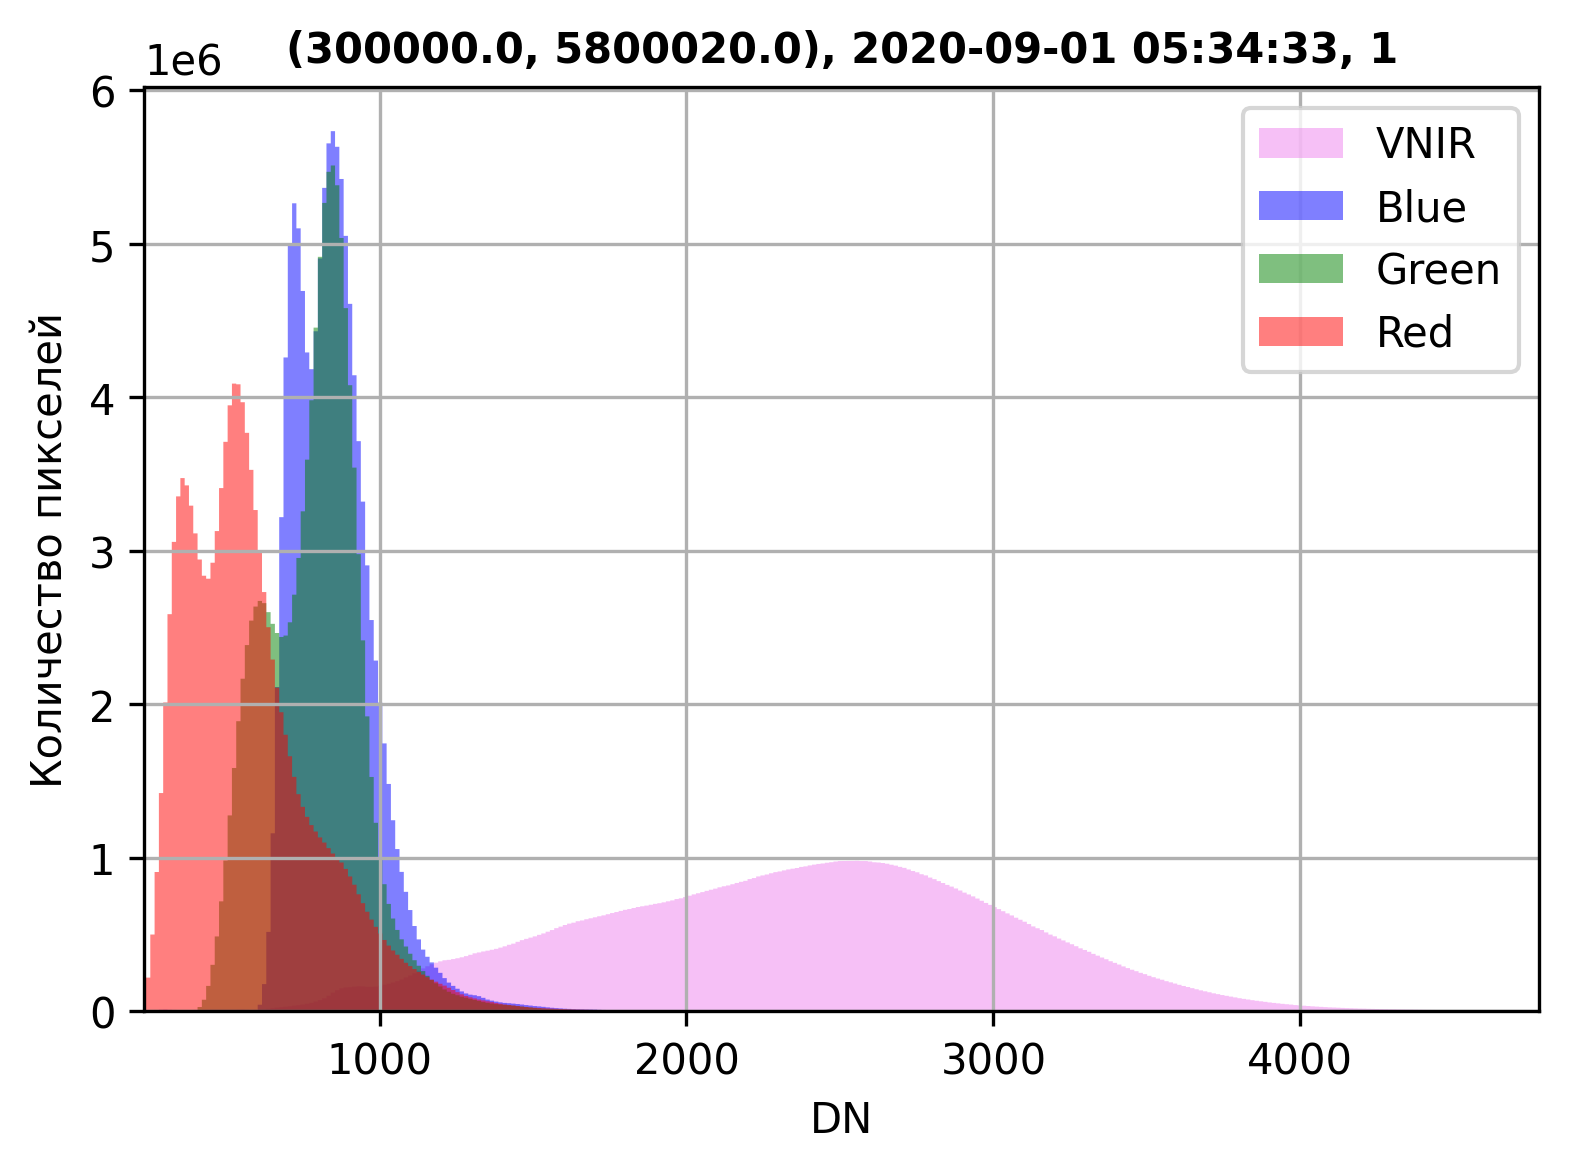

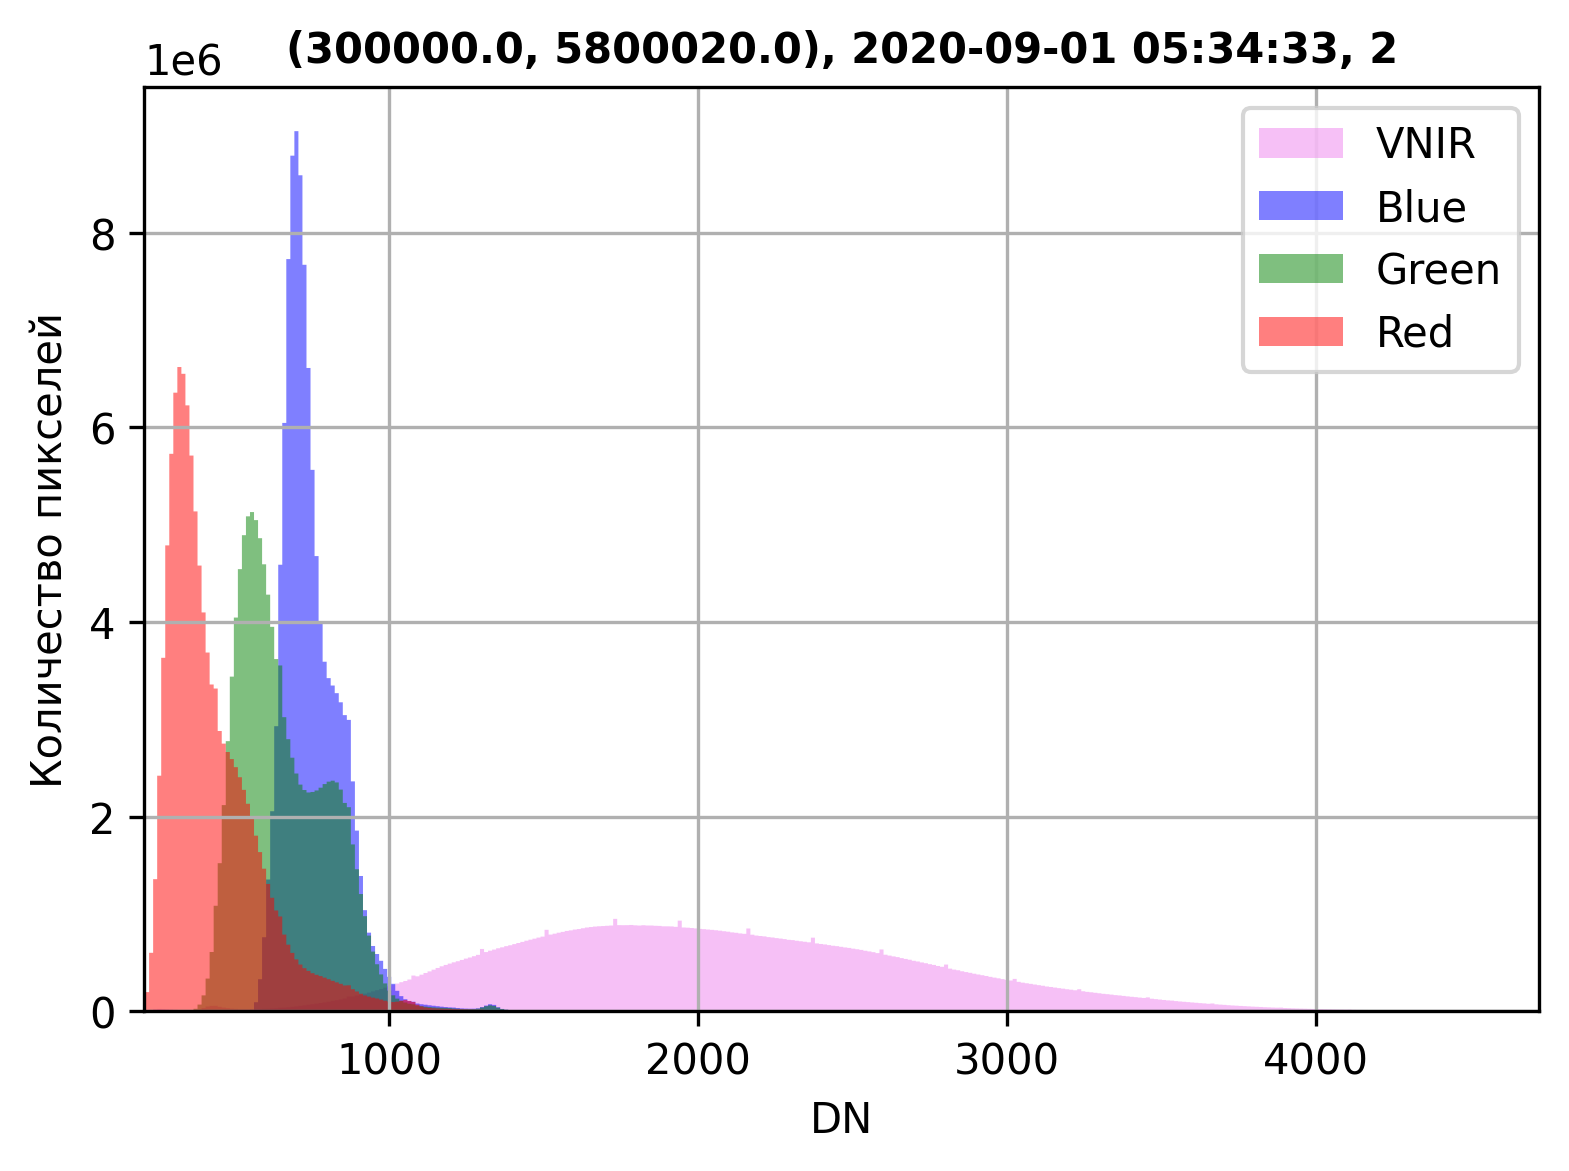

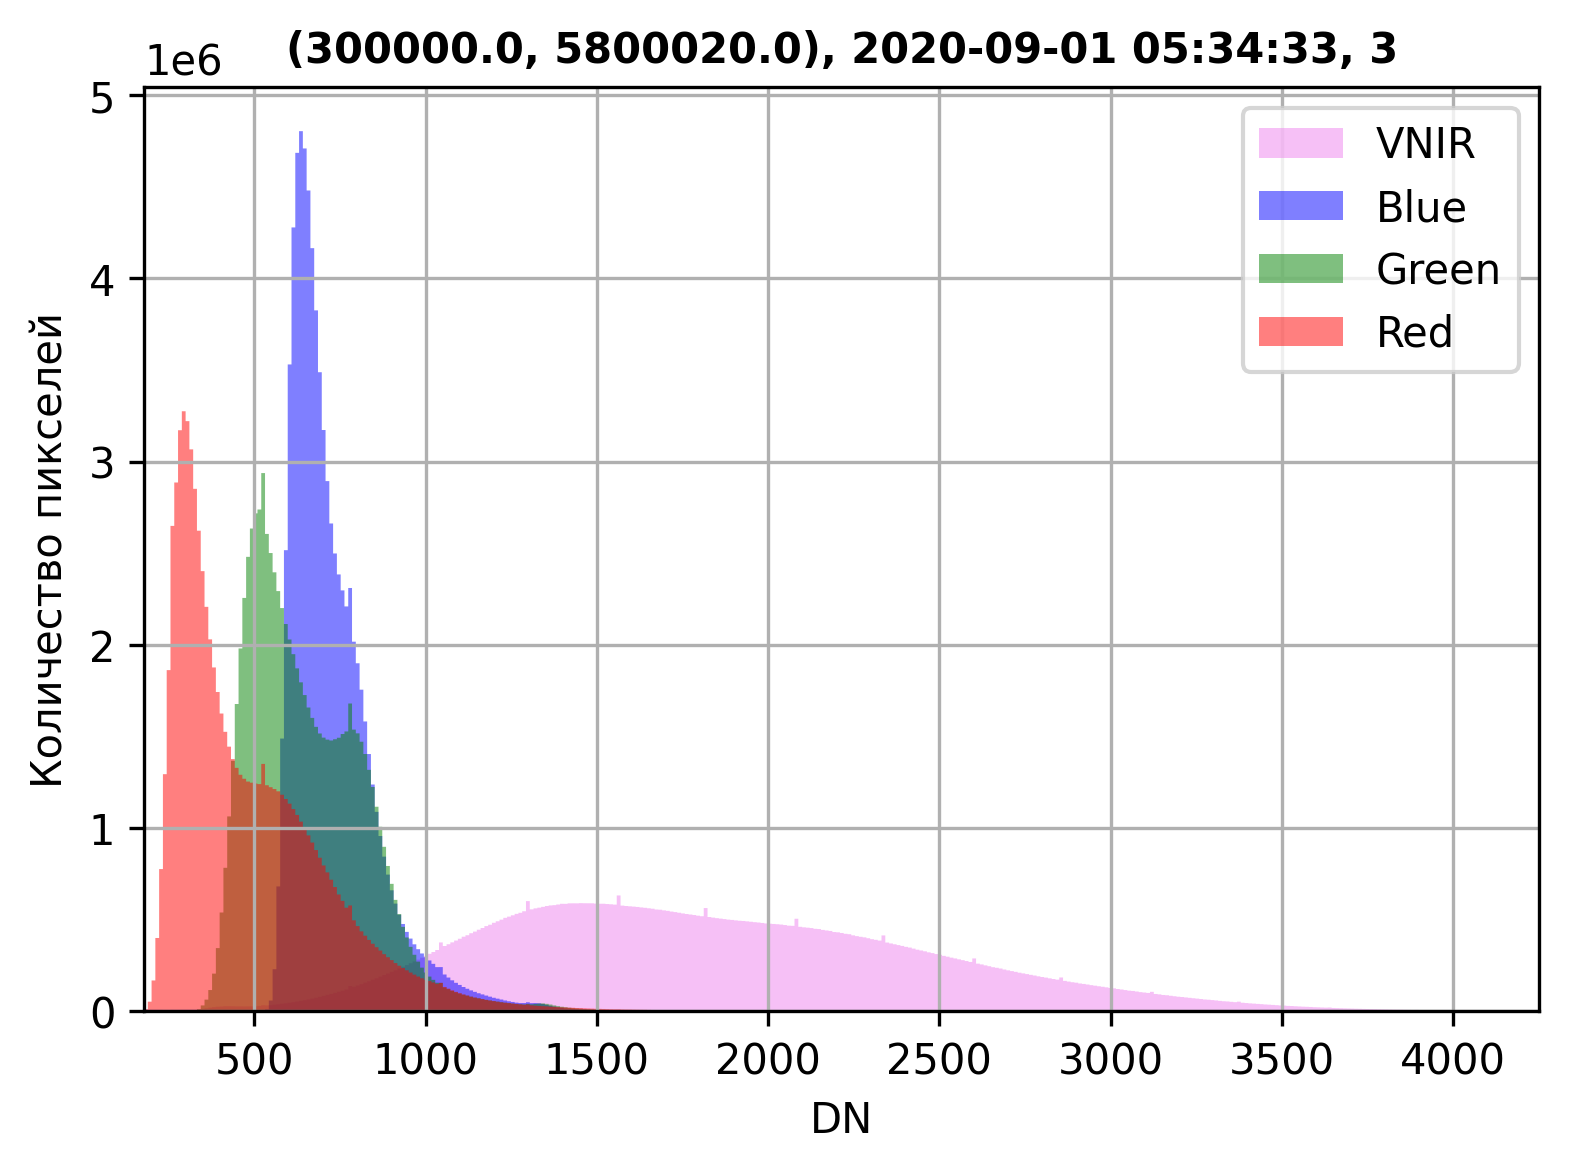

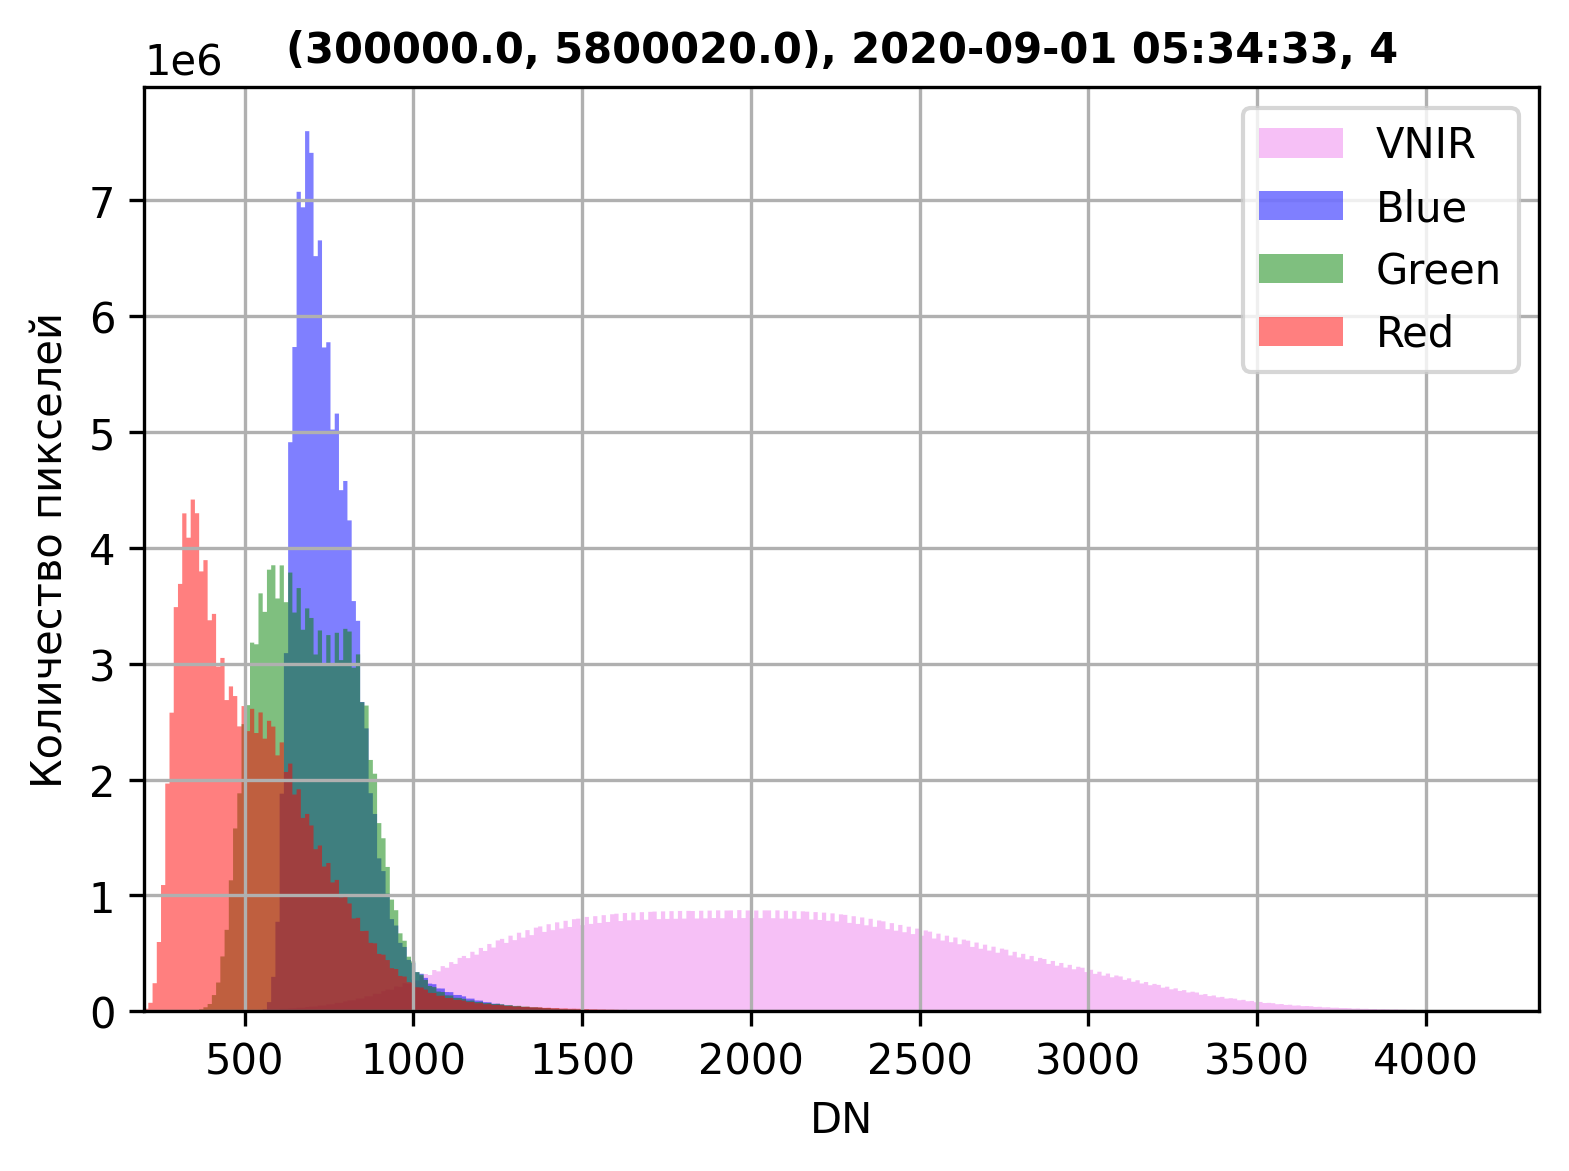

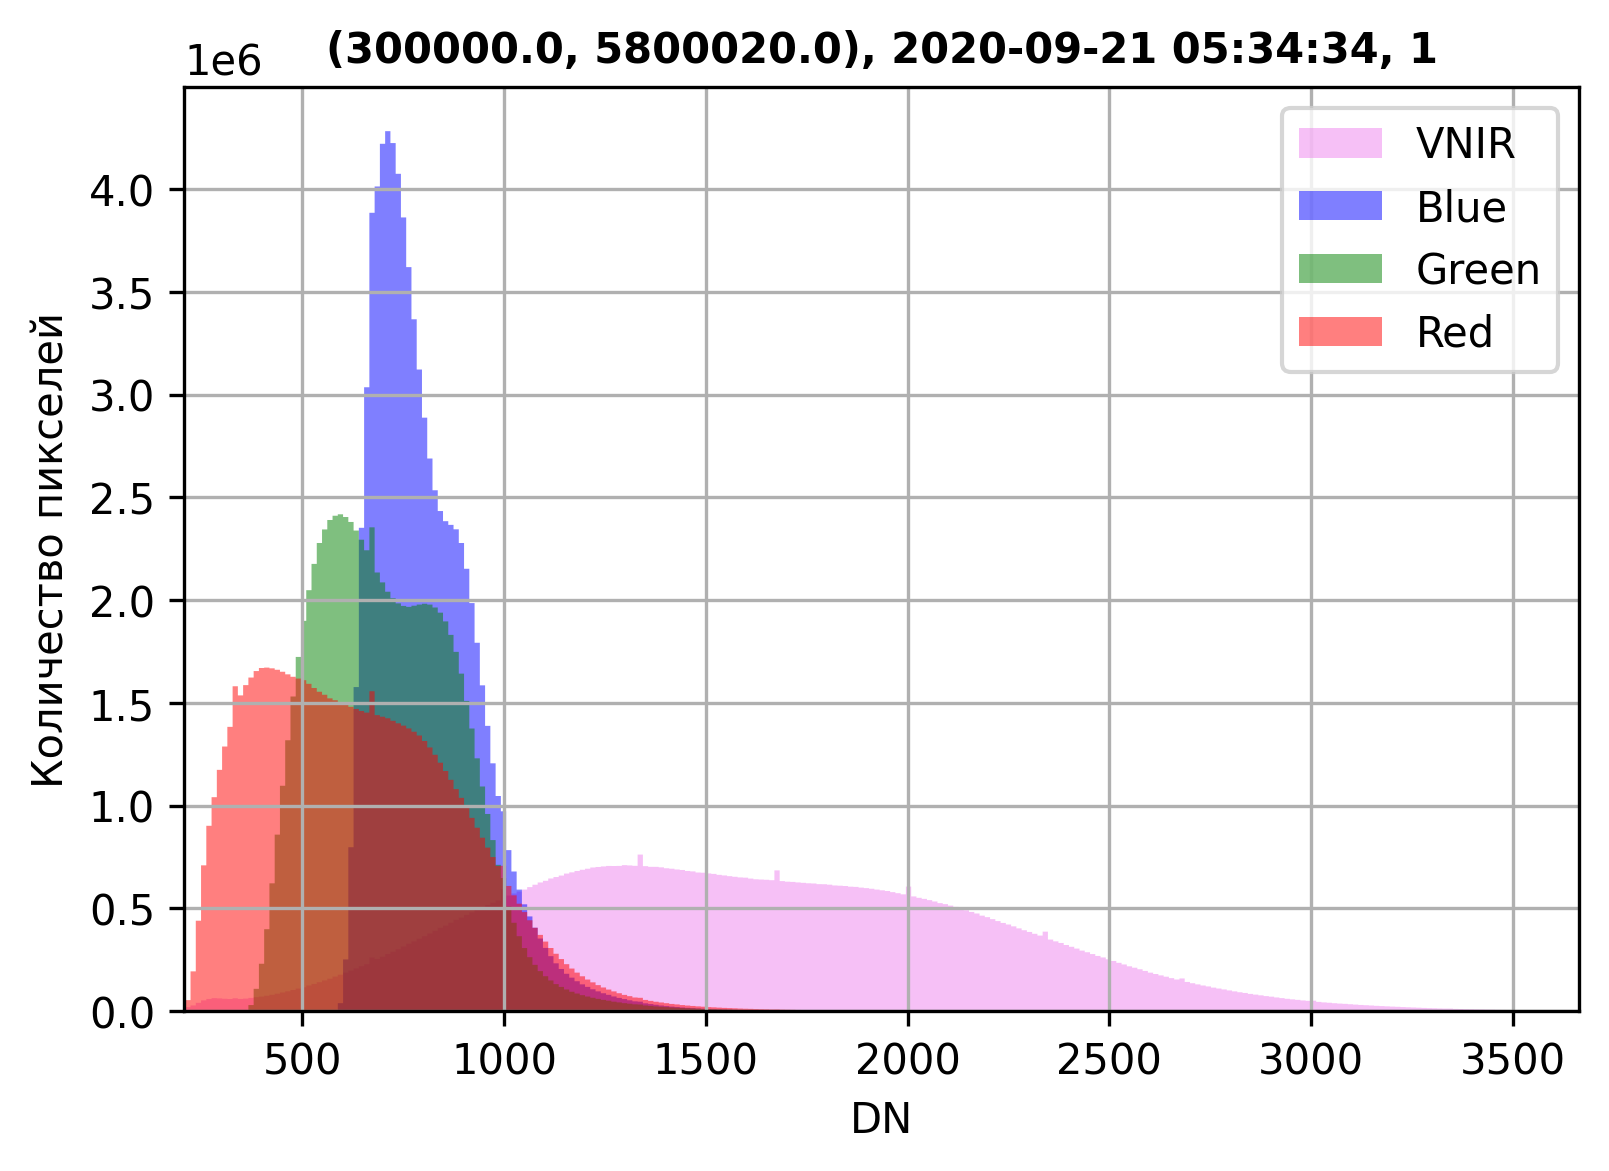

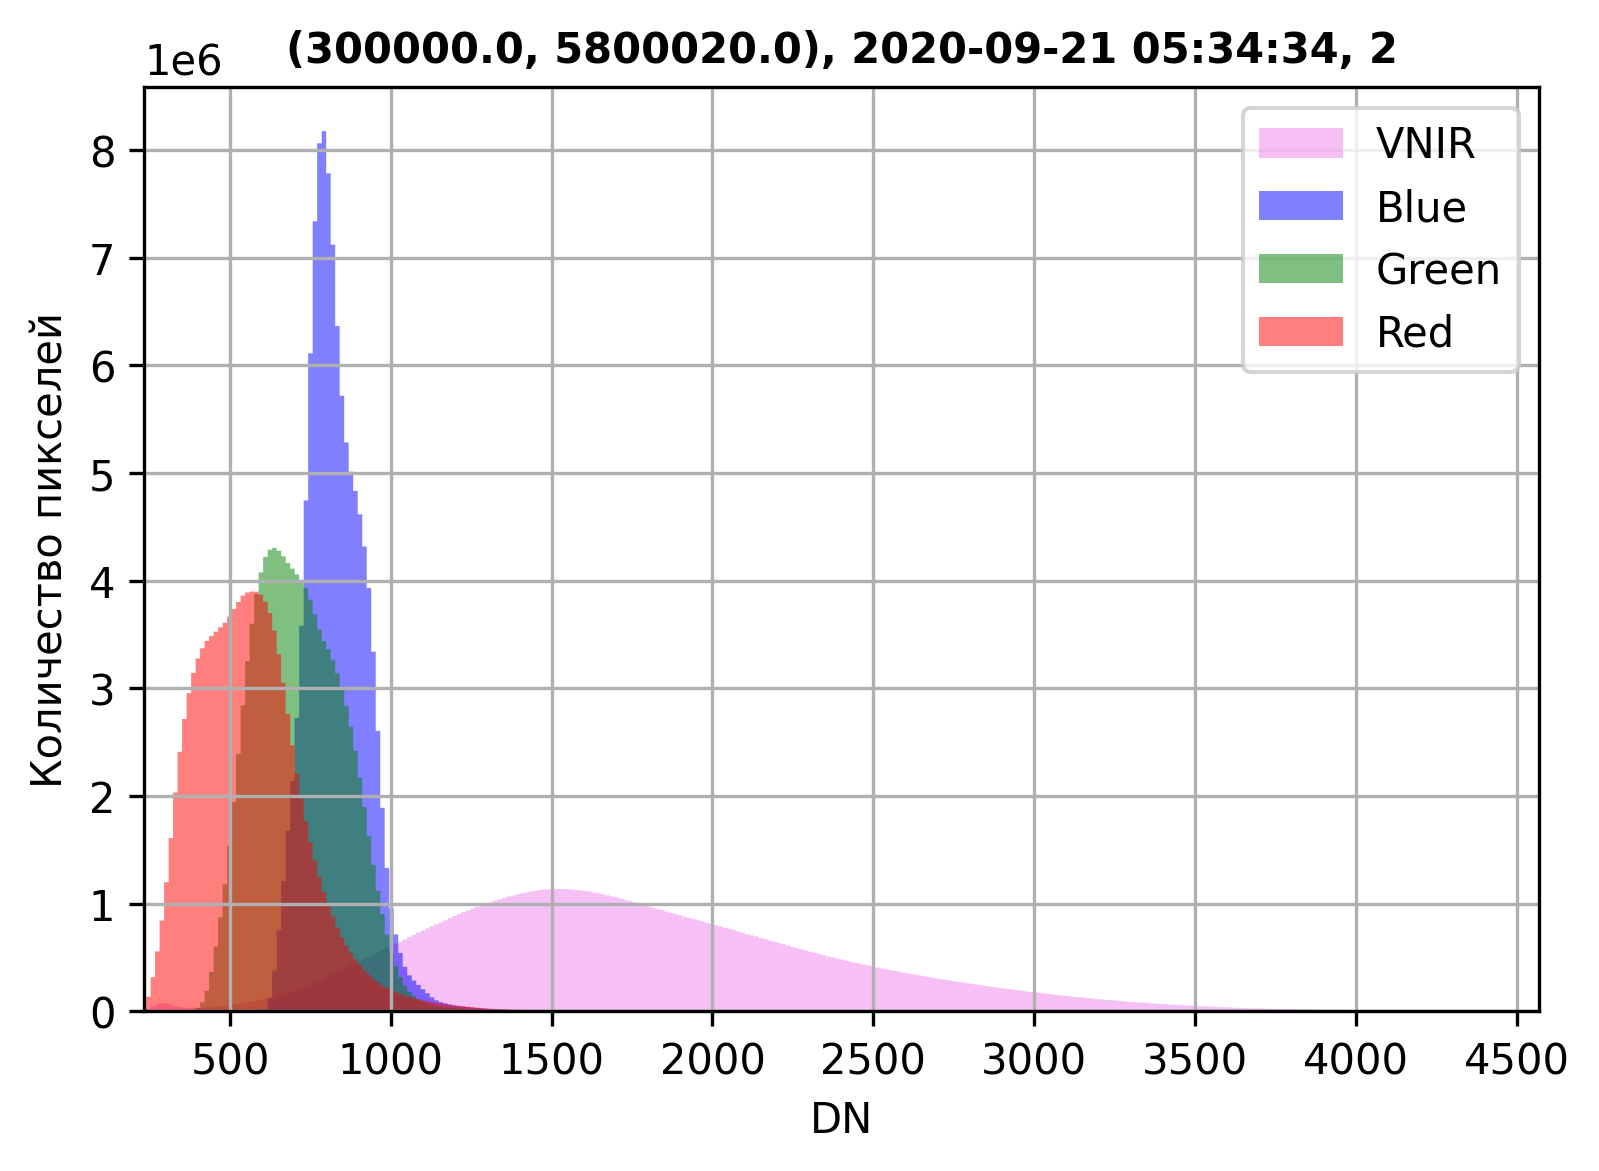

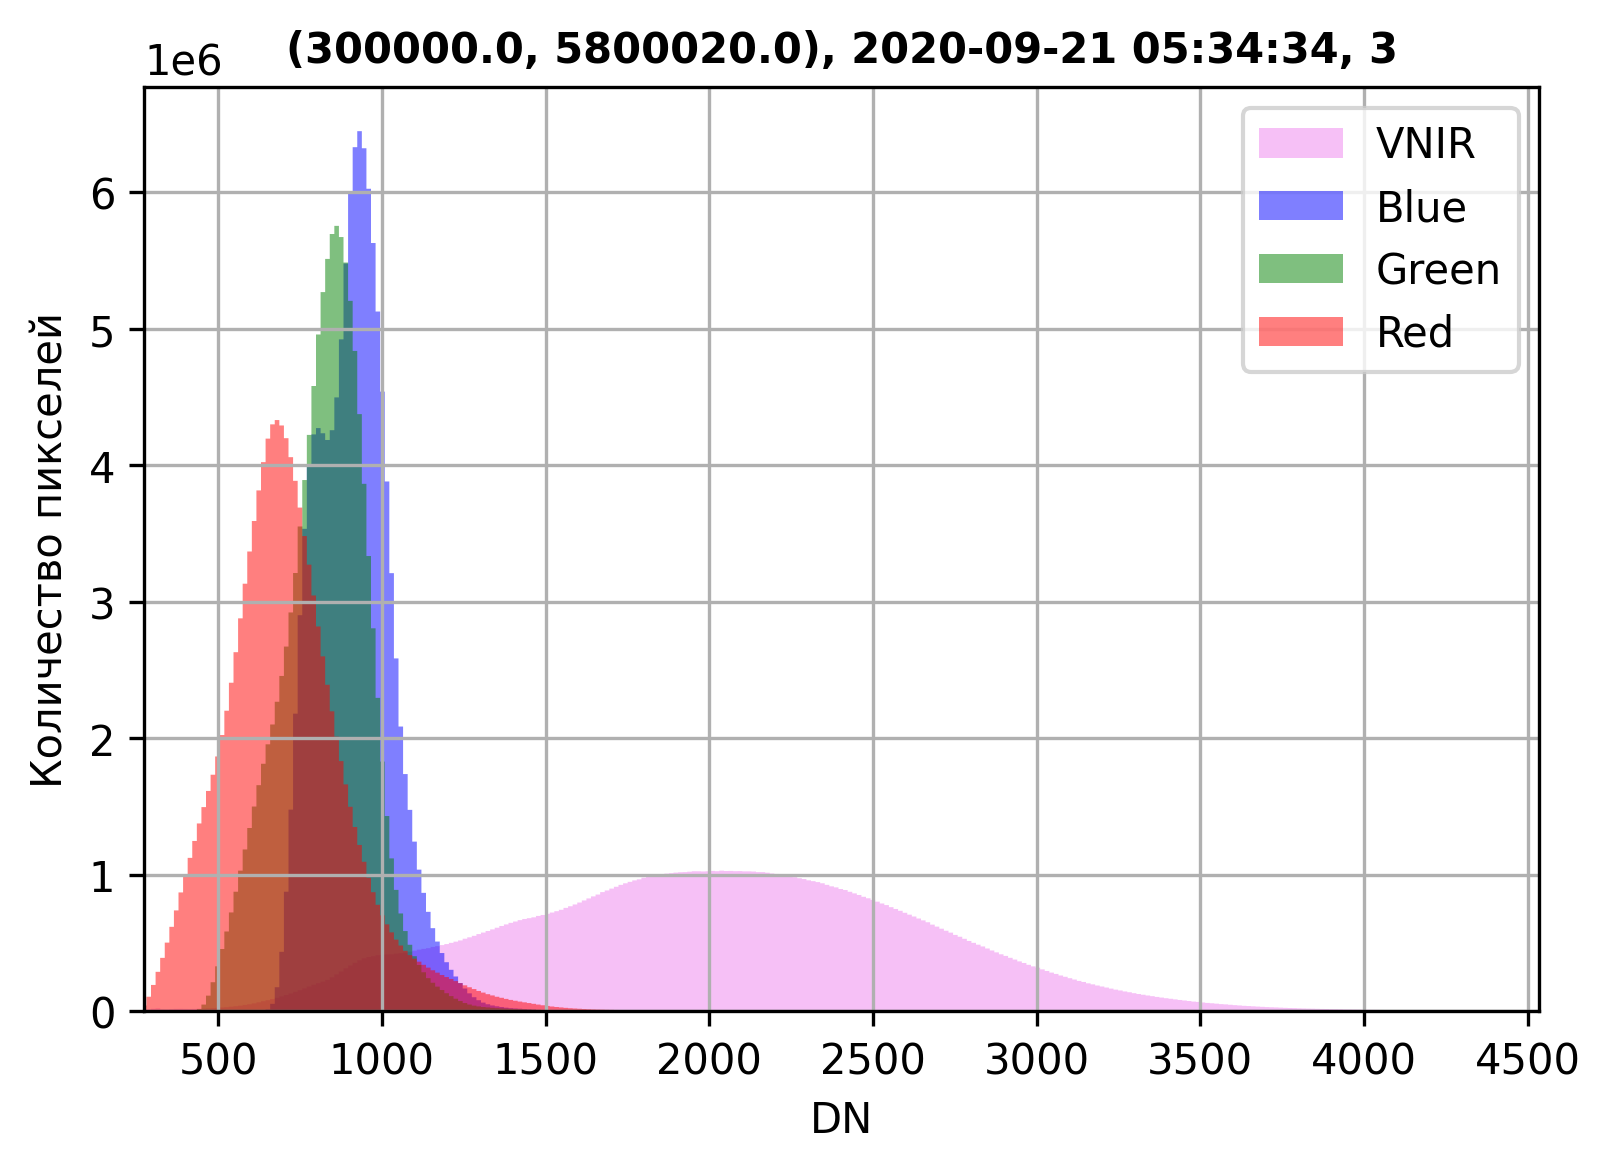

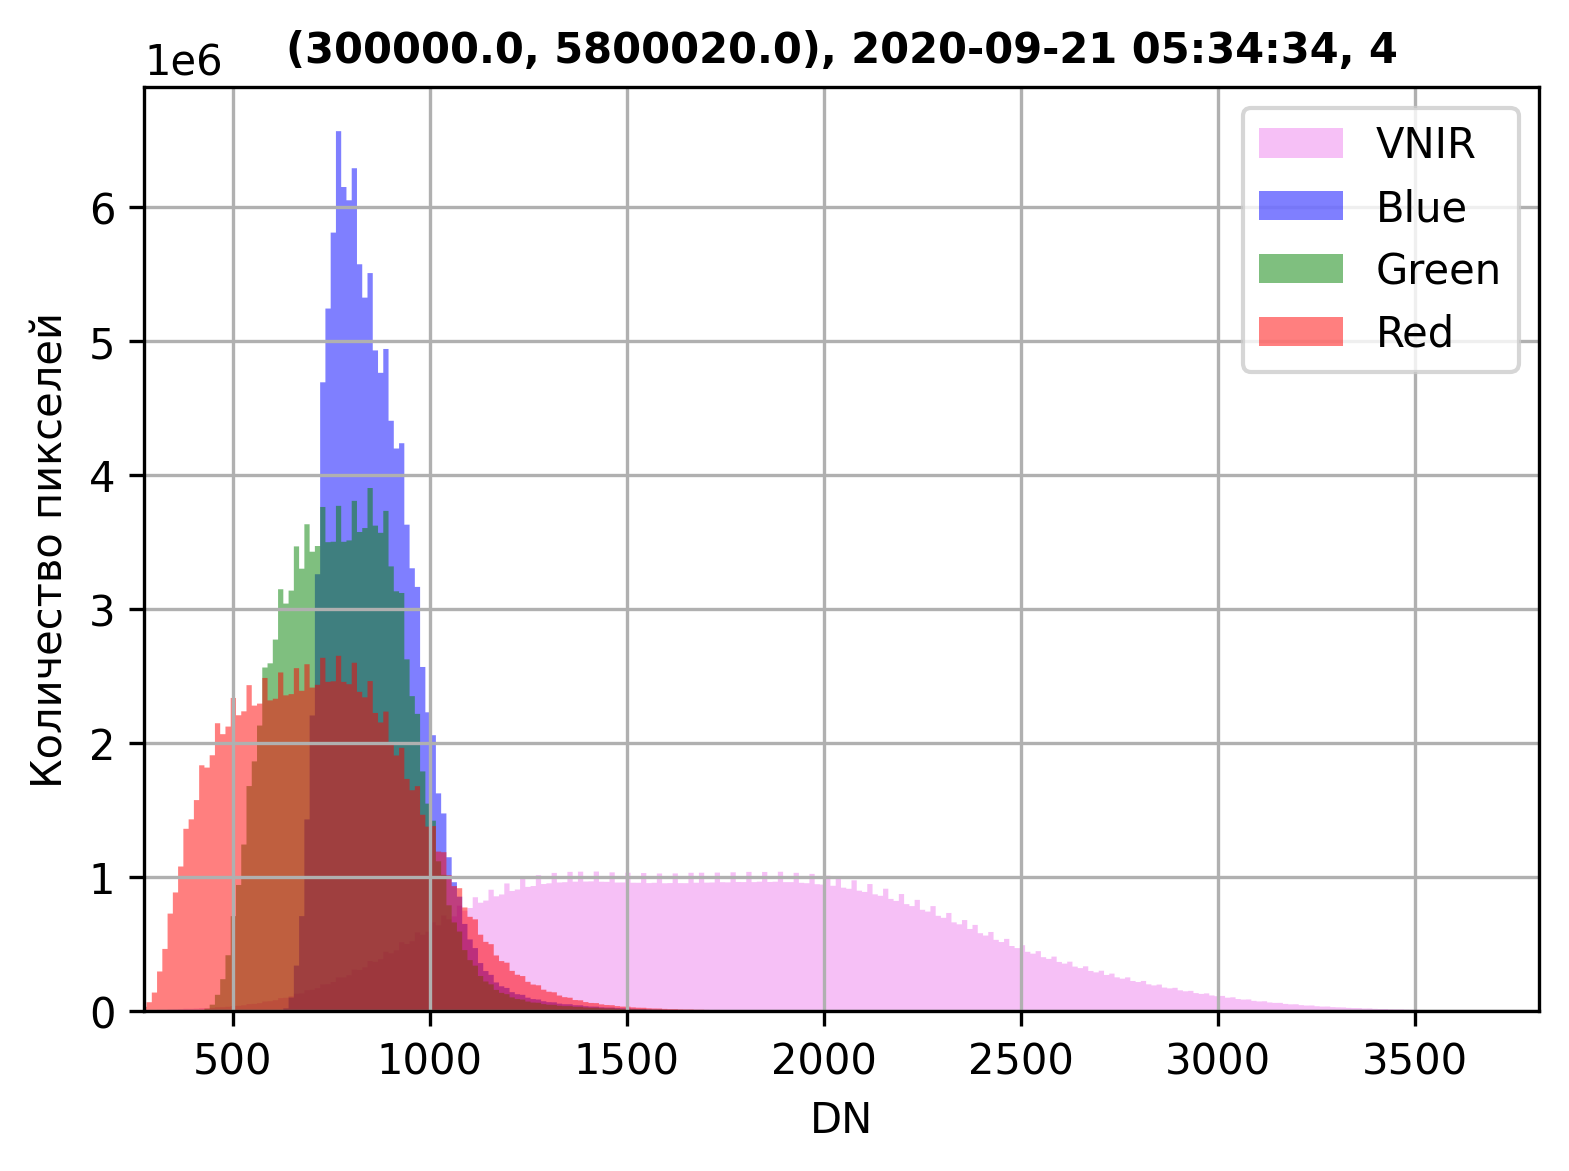

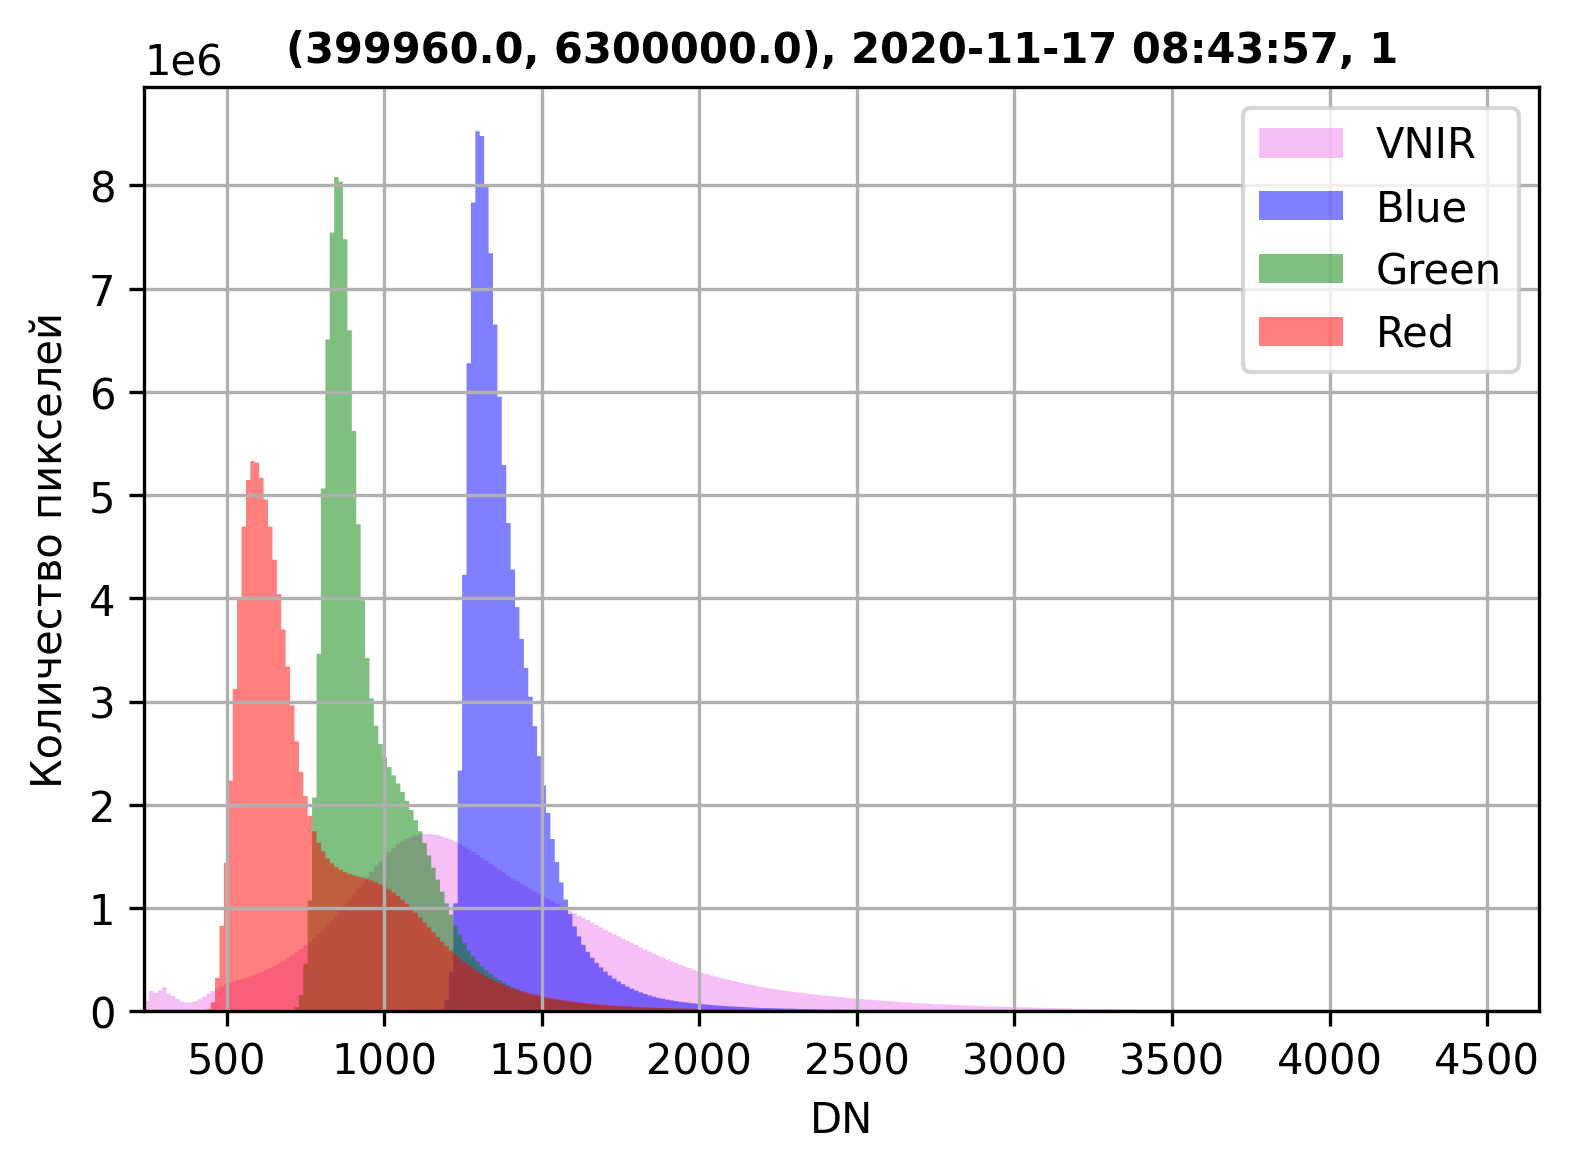

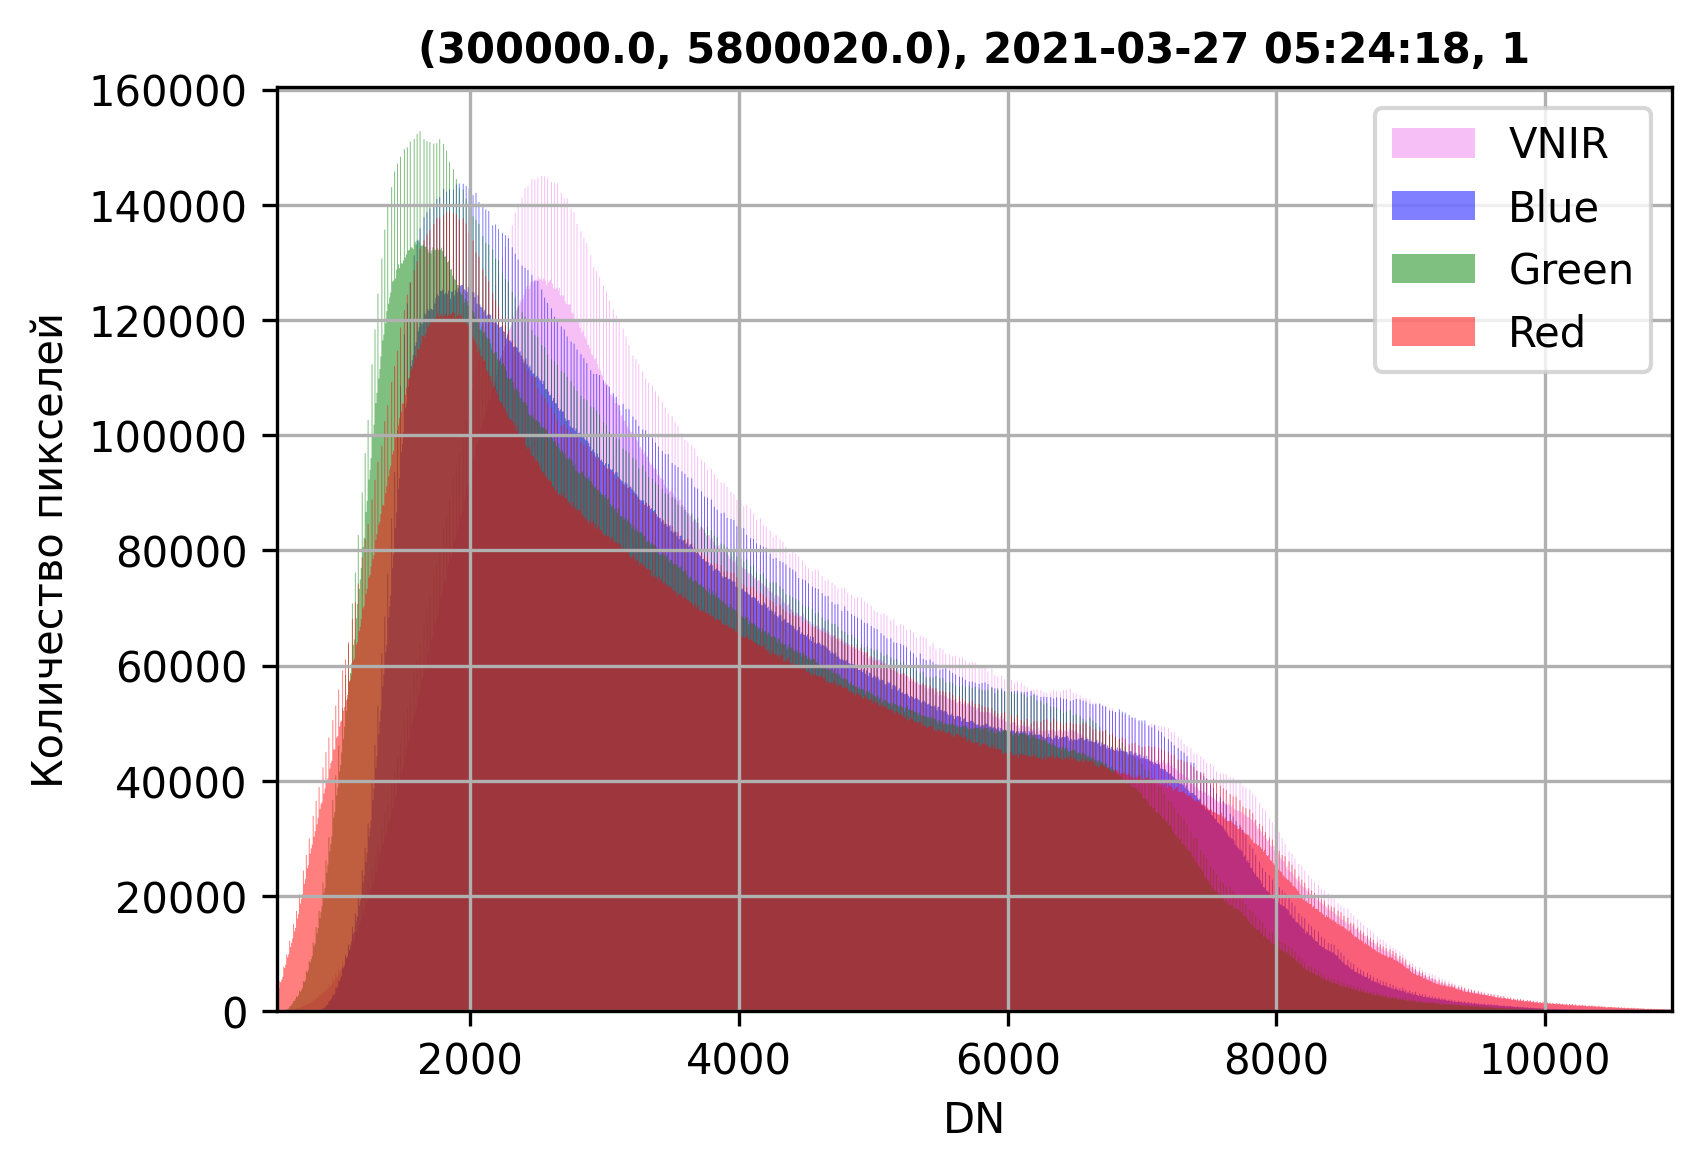

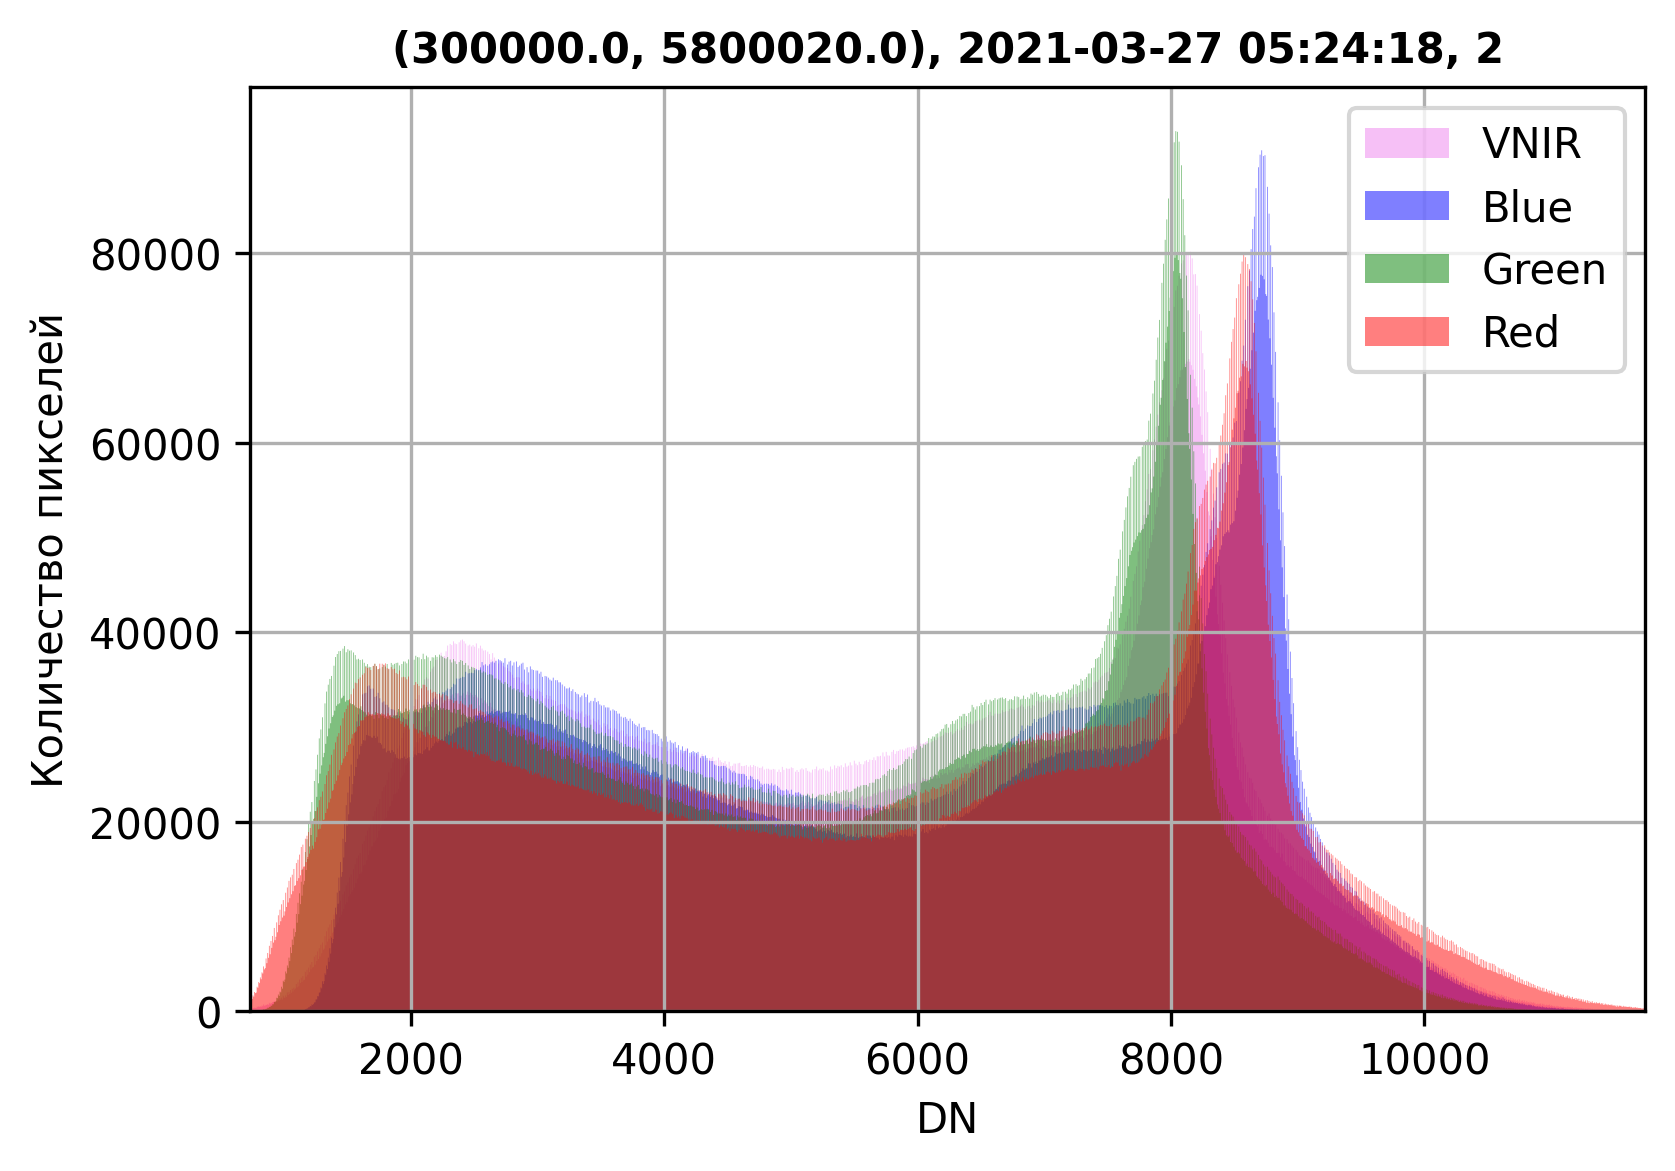

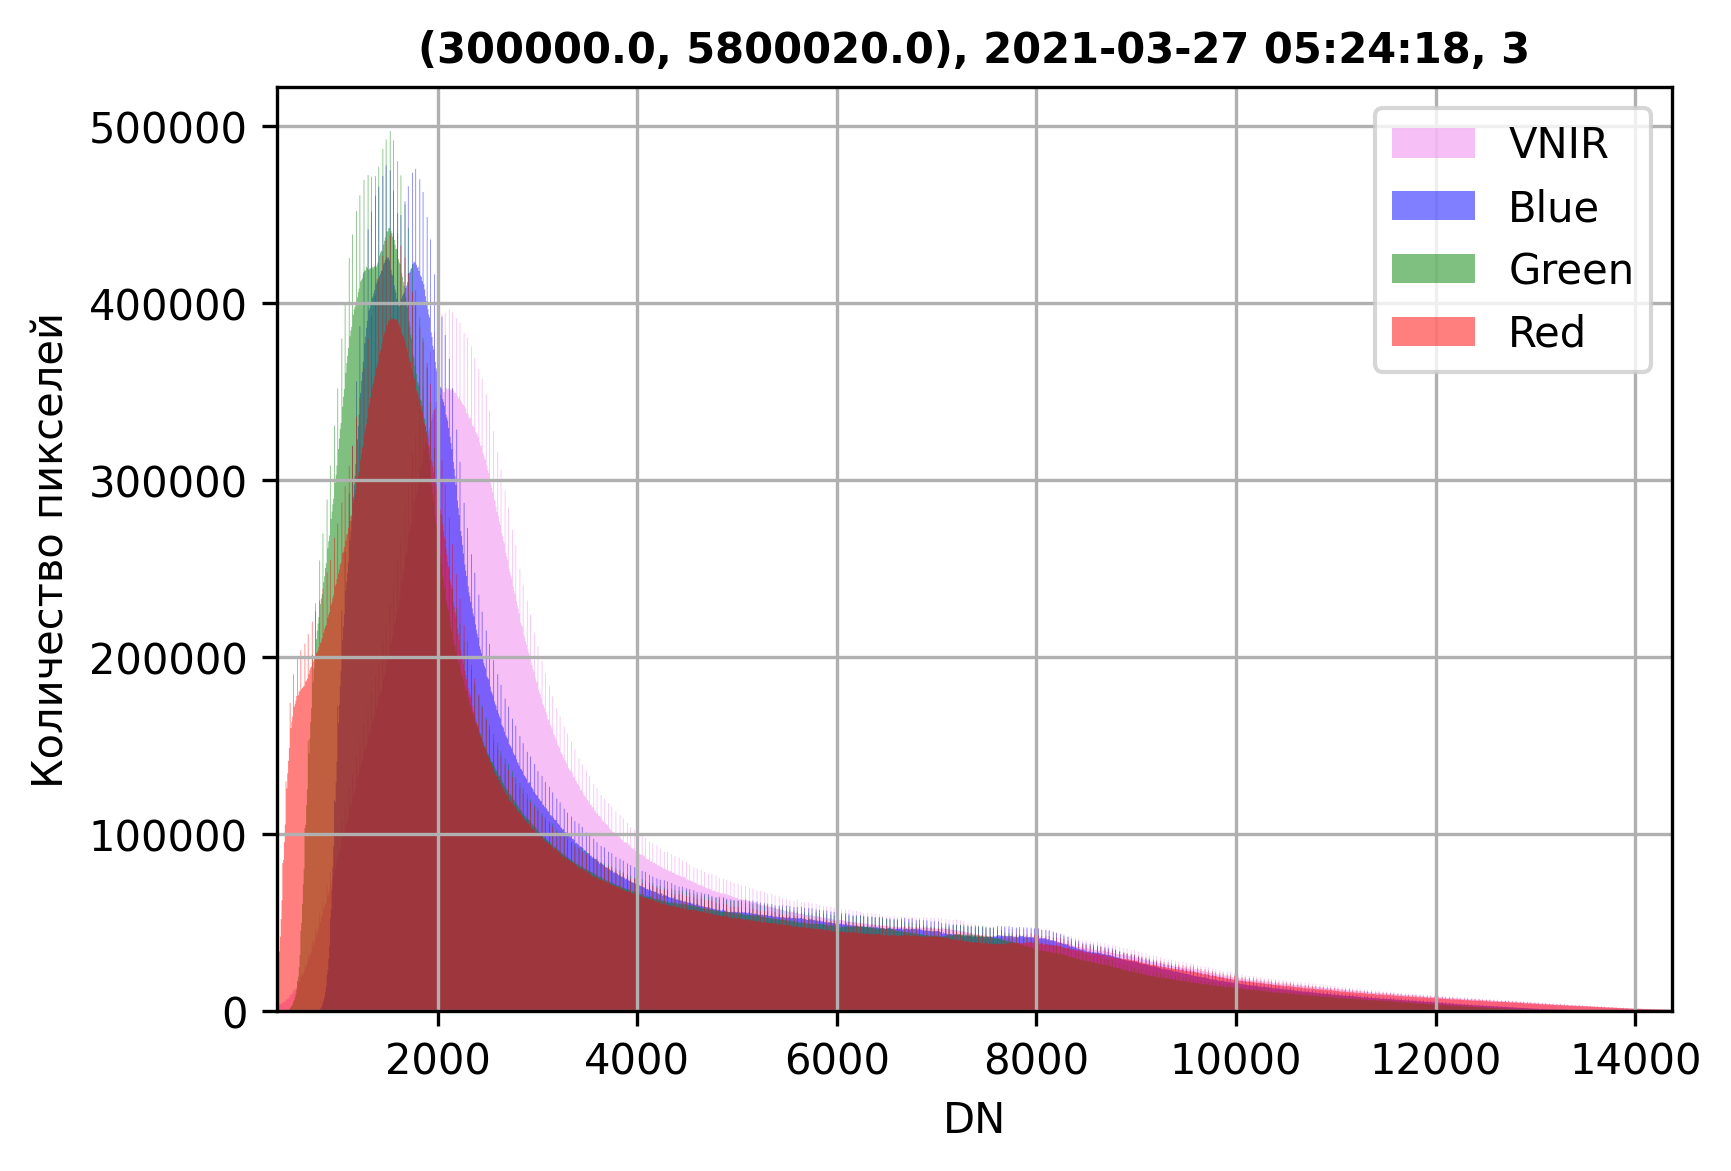

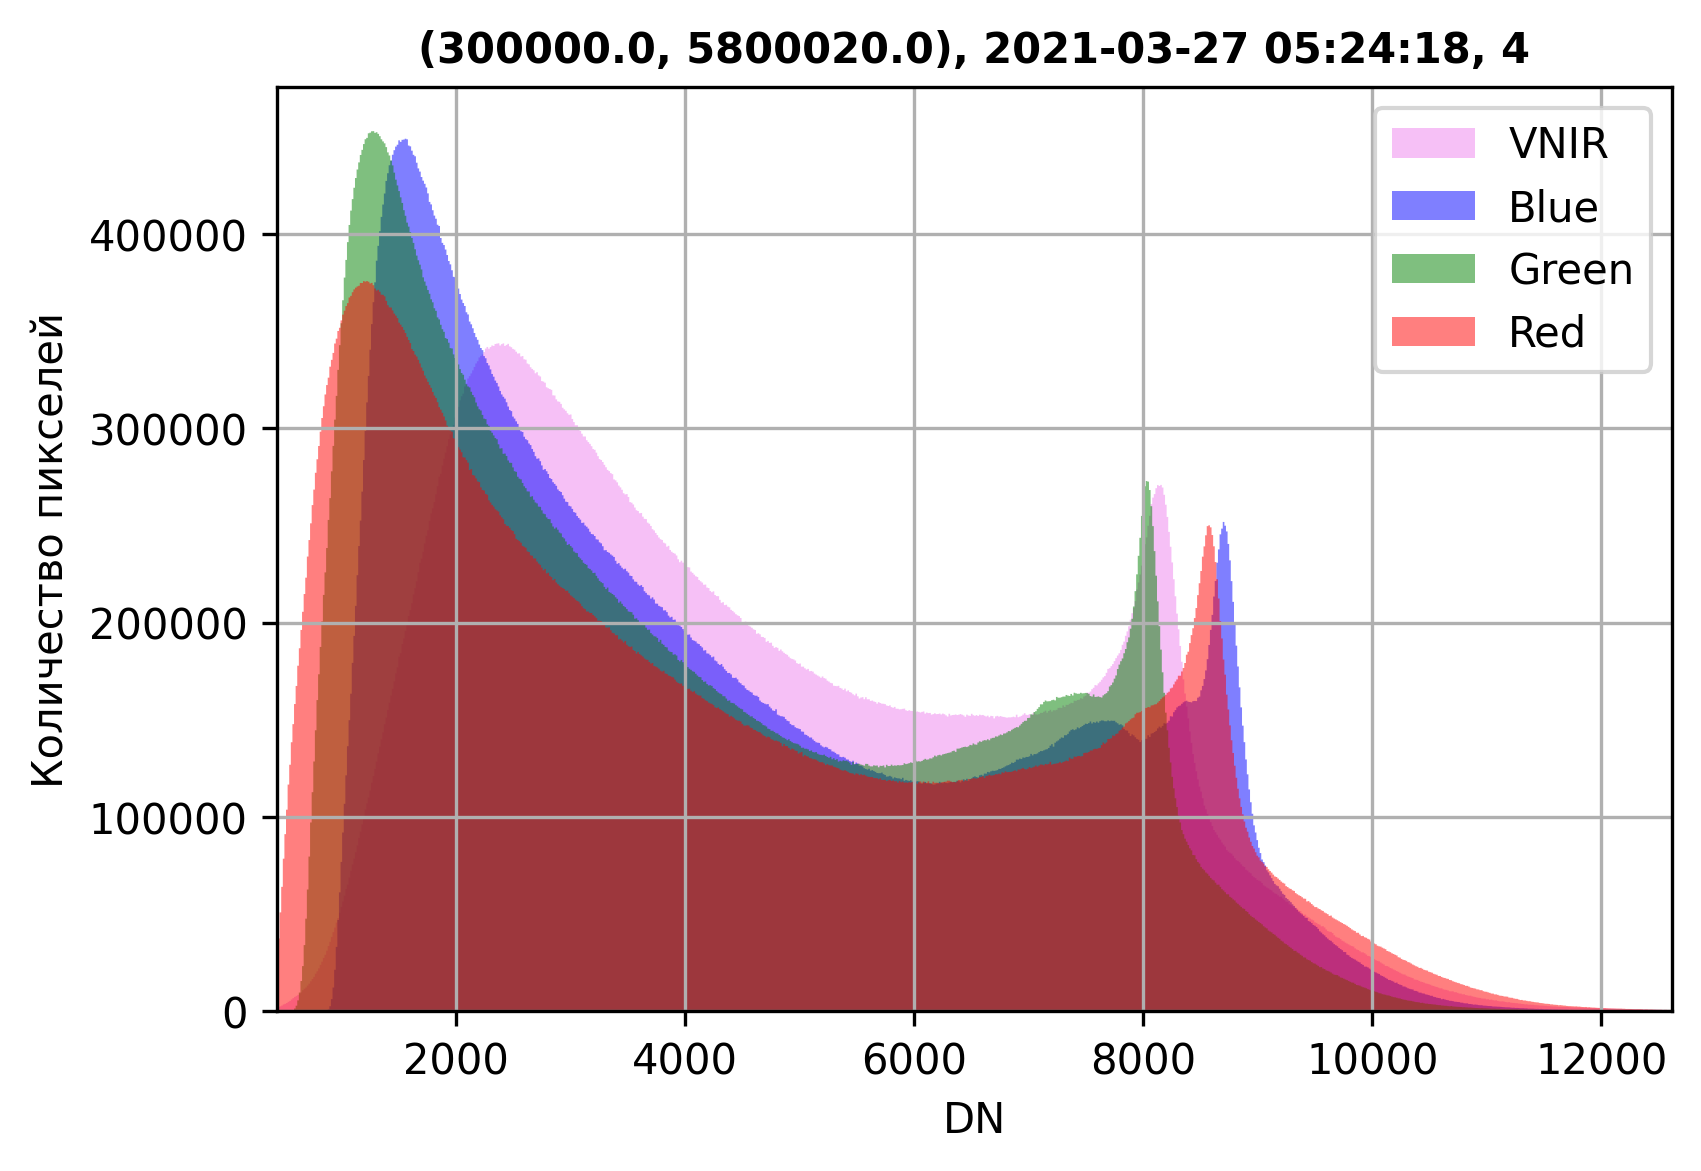

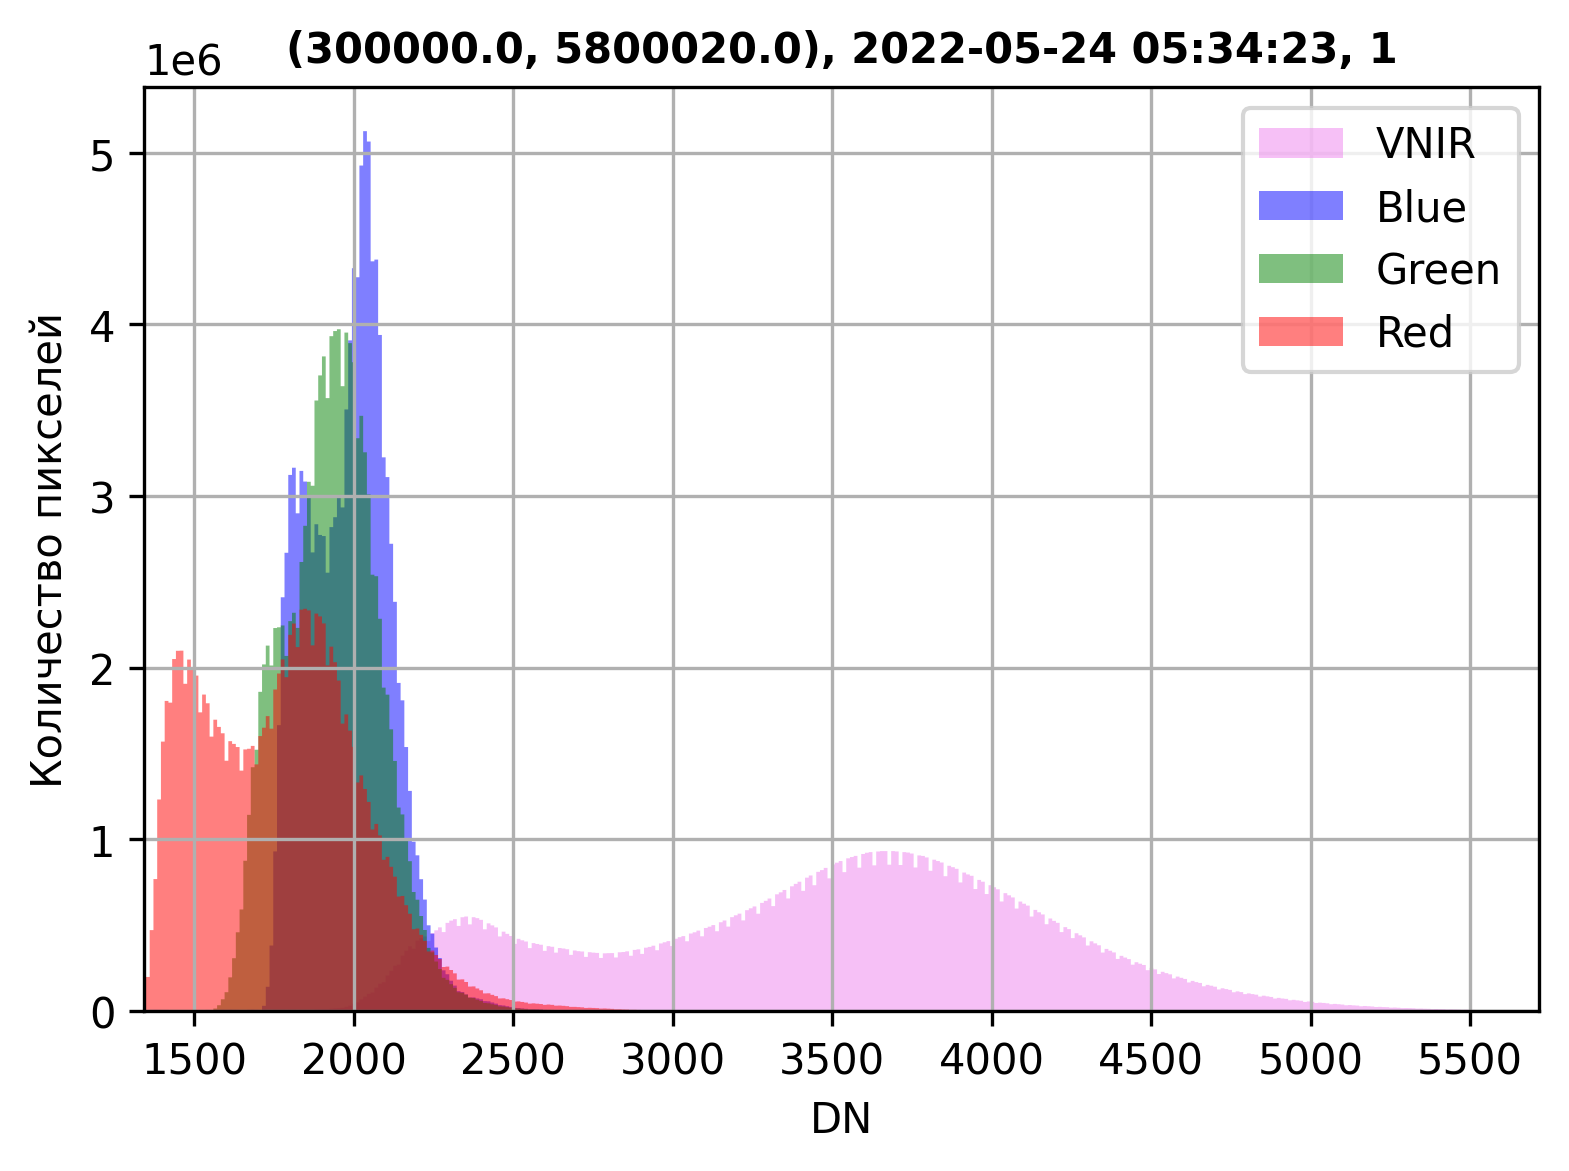

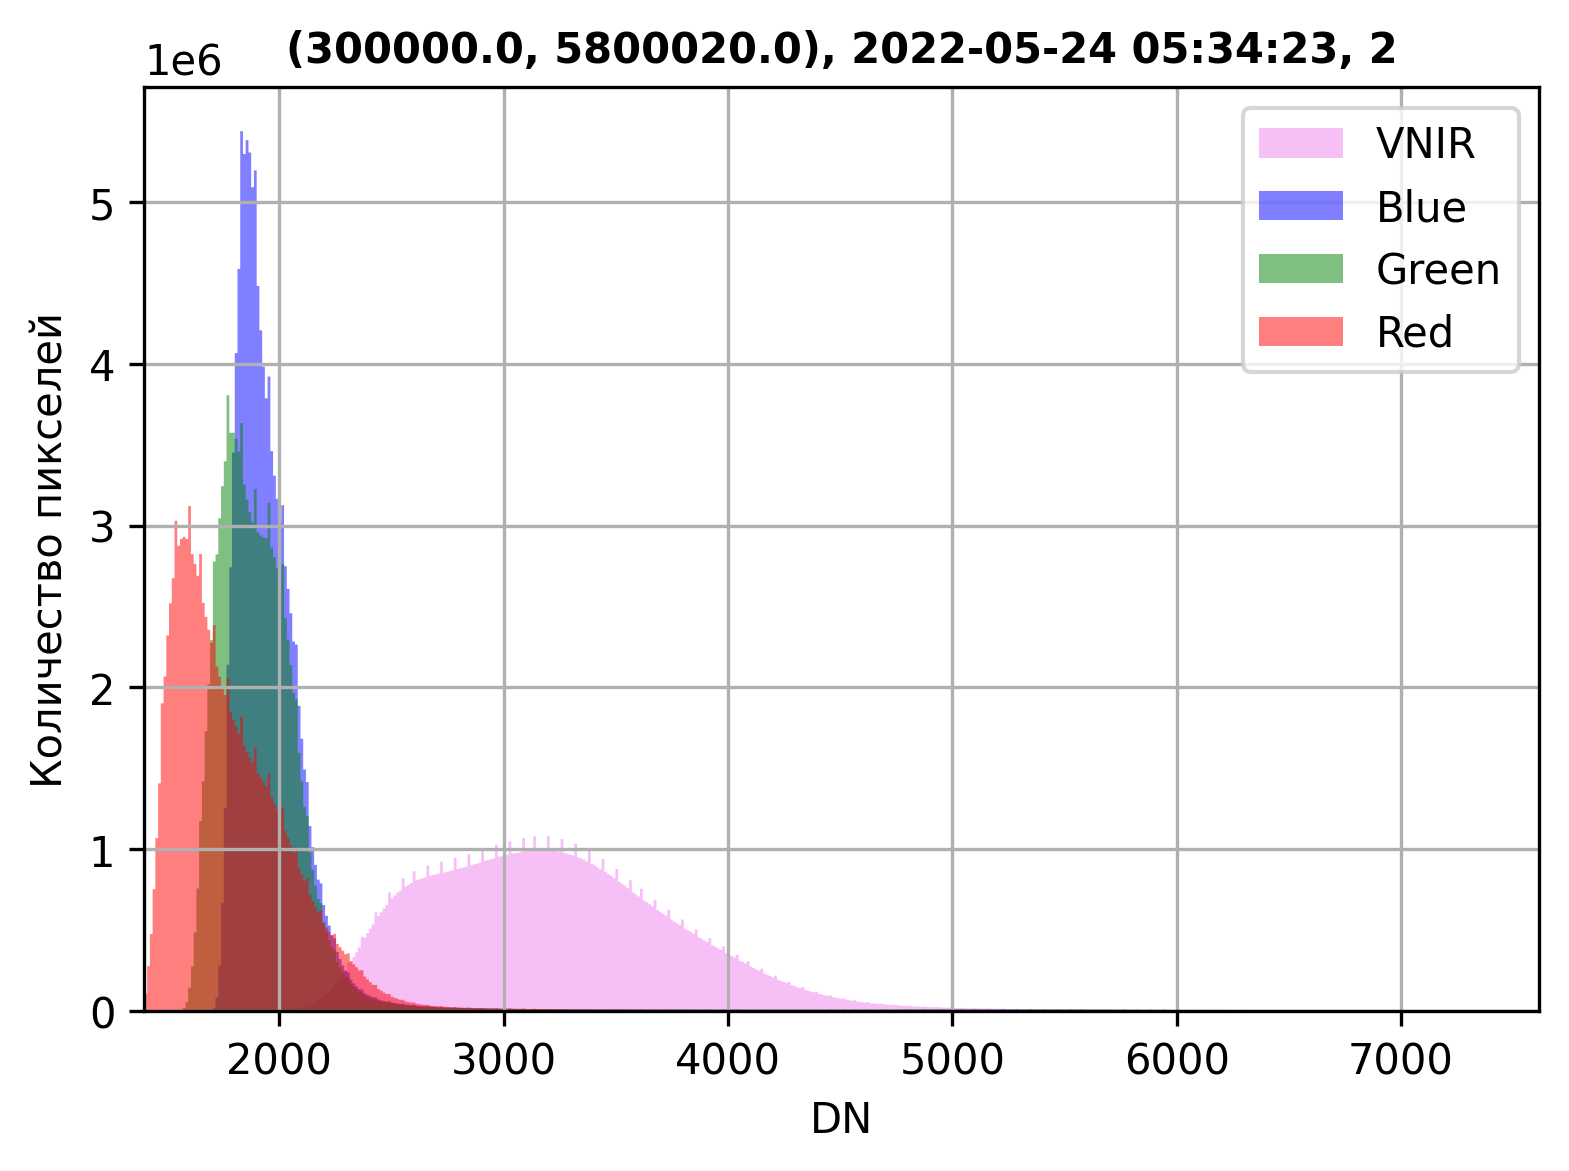

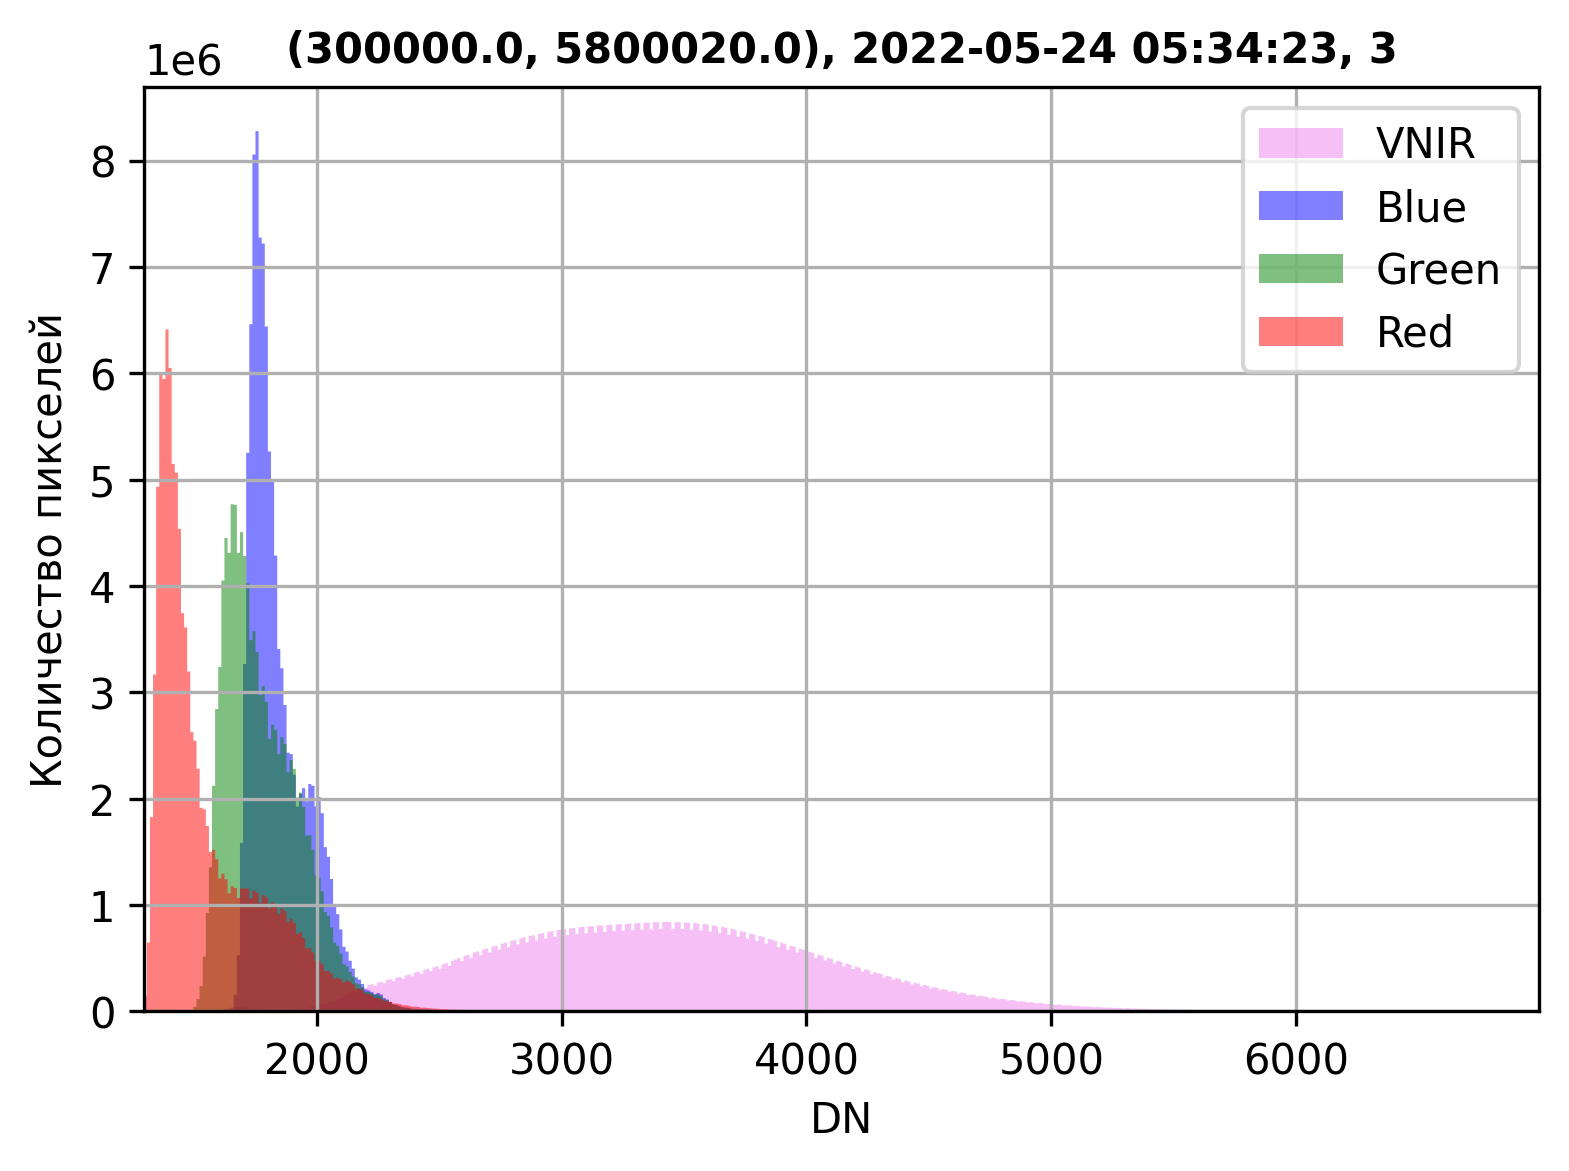

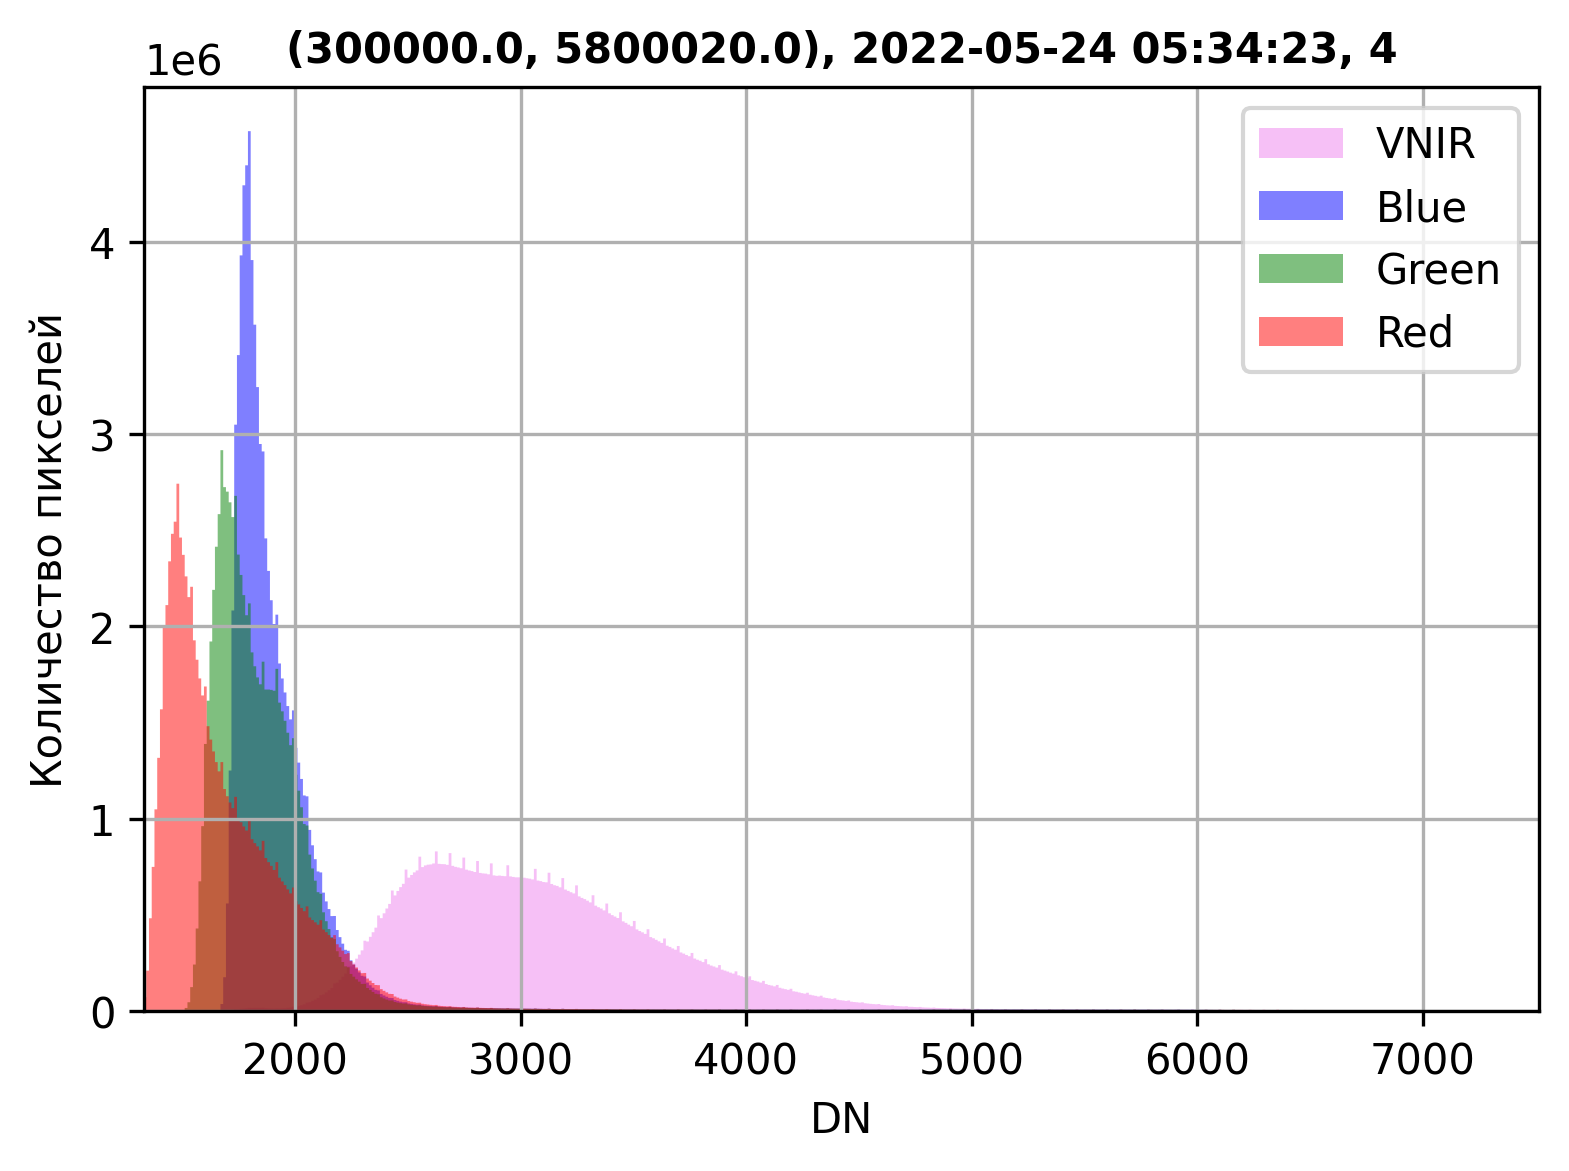

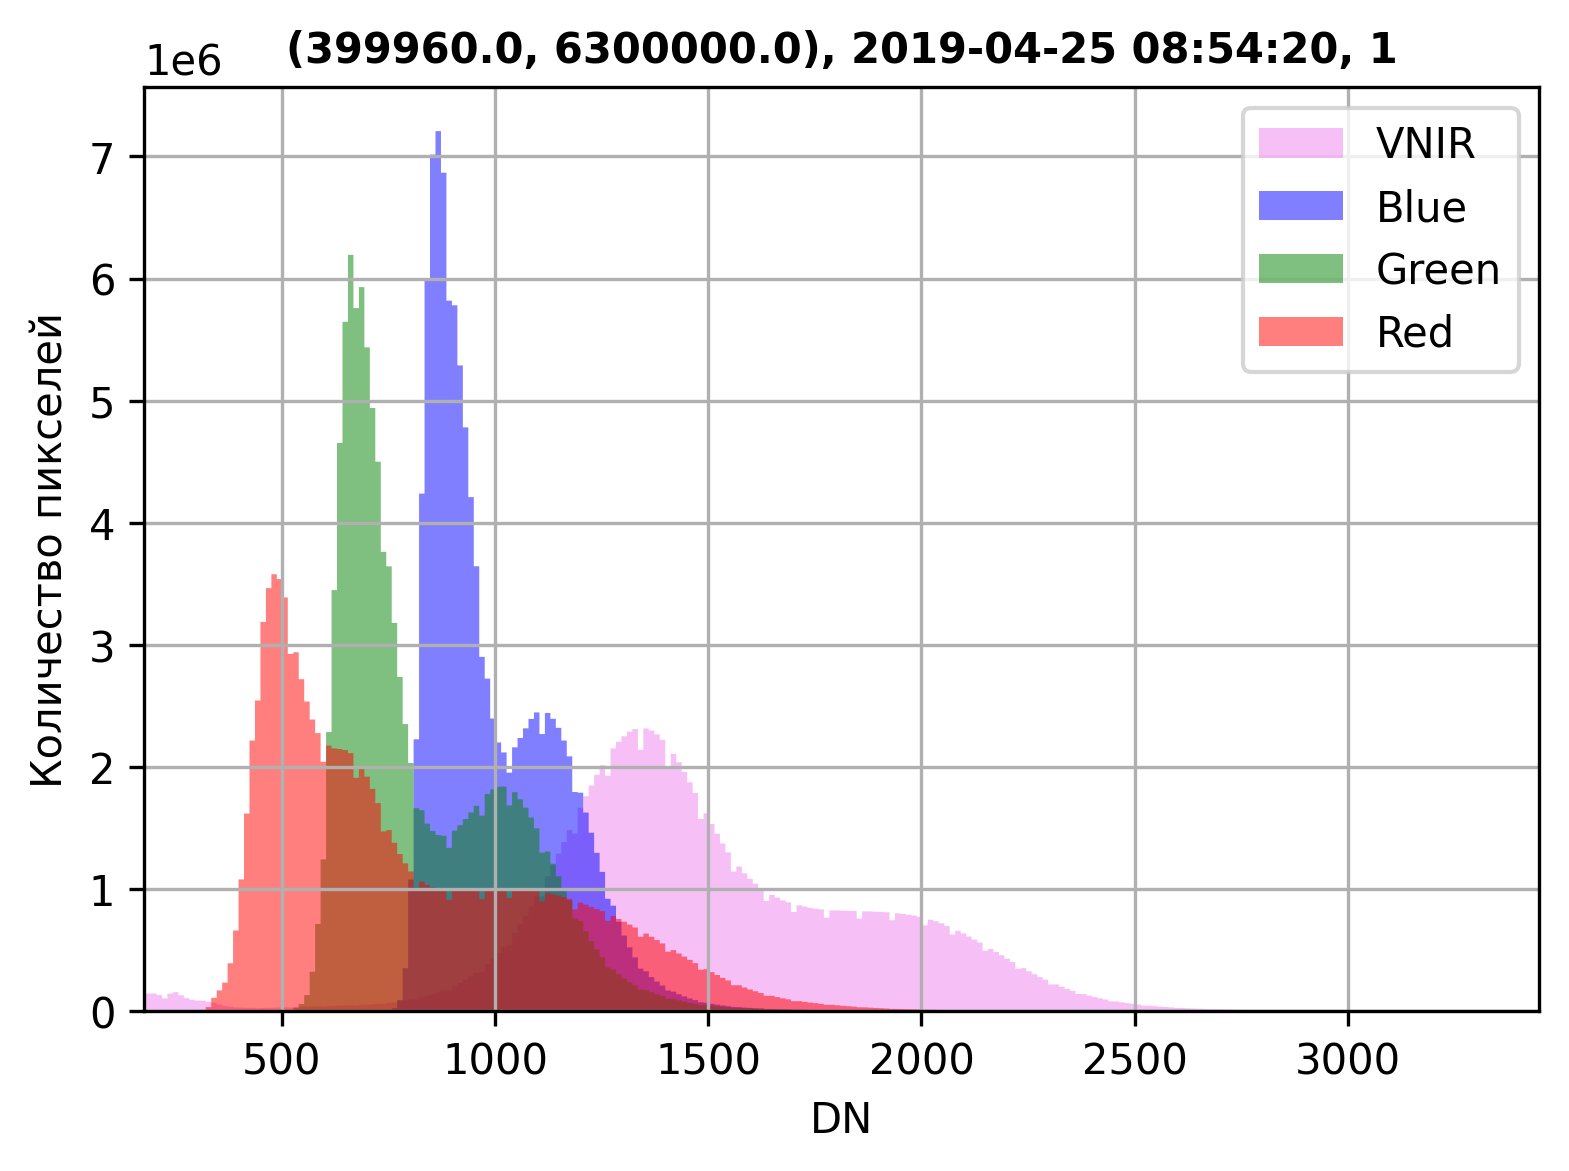

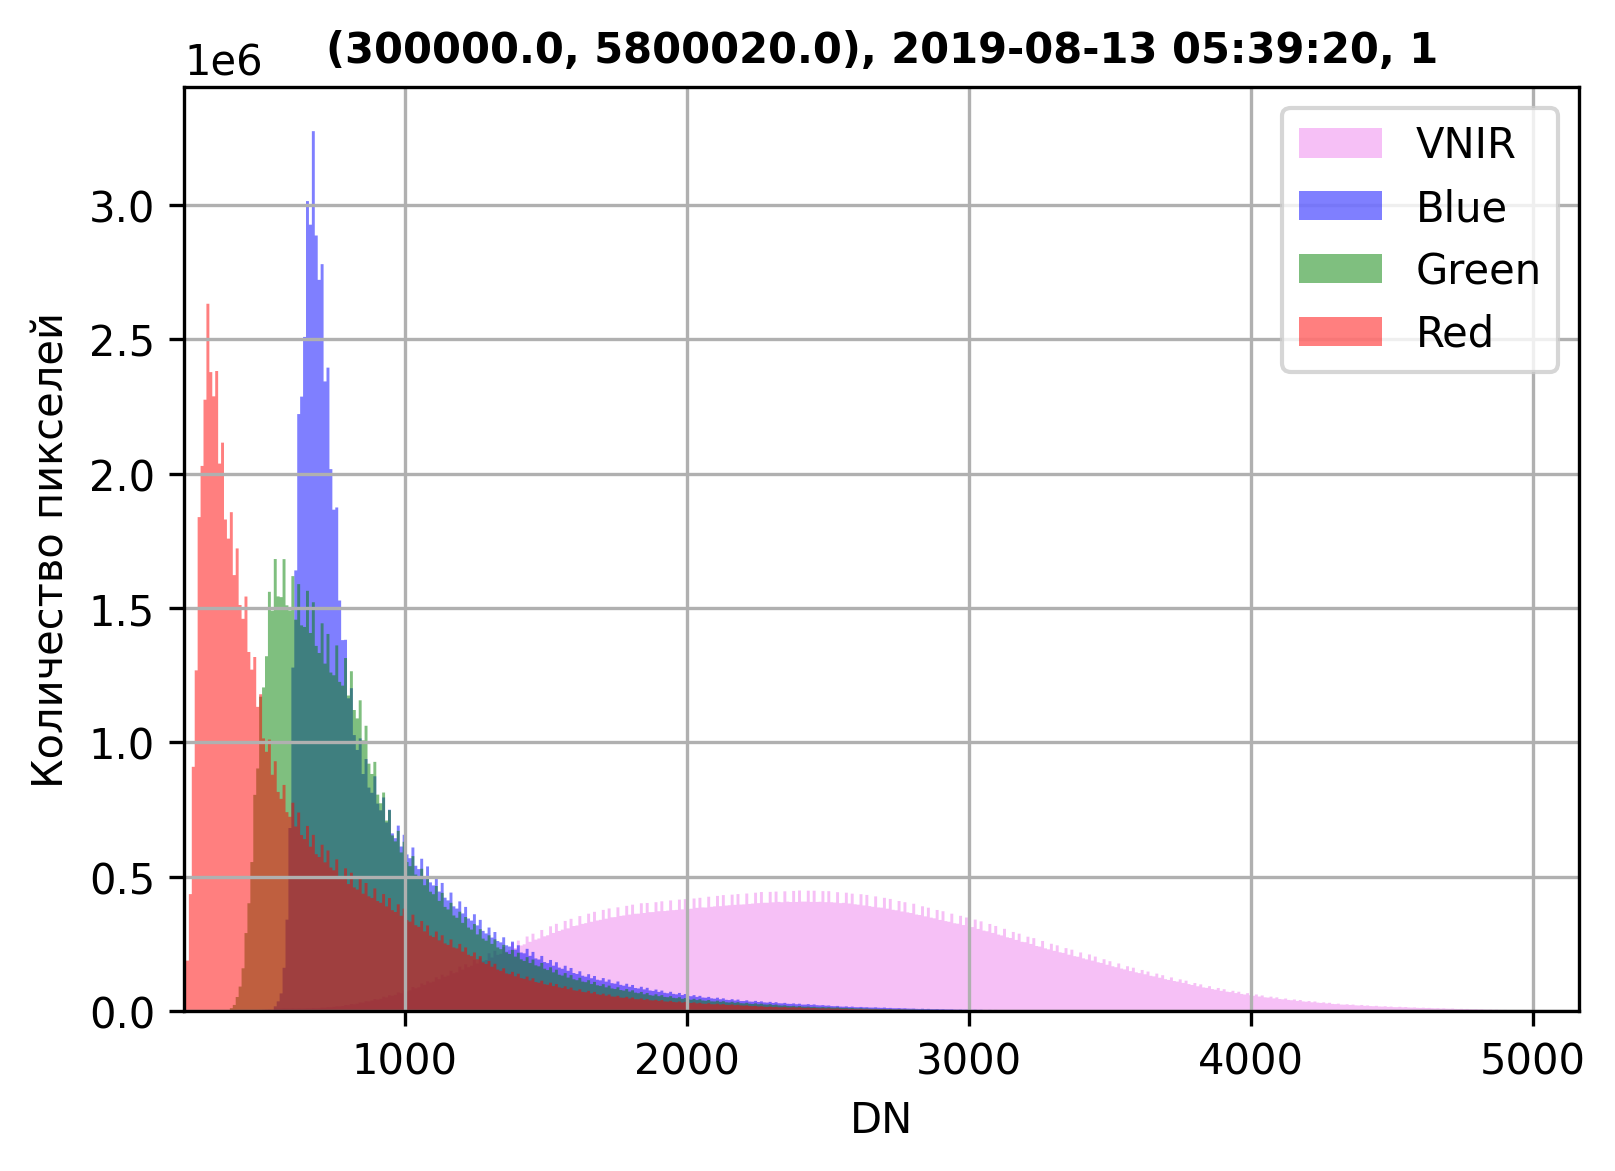

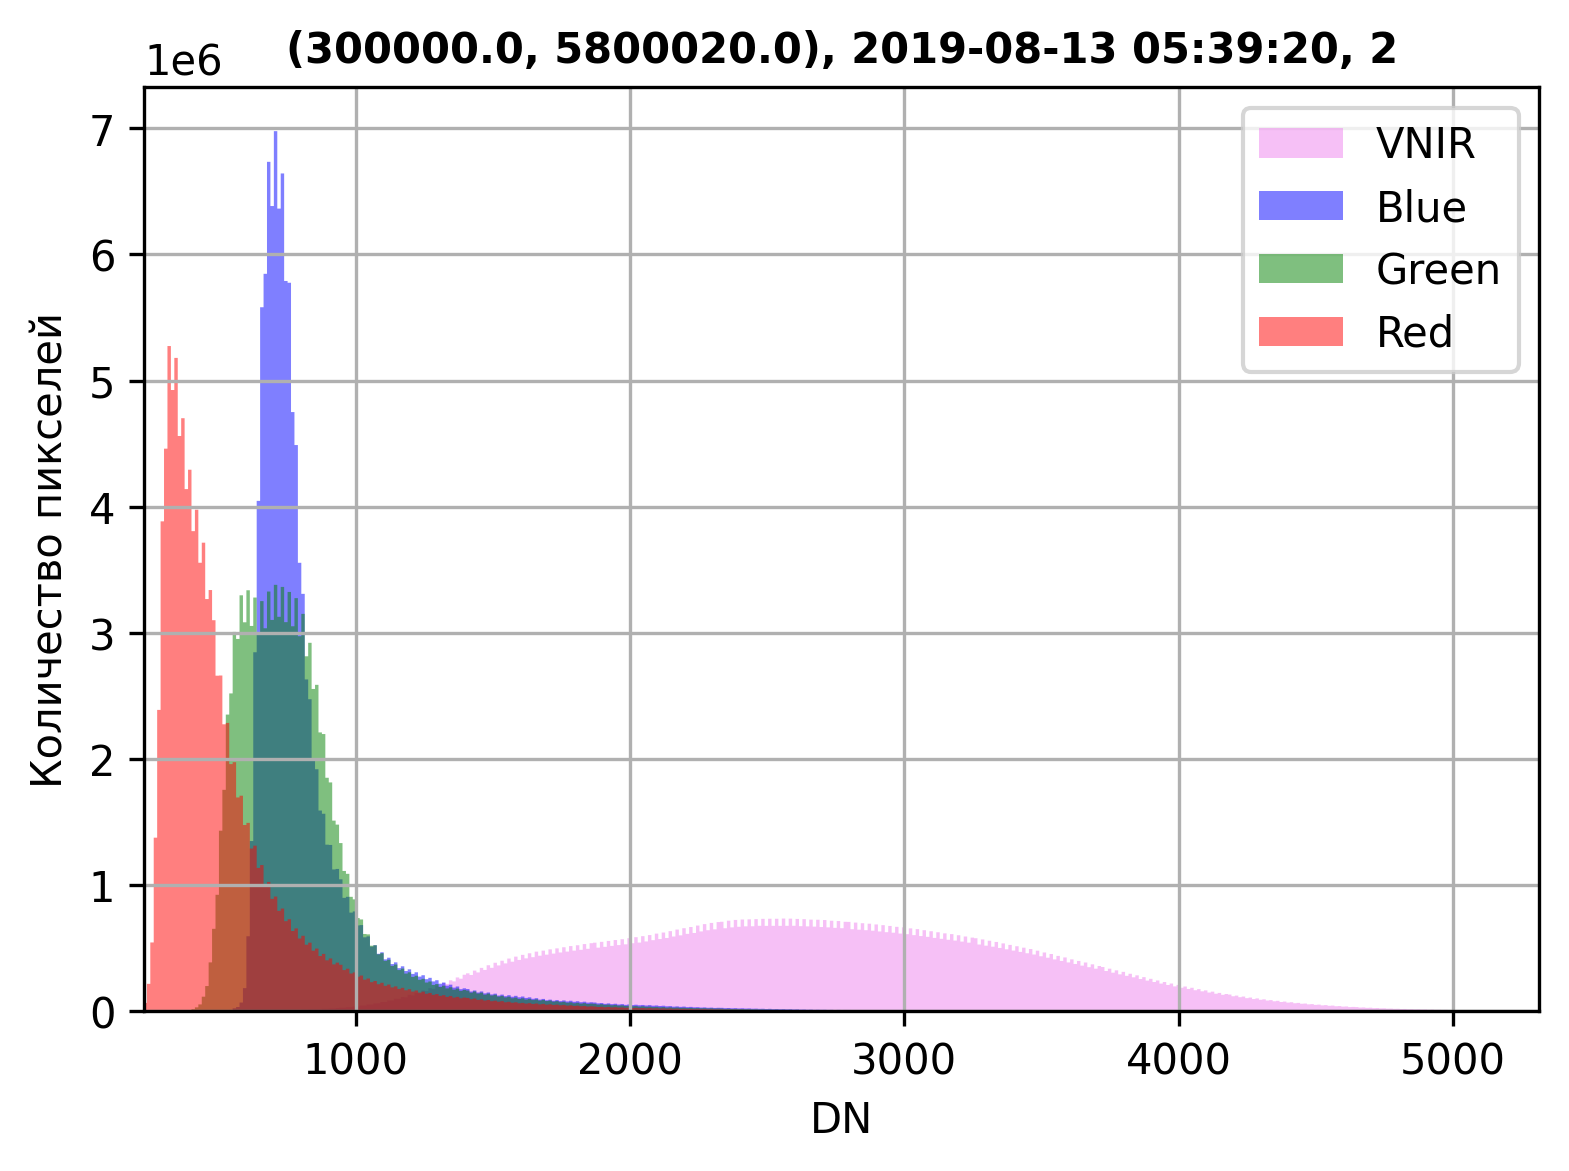

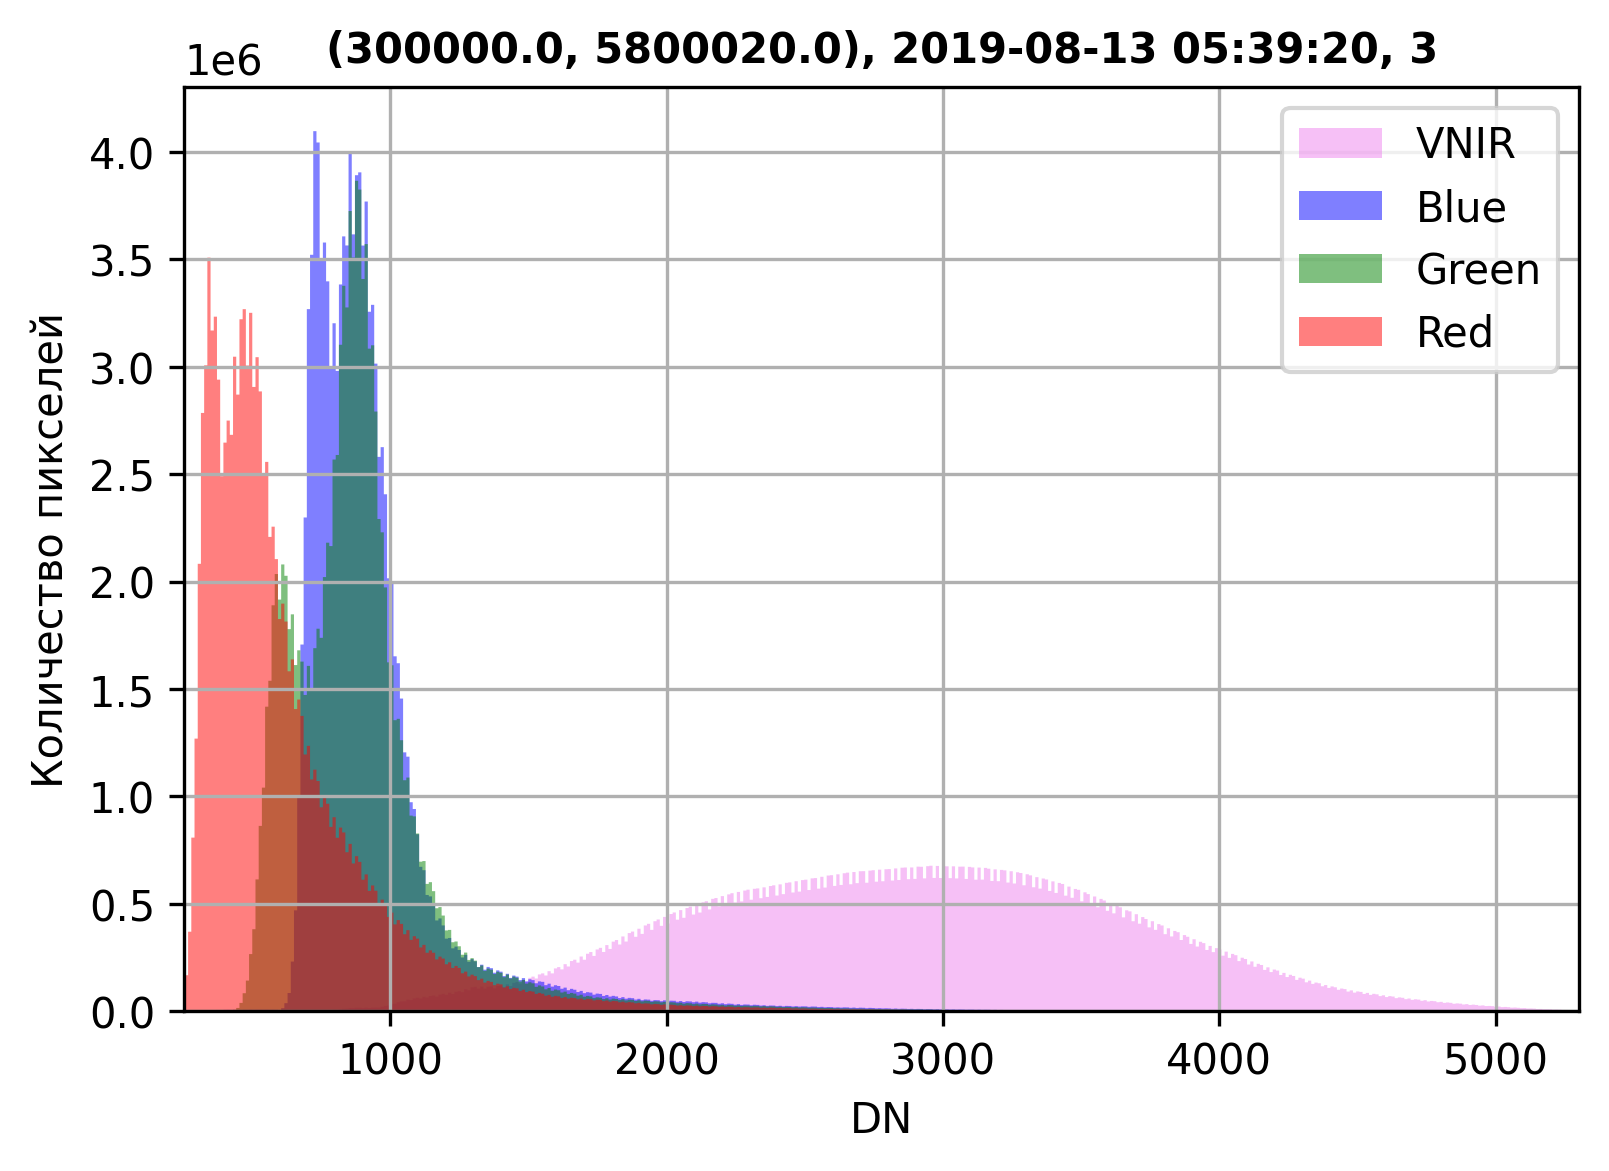

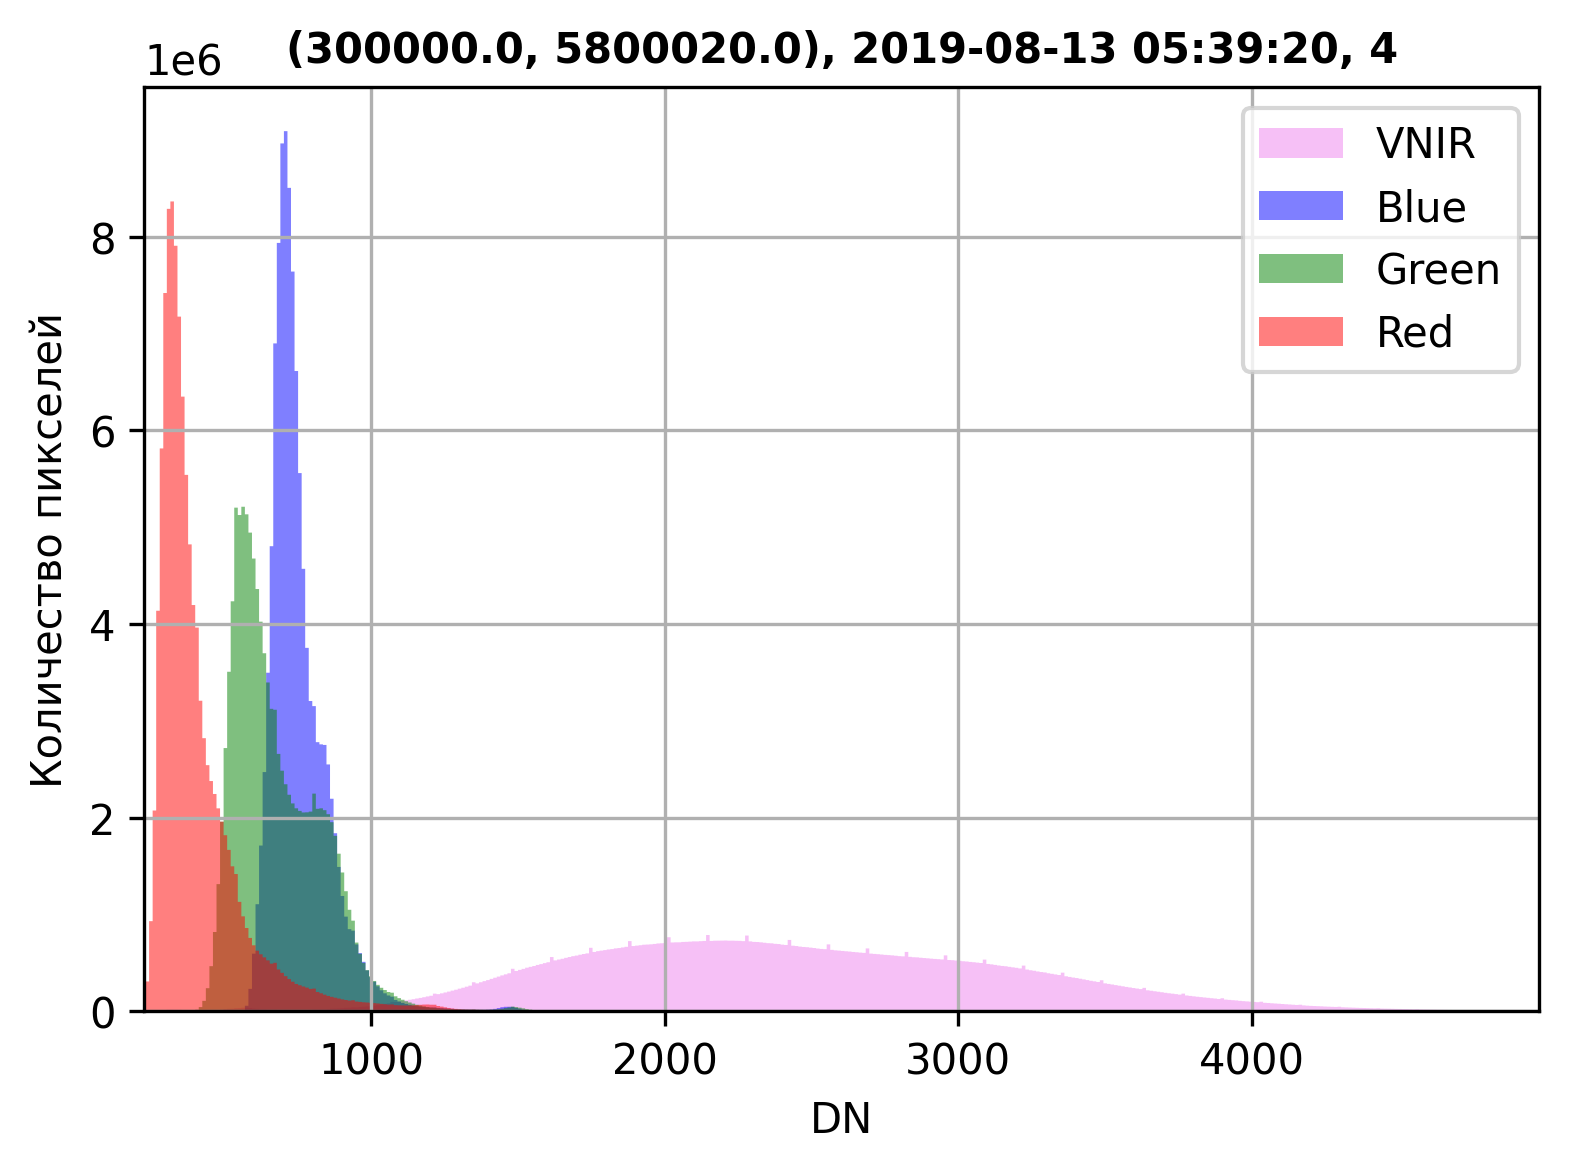

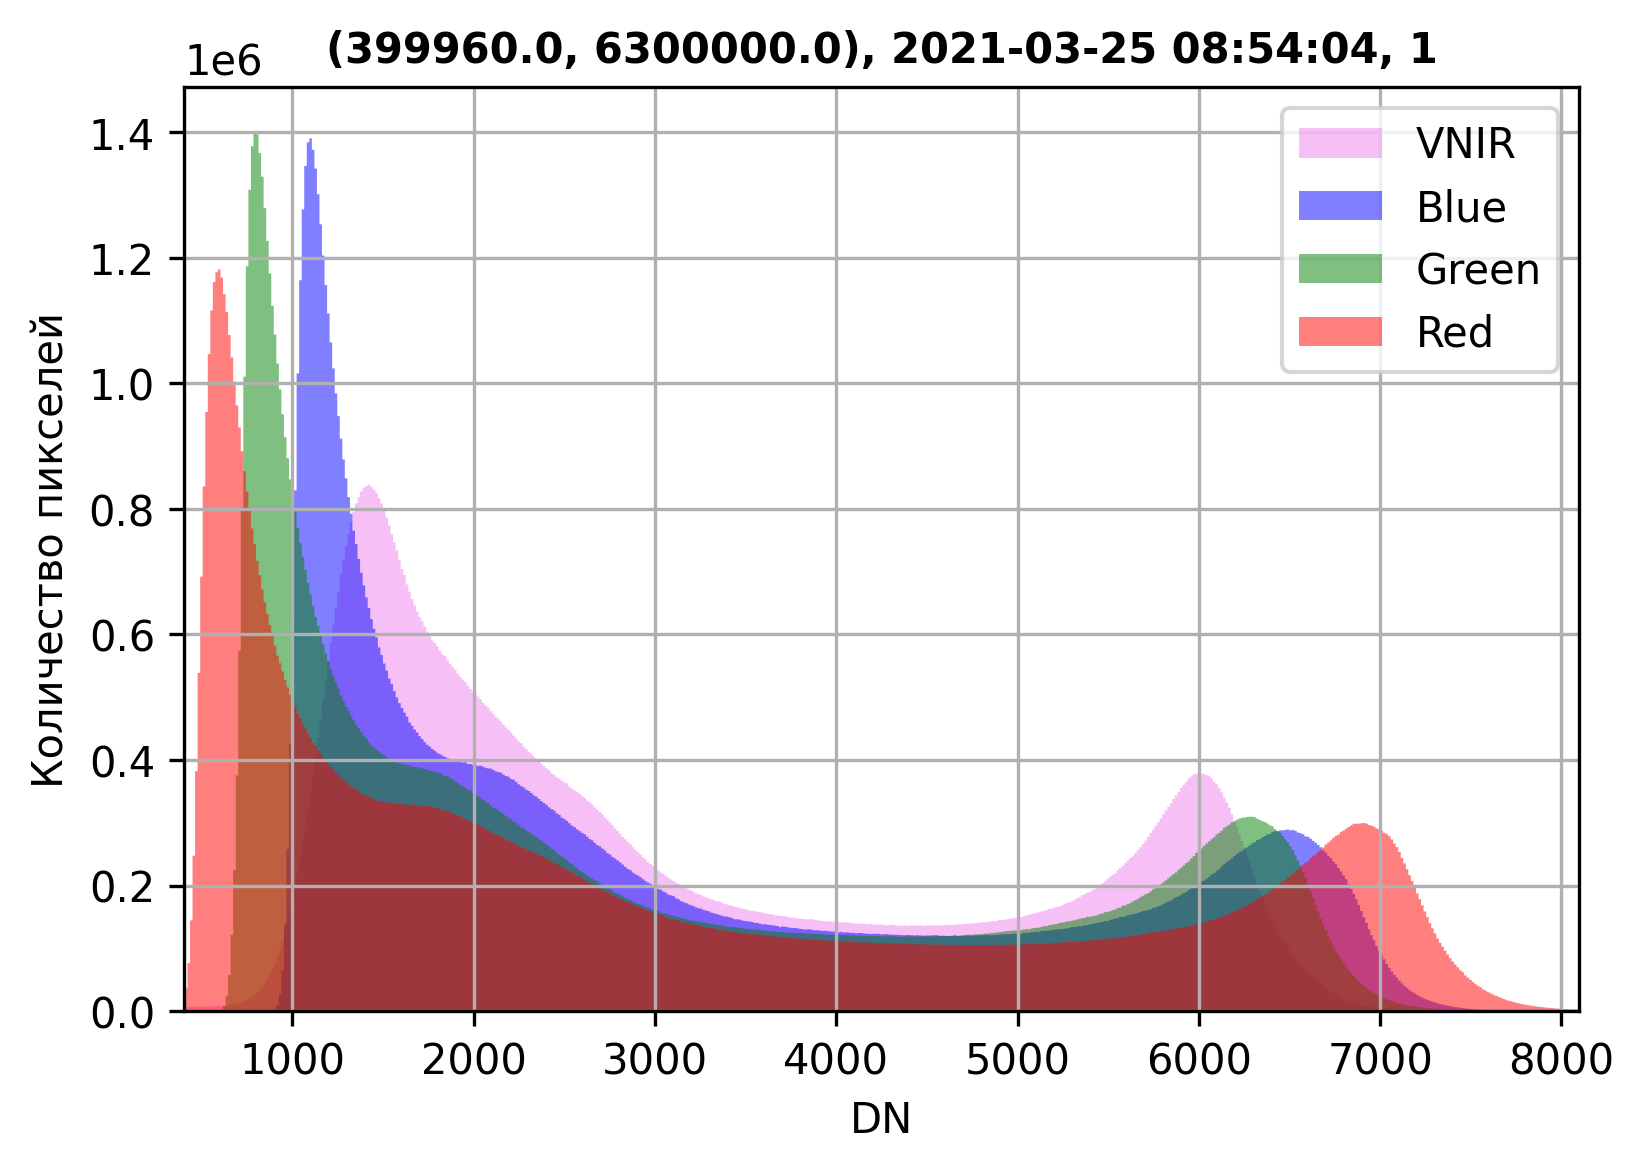

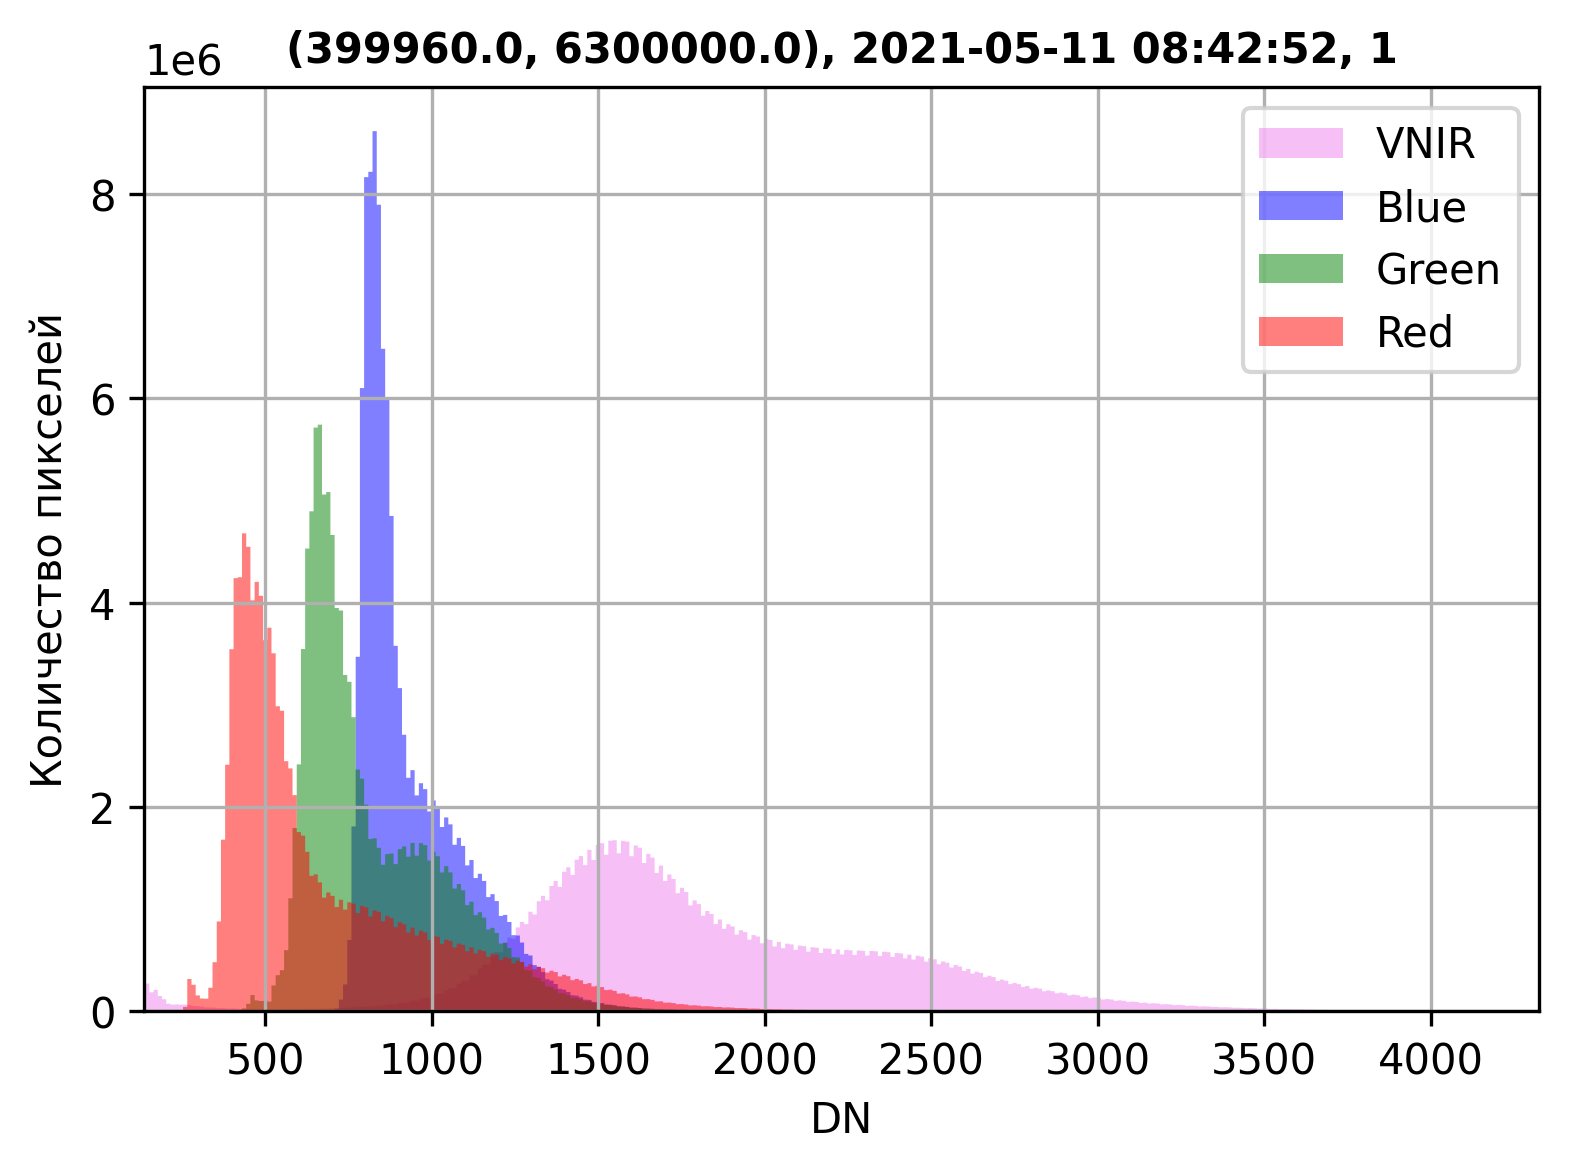

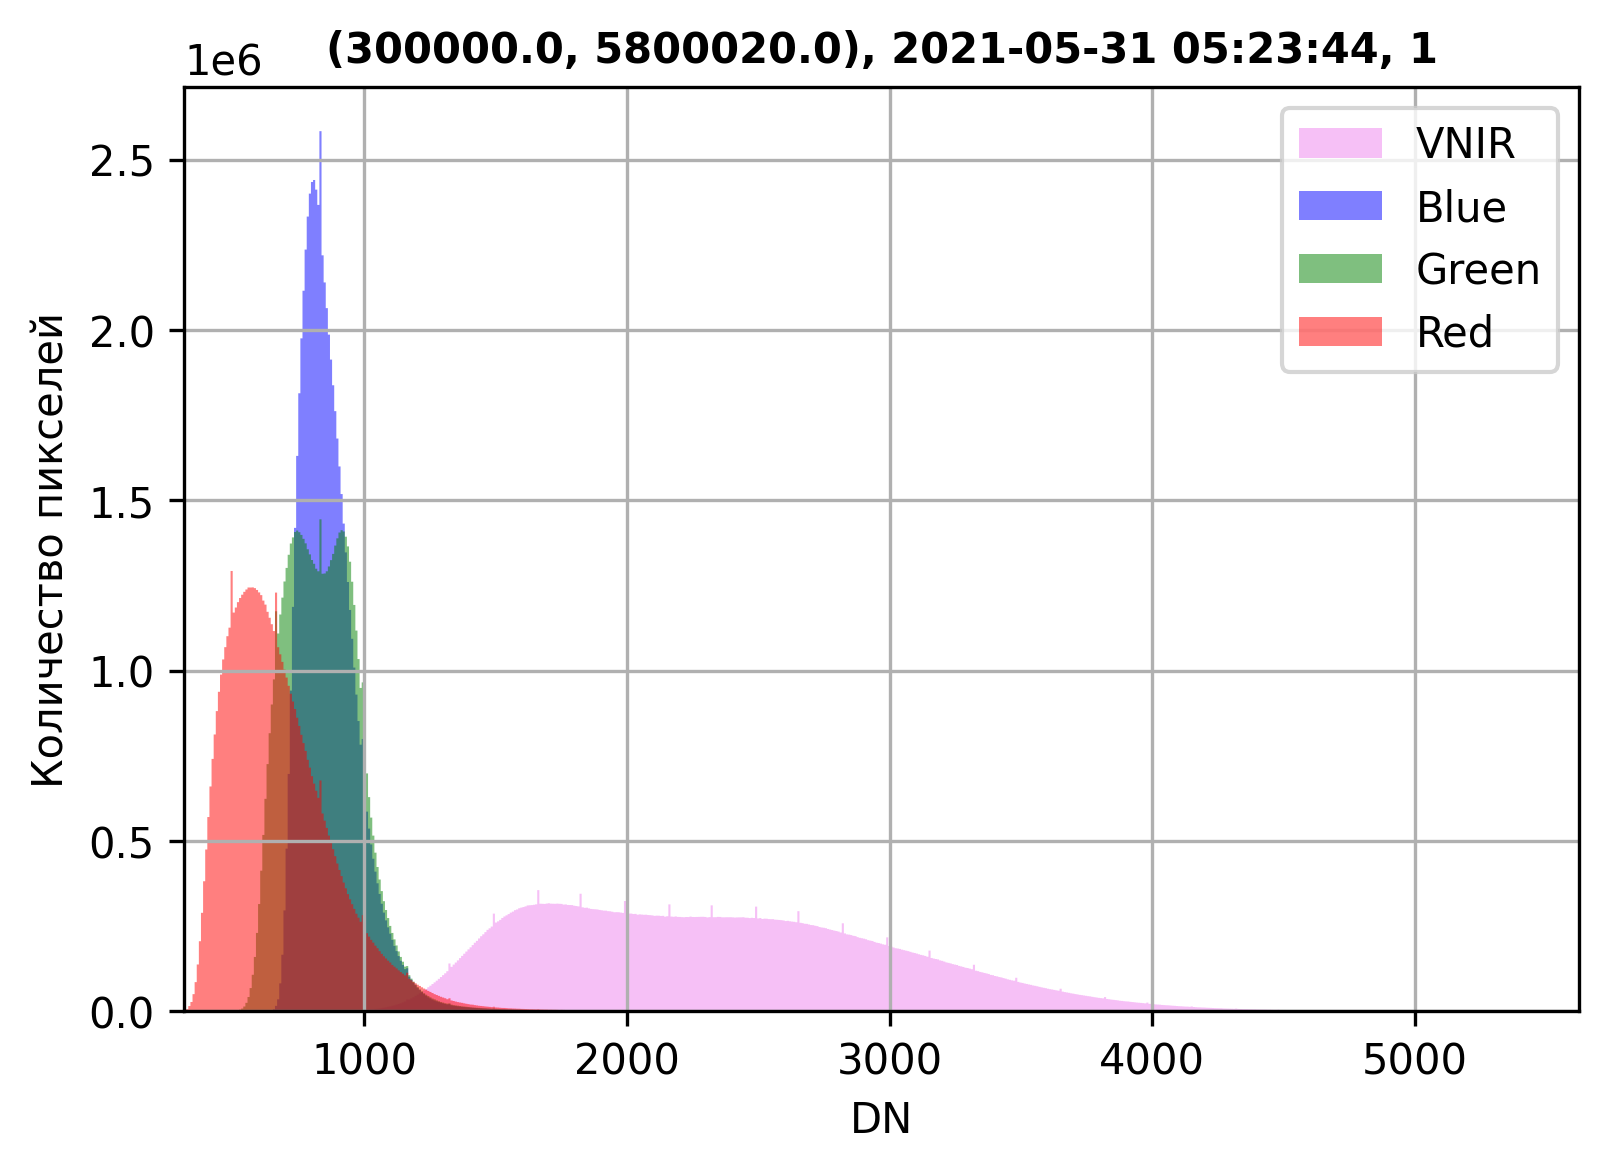

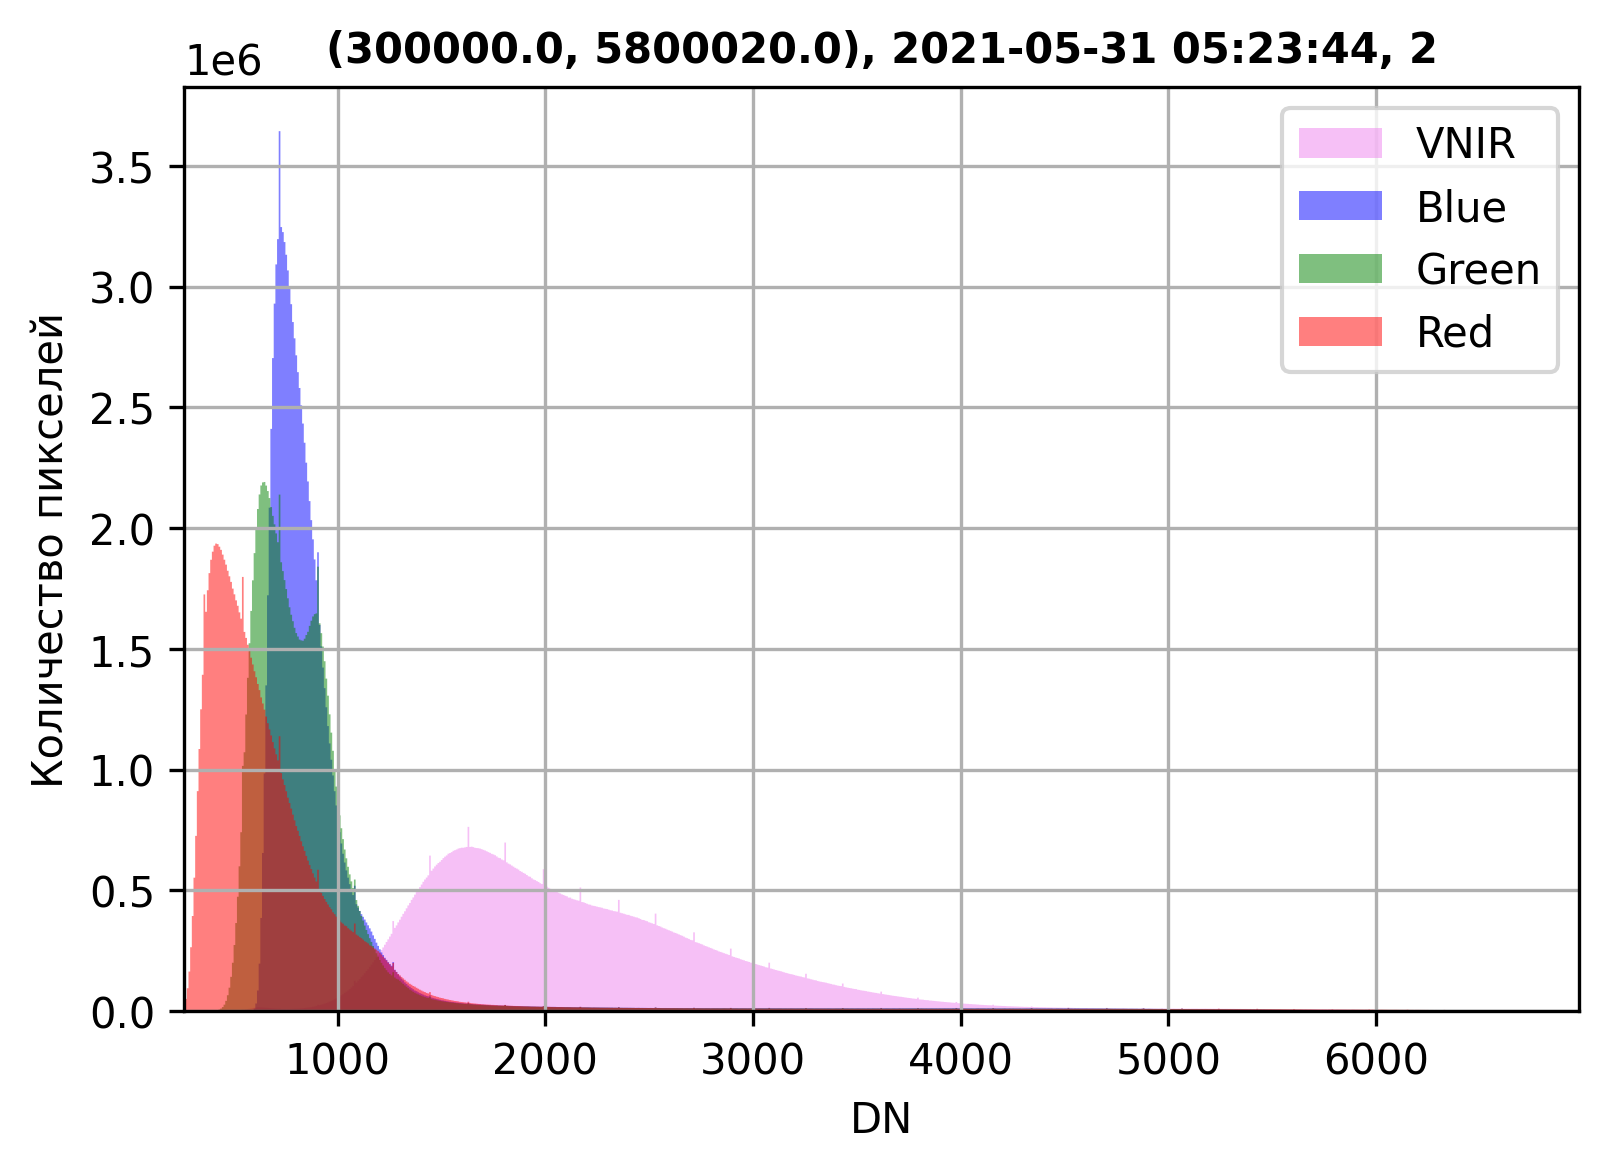

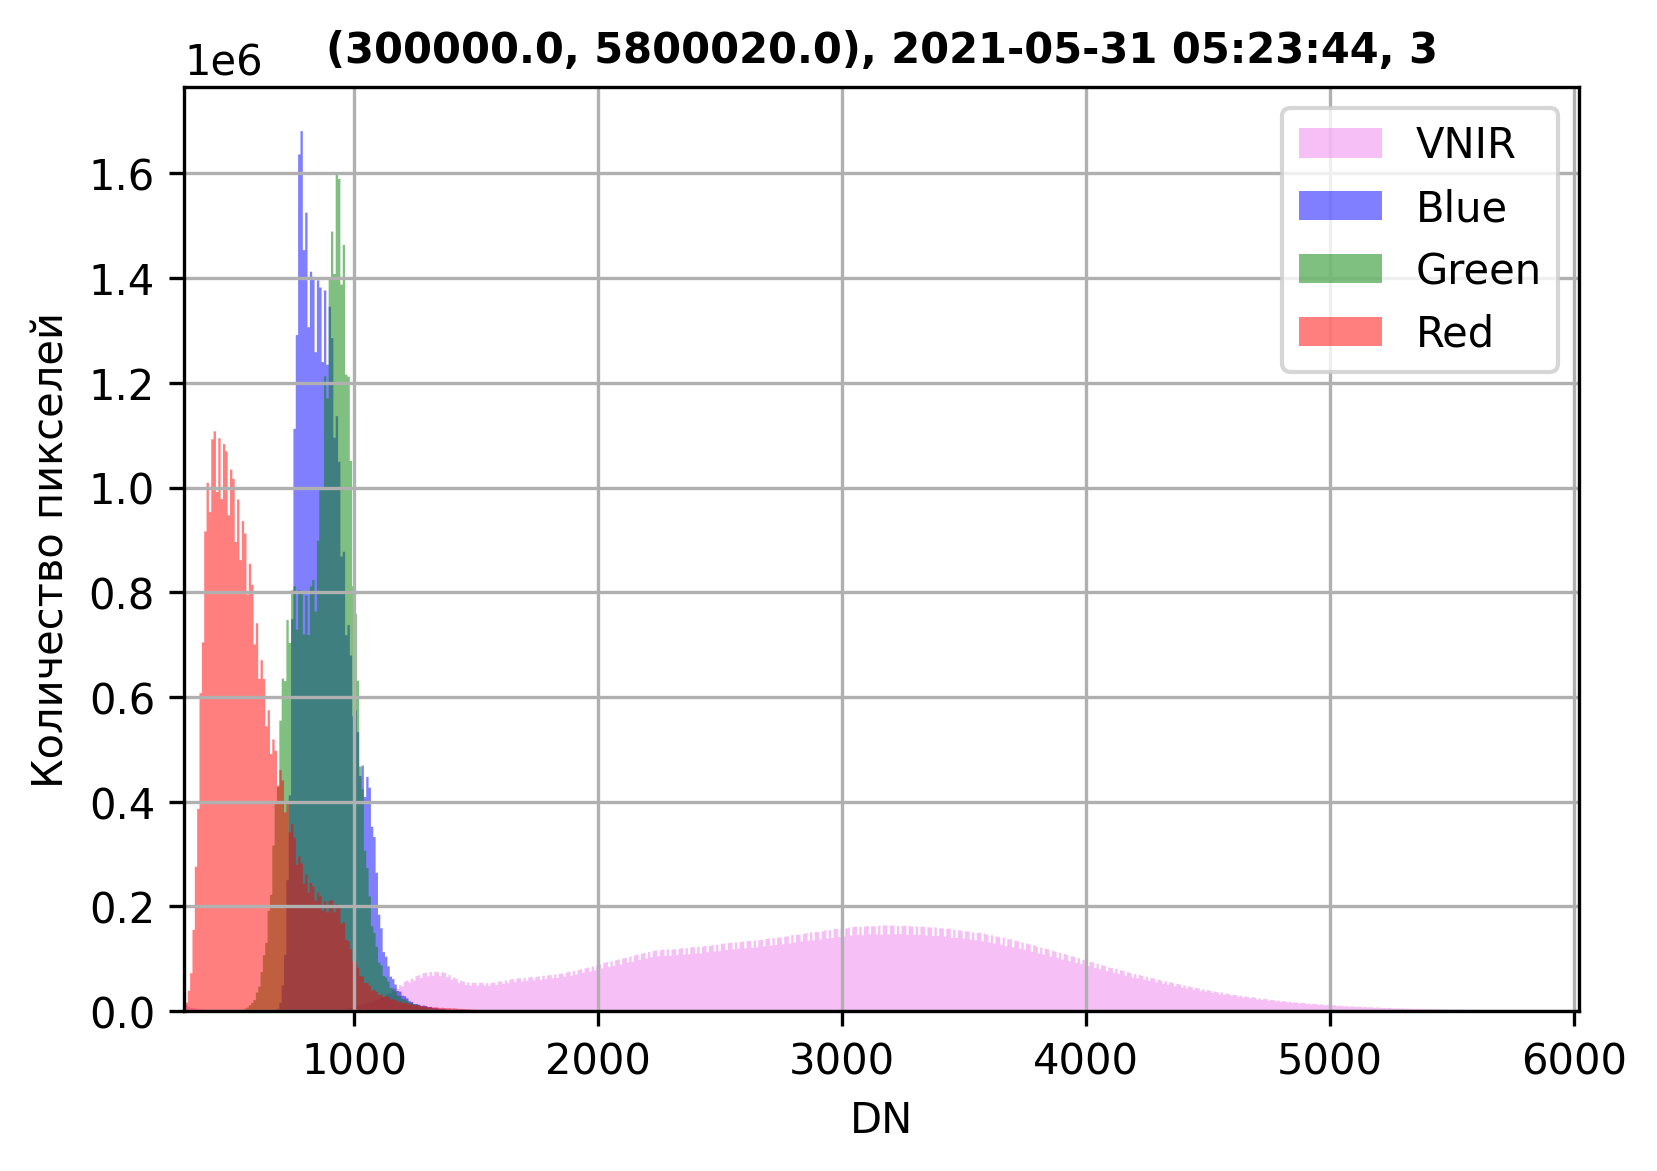

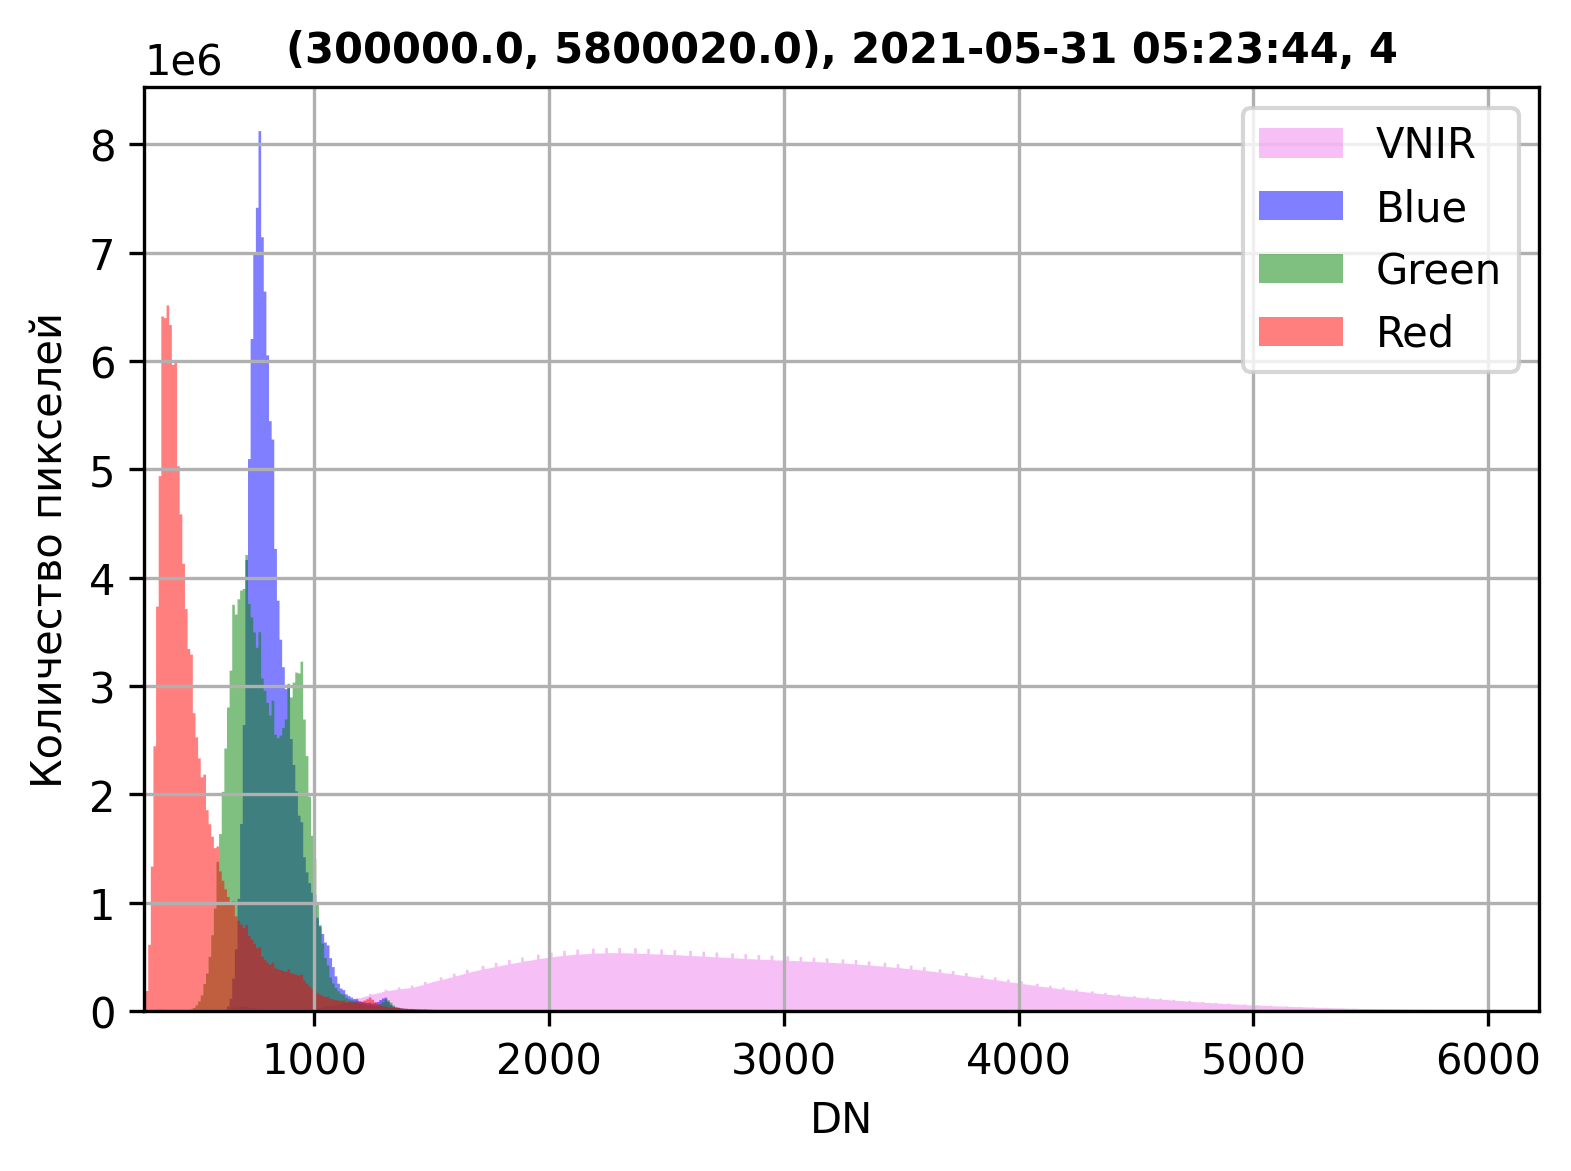

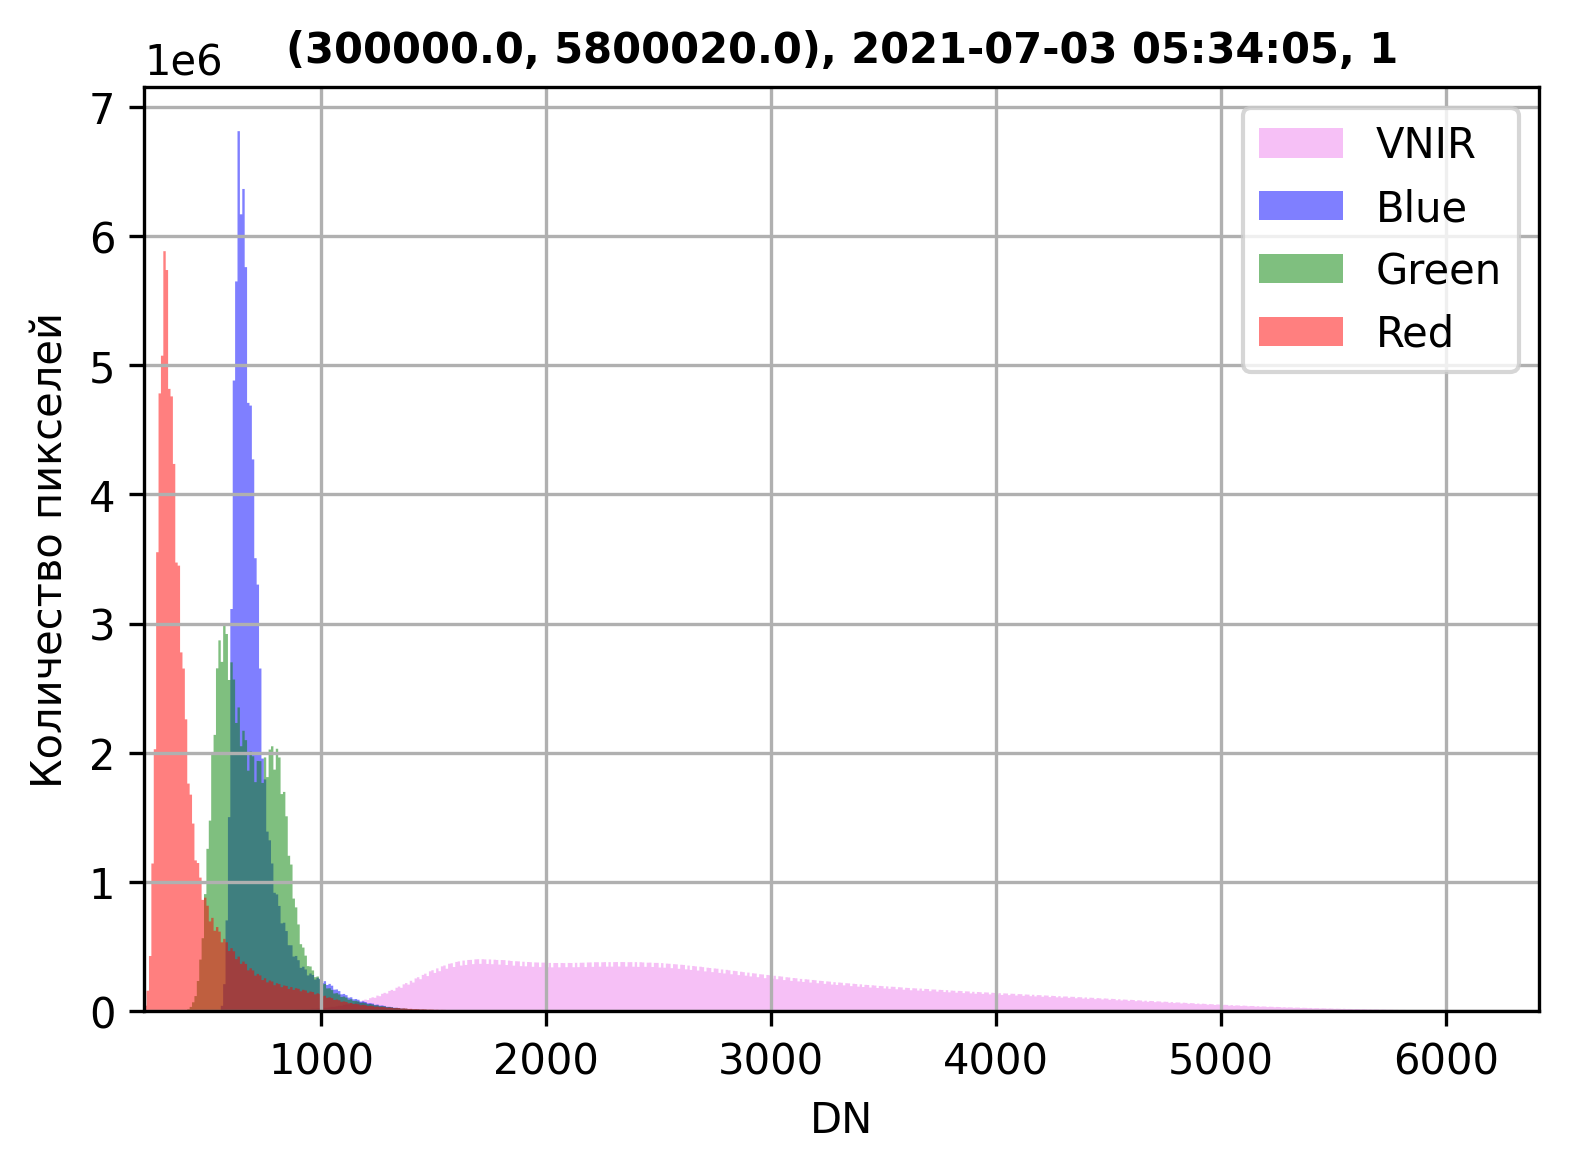

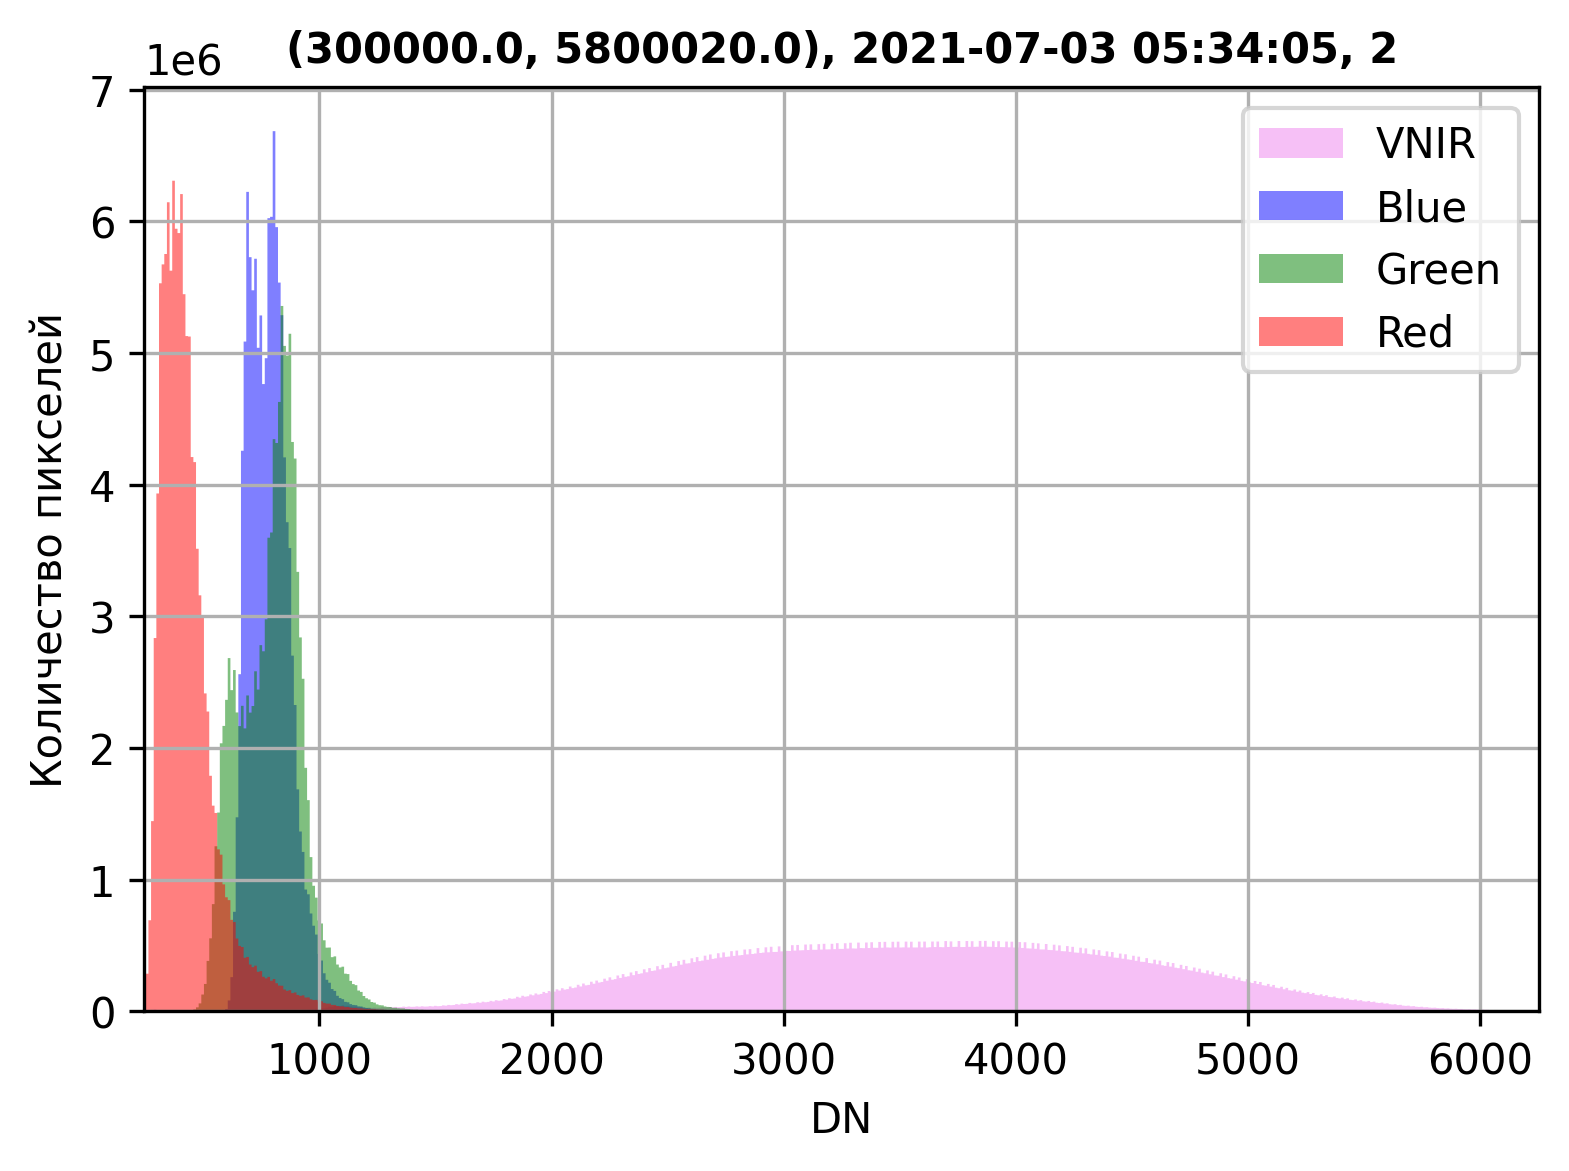

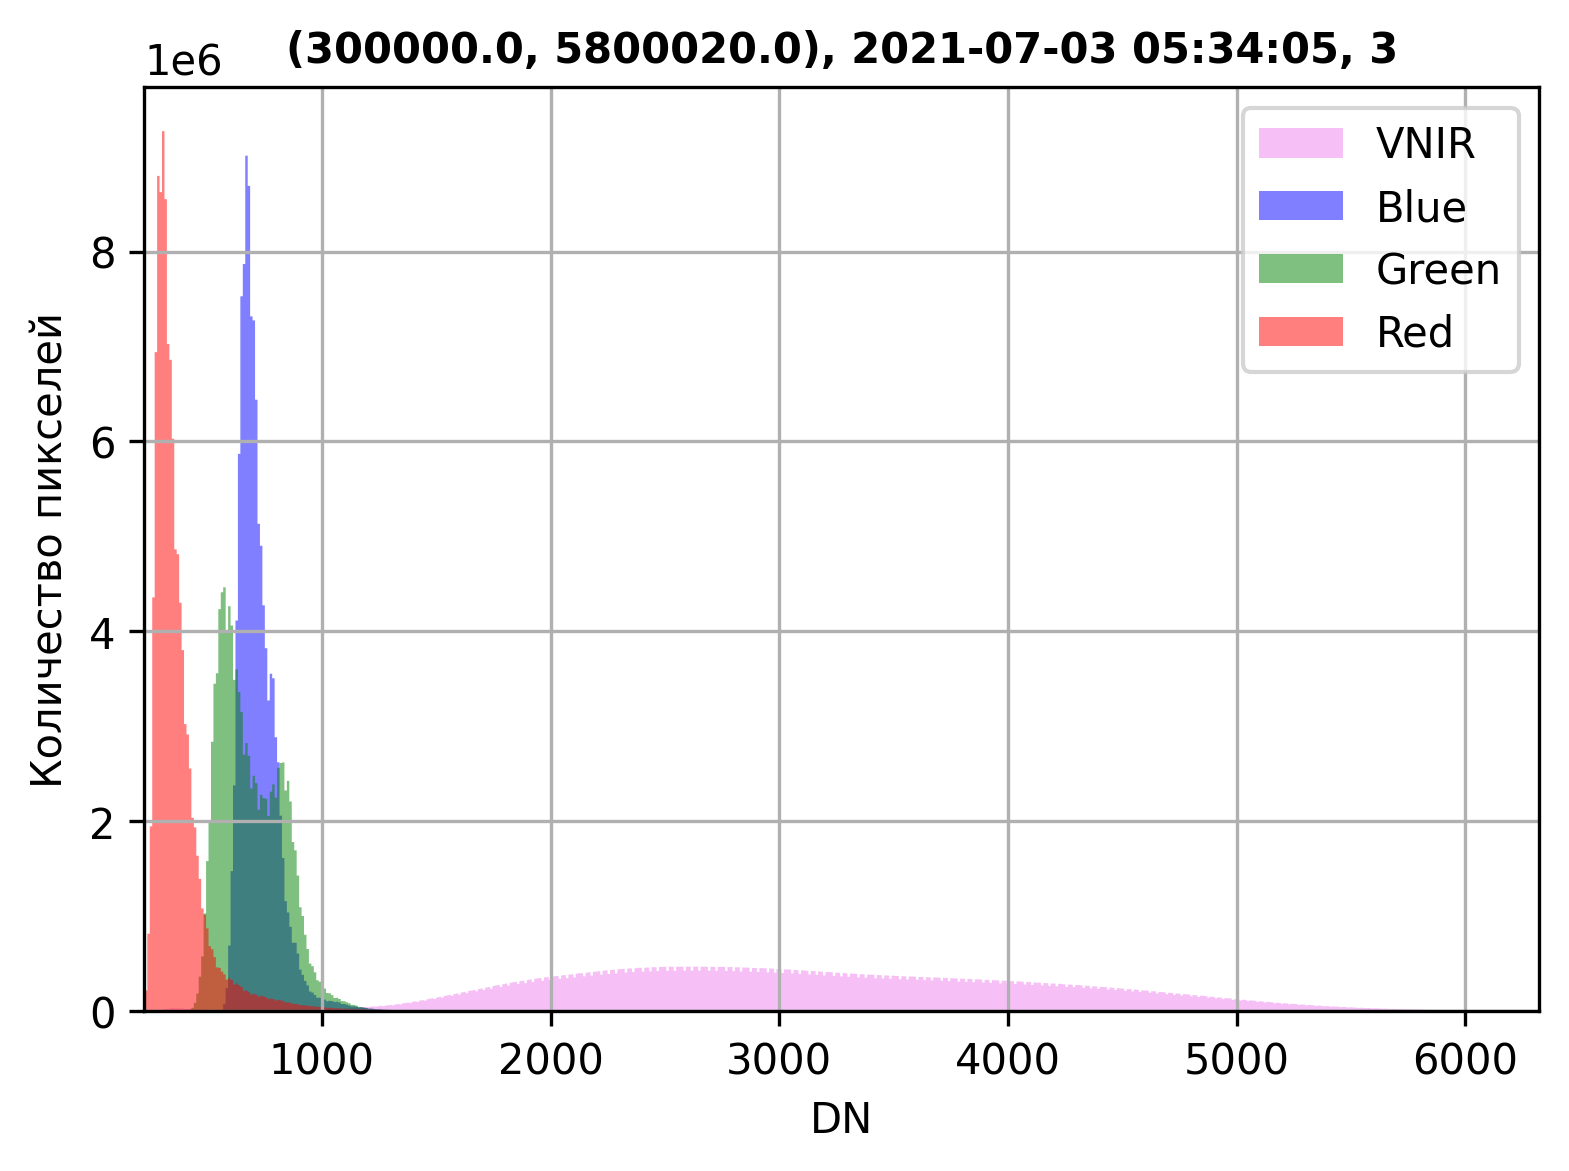

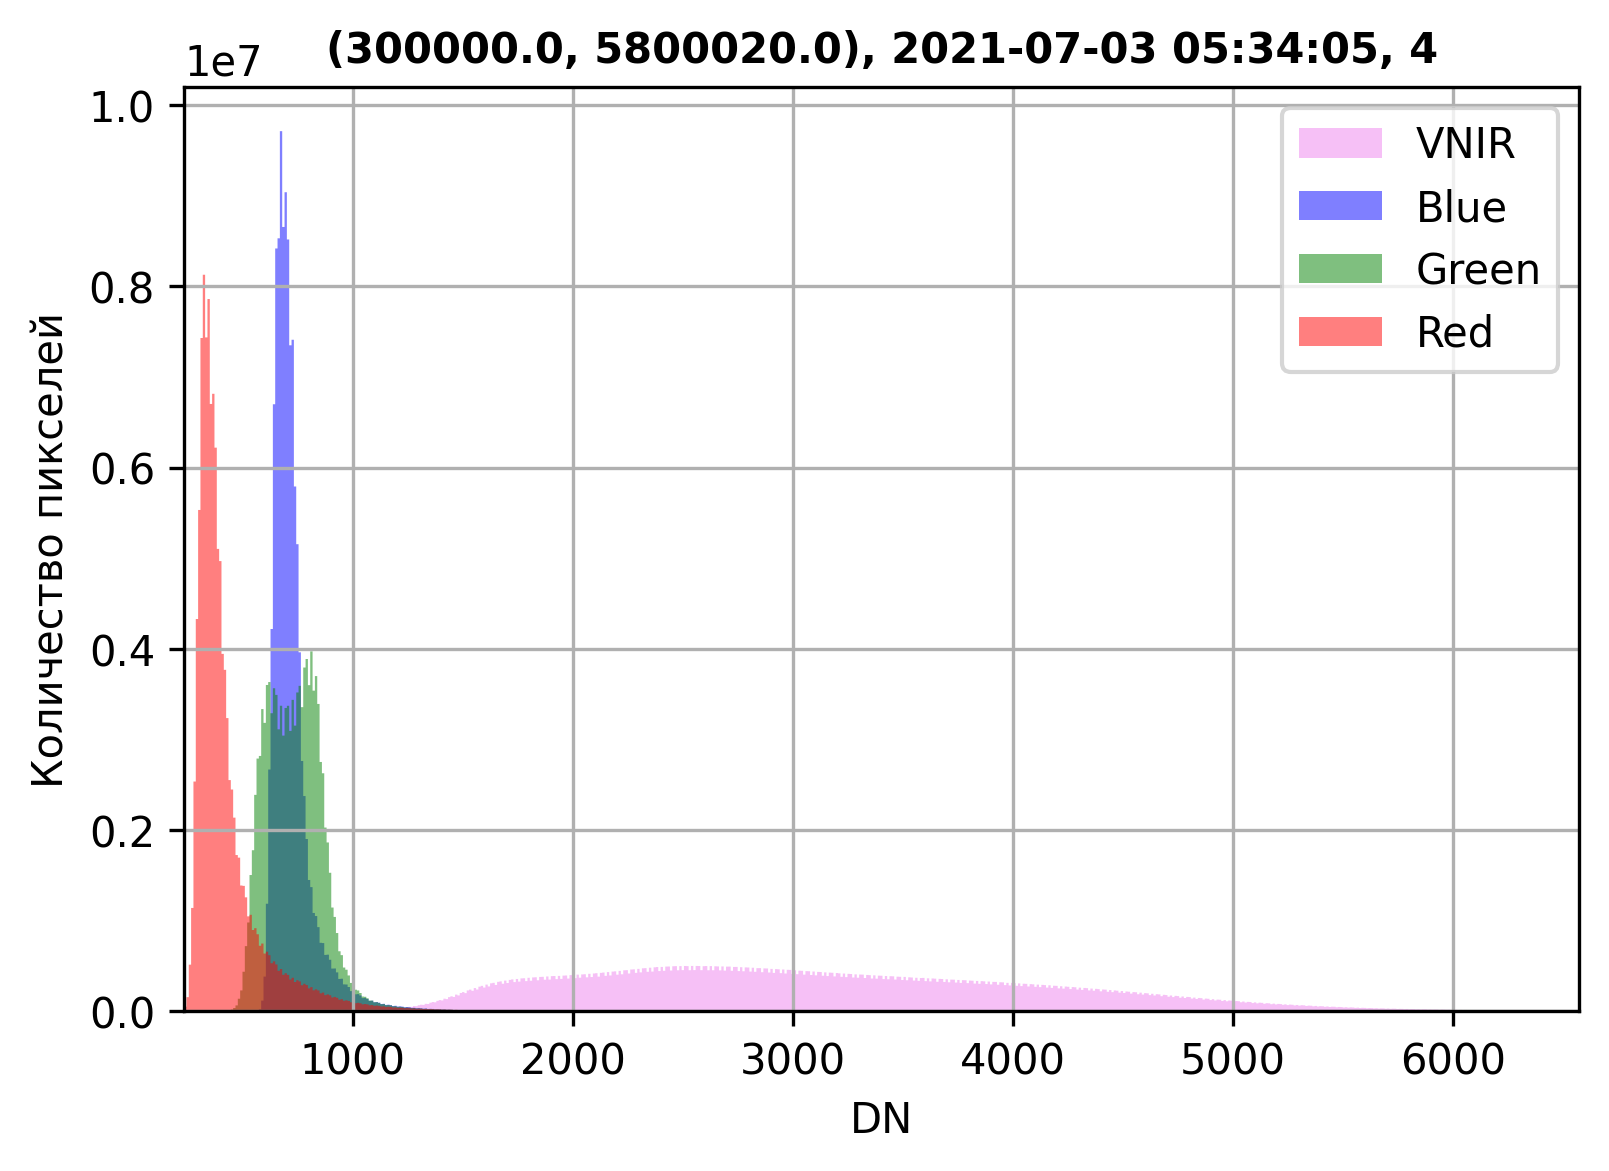

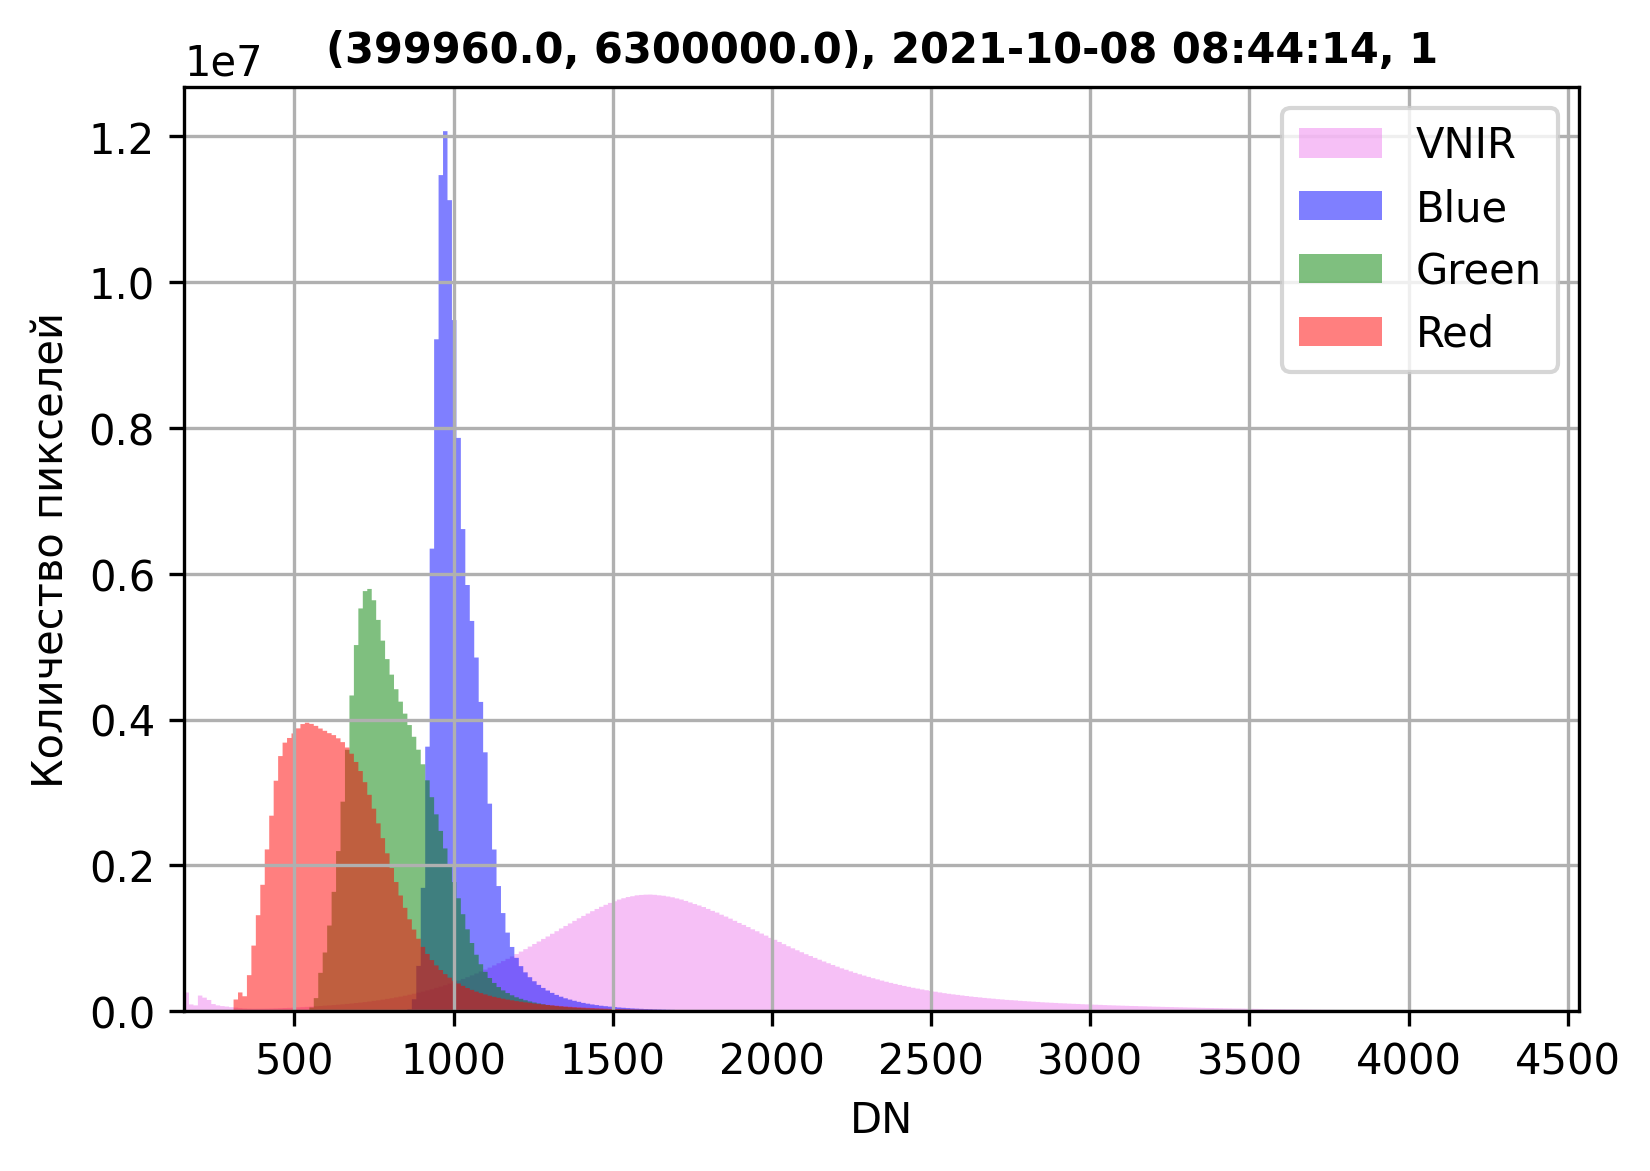

CPU times: total: 16min 3s
Wall time: 18min 50s


In [130]:
%%time

data_dirs = list(info["dirname"])

for data_dir in data_dirs:
    fragment_count = int(info[info["dirname"] == data_dir]["fragment_count"])
    for fragment in range(1, fragment_count + 1):
        data_path = os.path.join(rgbvnir_dir, f"{data_dir}_{fragment}_RGBVNIR.tif")
        data_info = info[info["dirname"] == data_dir]
        x, y = float(data_info["left_x"]), float(data_info["top_y"])
        dt = data_info["datetime"].values[0]
        title = f"({x}, {y}), {dt}, {fragment}"
        with rio.open(data_path) as src_img:
            data = src_img.read(masked=True)
        flat_data = data.compressed()  # https://numpy.org/doc/stable/reference/maskedarray.generic.html#accessing-only-the-valid-entries
        xlim_left = np.quantile(flat_data, 0.0001)
        xlim_right = np.quantile(flat_data, 0.9999)

        plot_path = os.path.join(plots_dir, f"{data_dir}_{fragment}_hist.png")
        fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
        show_hist(
            data, masked=True, bins=2000, ax=ax, histtype="stepfilled", alpha=0.5, label=["Red", "Green", "Blue", "VNIR"]
        )
        ax.set_xlim(xlim_left, xlim_right)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_ylabel("Количество пикселей")
        plt.savefig(plot_path, bbox_inches="tight")
        plt.show()

## 4. Сшивание данных, состоящих из нескольких фрагментов

### Сшивание фрагментов

In [154]:
%%time

bands = [4, 3, 2, 8]  # Red, Green, Blue, VNIR
frag_data_dirs = list(info[info["fragment_count"] > 1]["dirname"])
for data_dir in frag_data_dirs:
    data_path = os.path.join(config.RAW_DATA_DIR, data_dir)
    fragment_count = int(info[info["dirname"] == data_dir]["fragment_count"])
    for band in bands:
        fragments_paths = [
            os.path.join(data_path, f"{data_dir}_channel{band}_{frag}.tif")
            for frag in range(1, fragment_count + 1)
        ]
        mosaic_path = os.path.join(merged_fragments_dir, os.path.basename(fragments_paths[0]))
        utils.merge_fragments(fragments_paths, mosaic_path)

CPU times: total: 3min 42s
Wall time: 5min 34s


### Копирование сшитых файлов и файлов, не требовавших сшивания, в единую директорию

In [165]:
merged_filenames = os.listdir(merged_fragments_dir)
for filename in merged_filenames:
    src_path = os.path.join(merged_fragments_dir, filename)
    dst_path = os.path.join(prepared_rgbvnir_dir, filename)
    shutil.copy(src_path, dst_path)

In [168]:
data_dirs = list(info[info["fragment_count"] == 1]["dirname"])
bands = [4, 3, 2, 8]  # Red, Green, Blue, VNIR

for data_dir in data_dirs:
    data_path = os.path.join(config.RAW_DATA_DIR, data_dir)
    for band in bands:
        filename = f"{data_dir}_channel{band}_1.tif"
        src_path = os.path.join(data_path, filename)
        dst_path = os.path.join(prepared_rgbvnir_dir, filename)
        shutil.copy(src_path, dst_path)

## 5. Формирование RGB-композитов

In [171]:
%%time

bands = [4, 3, 2]  # Red, Green, Blue
data_dirs = list(info["dirname"])
for data_dir in data_dirs:
    bands_paths = [os.path.join(prepared_rgbvnir_dir, f"{data_dir}_channel{band}_1.tif") for band in bands]
    rgb_path = os.path.join(combined_rgb_dir, f"{data_dir}_1_RGB.tif")
    utils.combine_bands(bands_paths, rgb_path)

CPU times: total: 1min 12s
Wall time: 9min 15s


## 6. Визуализация данных 10-метровых каналов

### Формирование RGBVNIR-композитов для быстрого вывода гистограмм с помощью rasterio

In [173]:
%%time

bands = [4, 3, 2, 8]  # Red, Green, Blue, VNIR
data_dirs = list(info["dirname"])
for data_dir in data_dirs:
    bands_paths = [os.path.join(prepared_rgbvnir_dir, f"{data_dir}_channel{band}_1.tif") for band in bands]
    rgbvnir_path = os.path.join(combined_rgbvnir_dir, f"{data_dir}_1_RGBVNIR.tif")
    utils.combine_bands(bands_paths, rgbvnir_path)

CPU times: total: 1min 45s
Wall time: 15min 13s


### Гистограммы

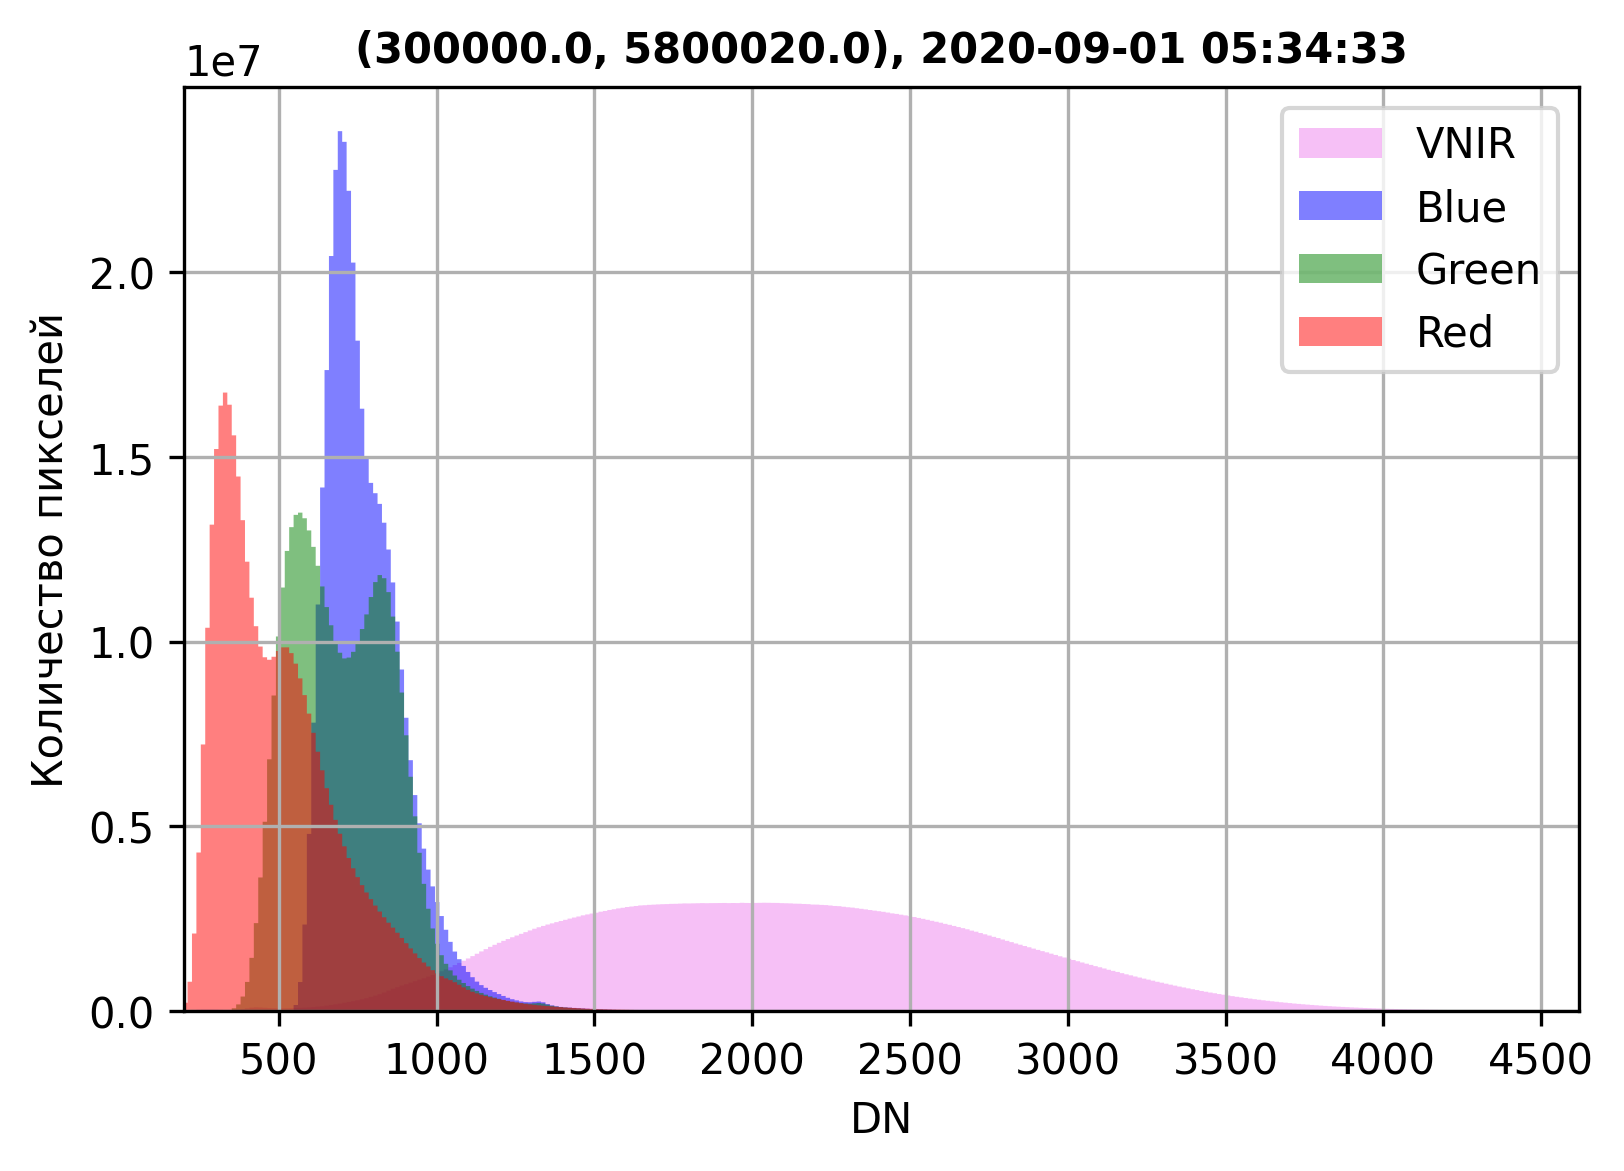

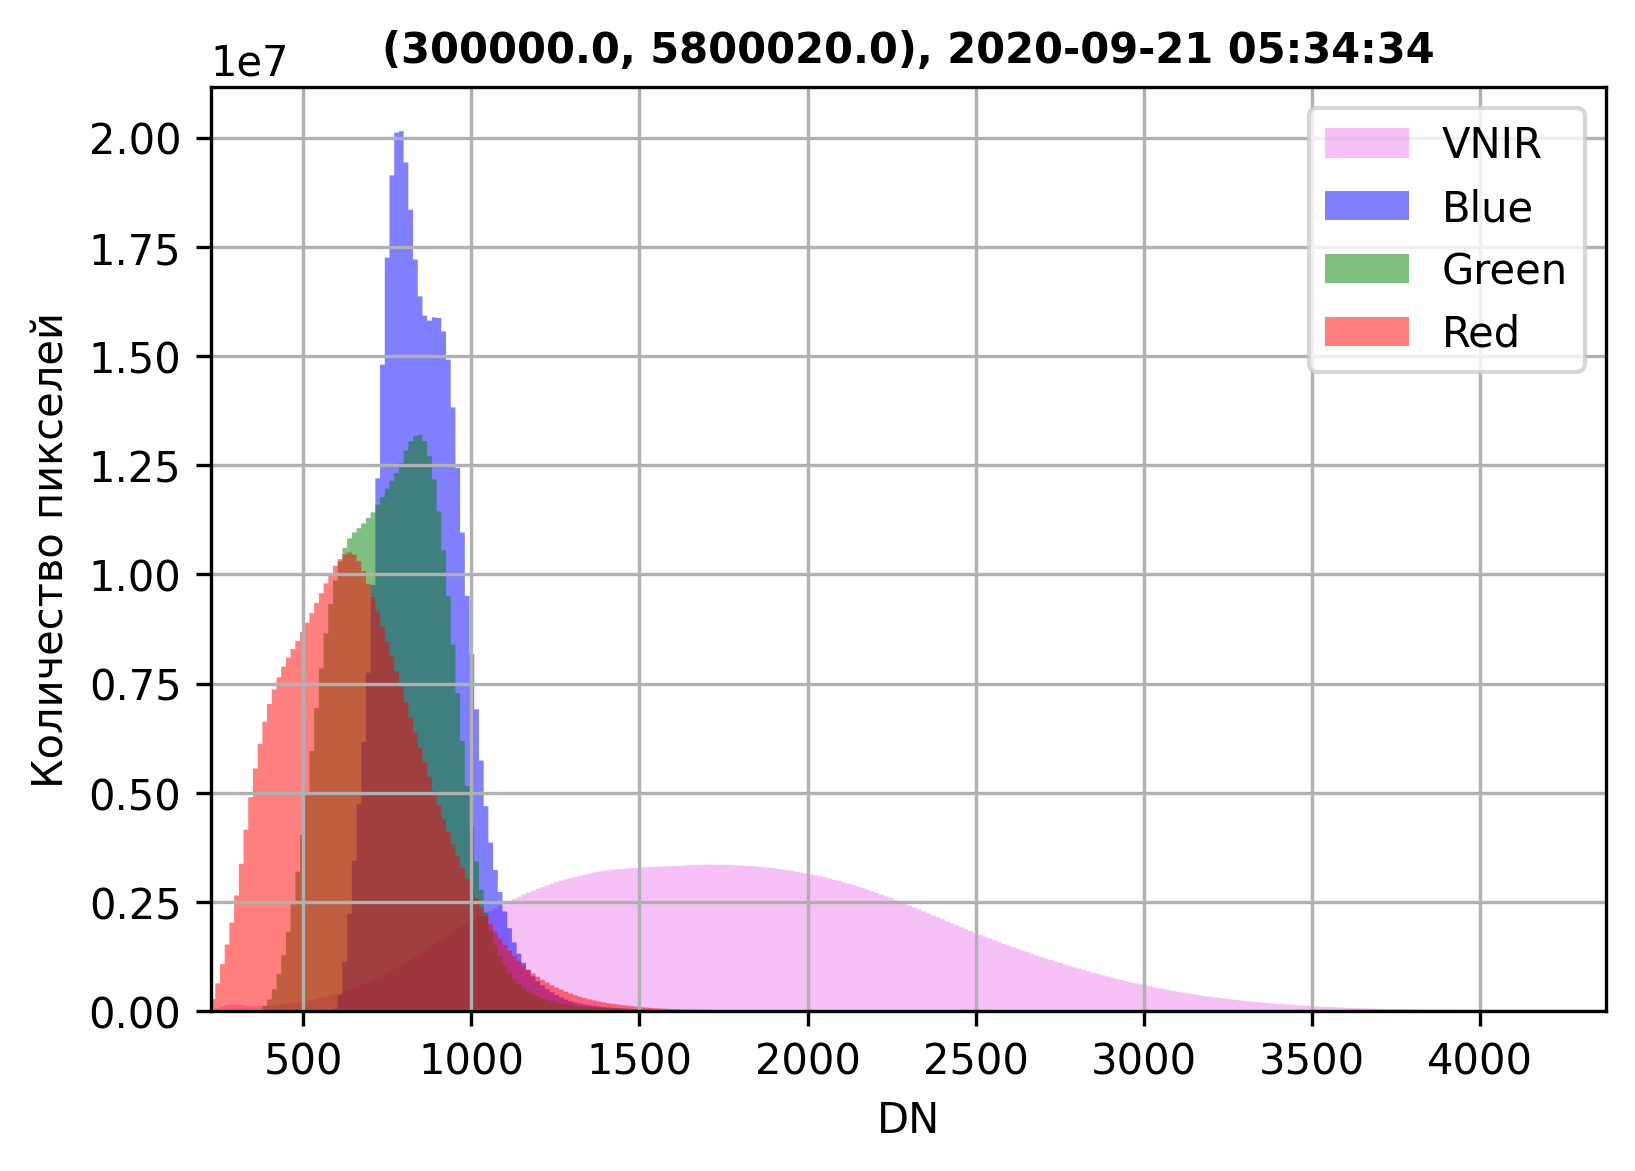

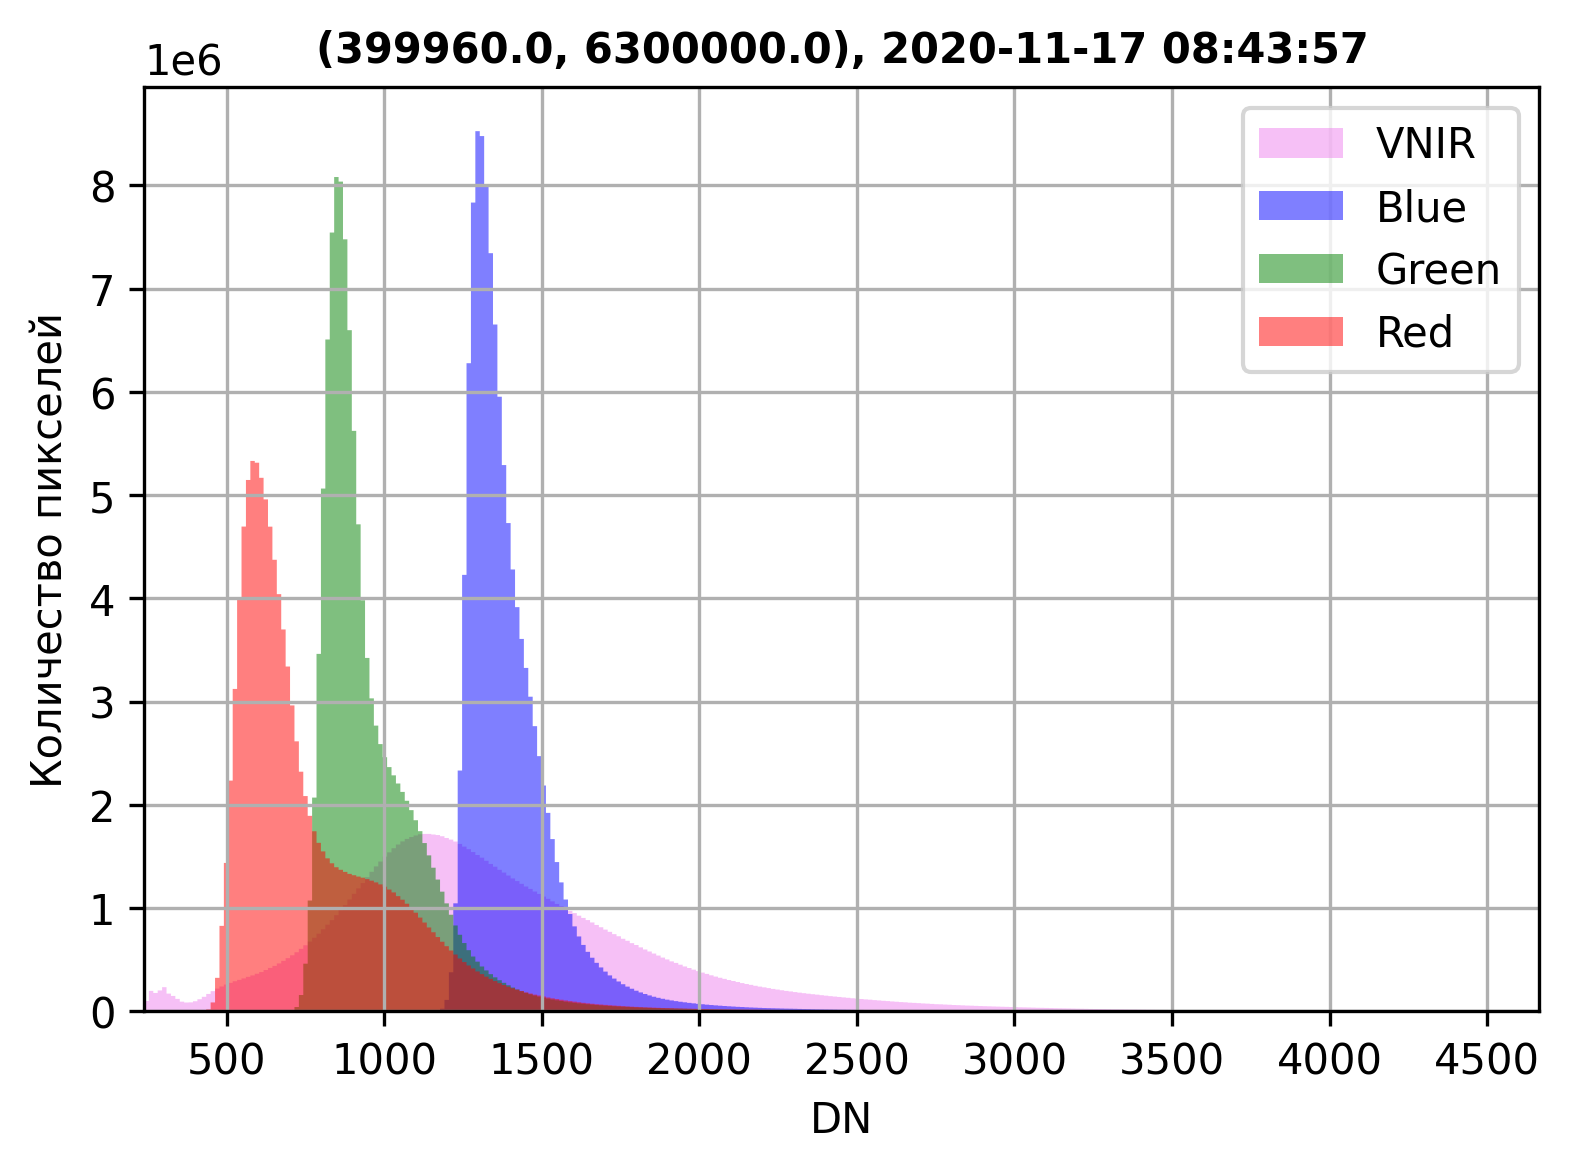

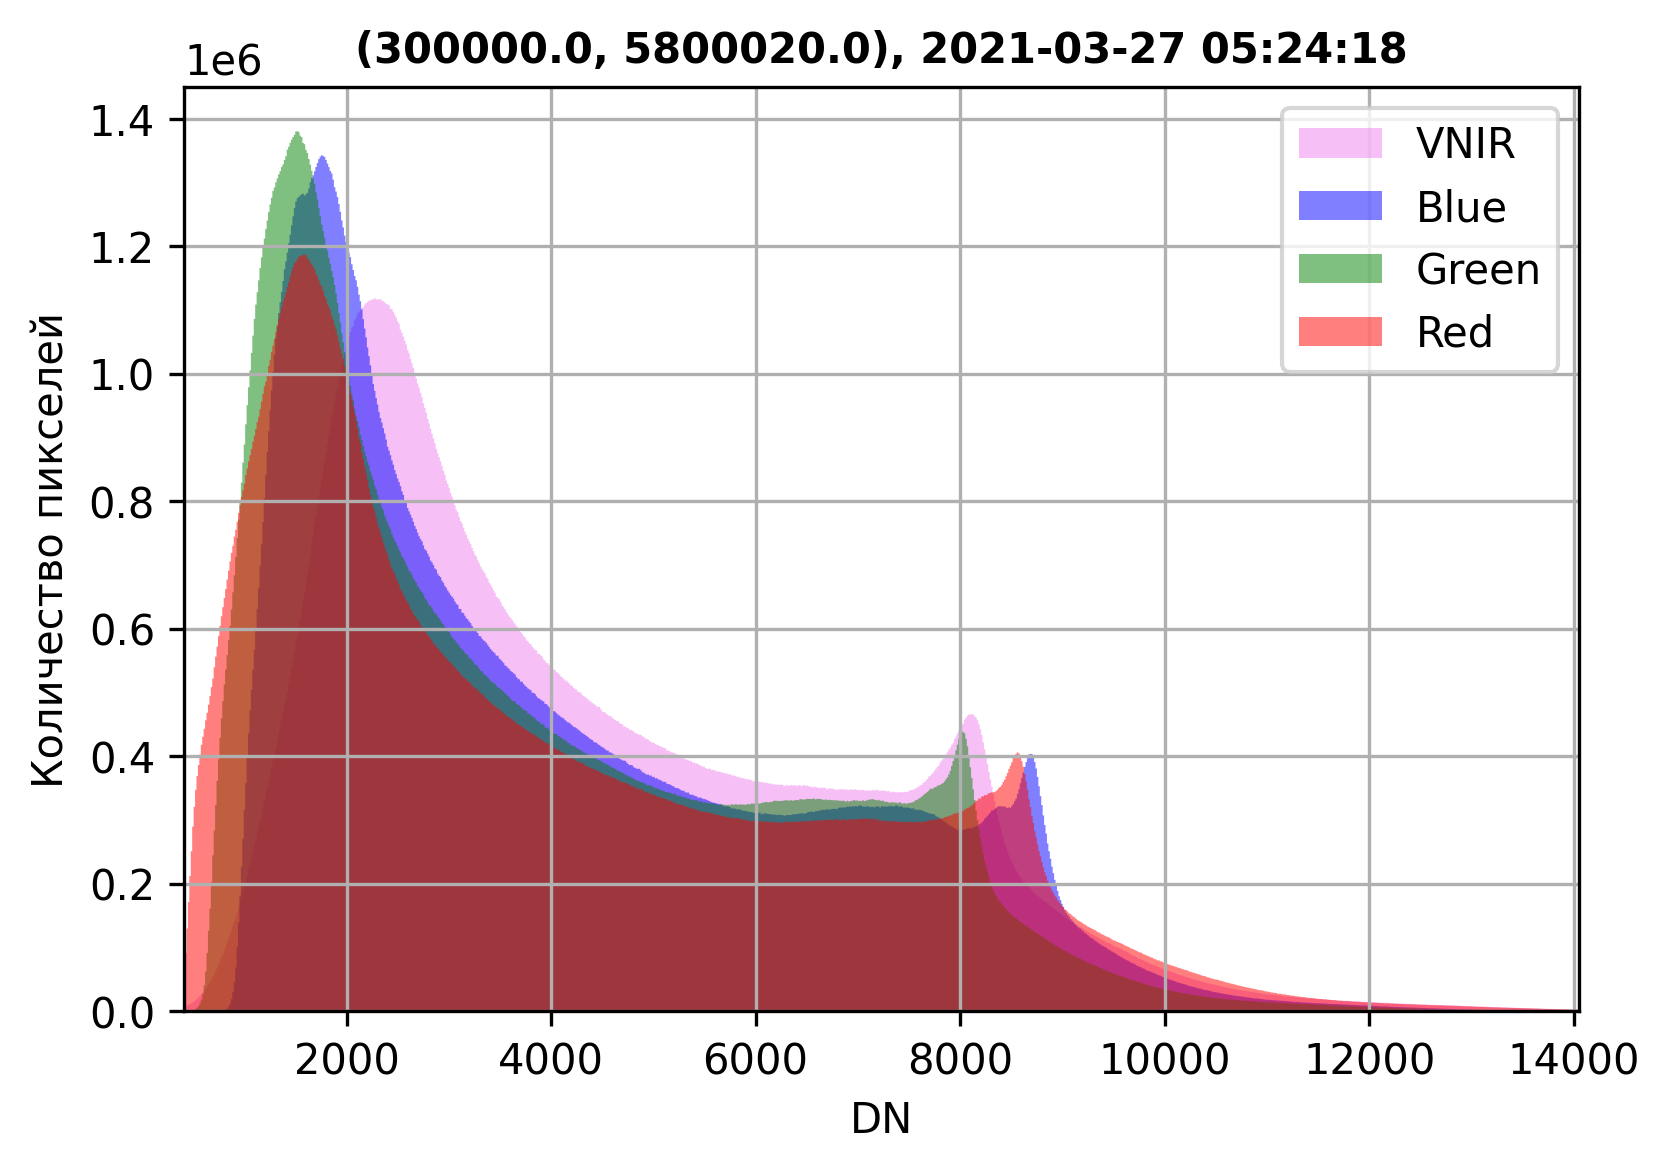

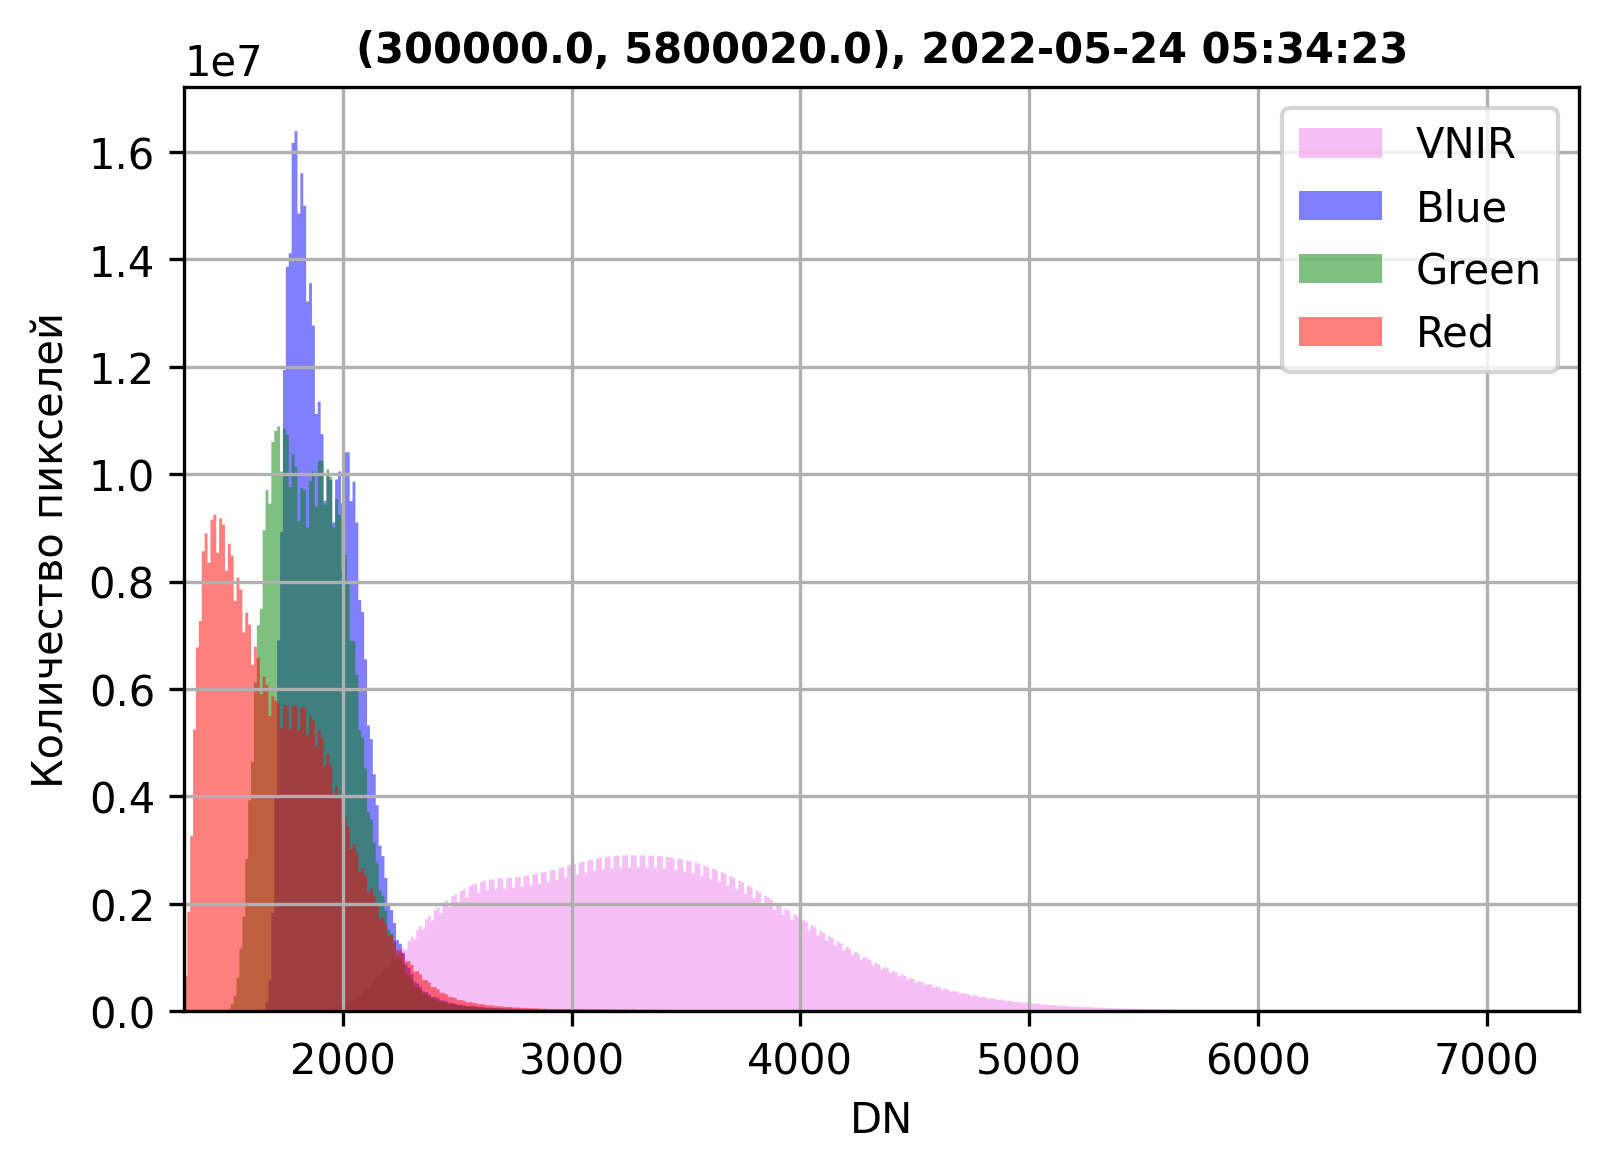

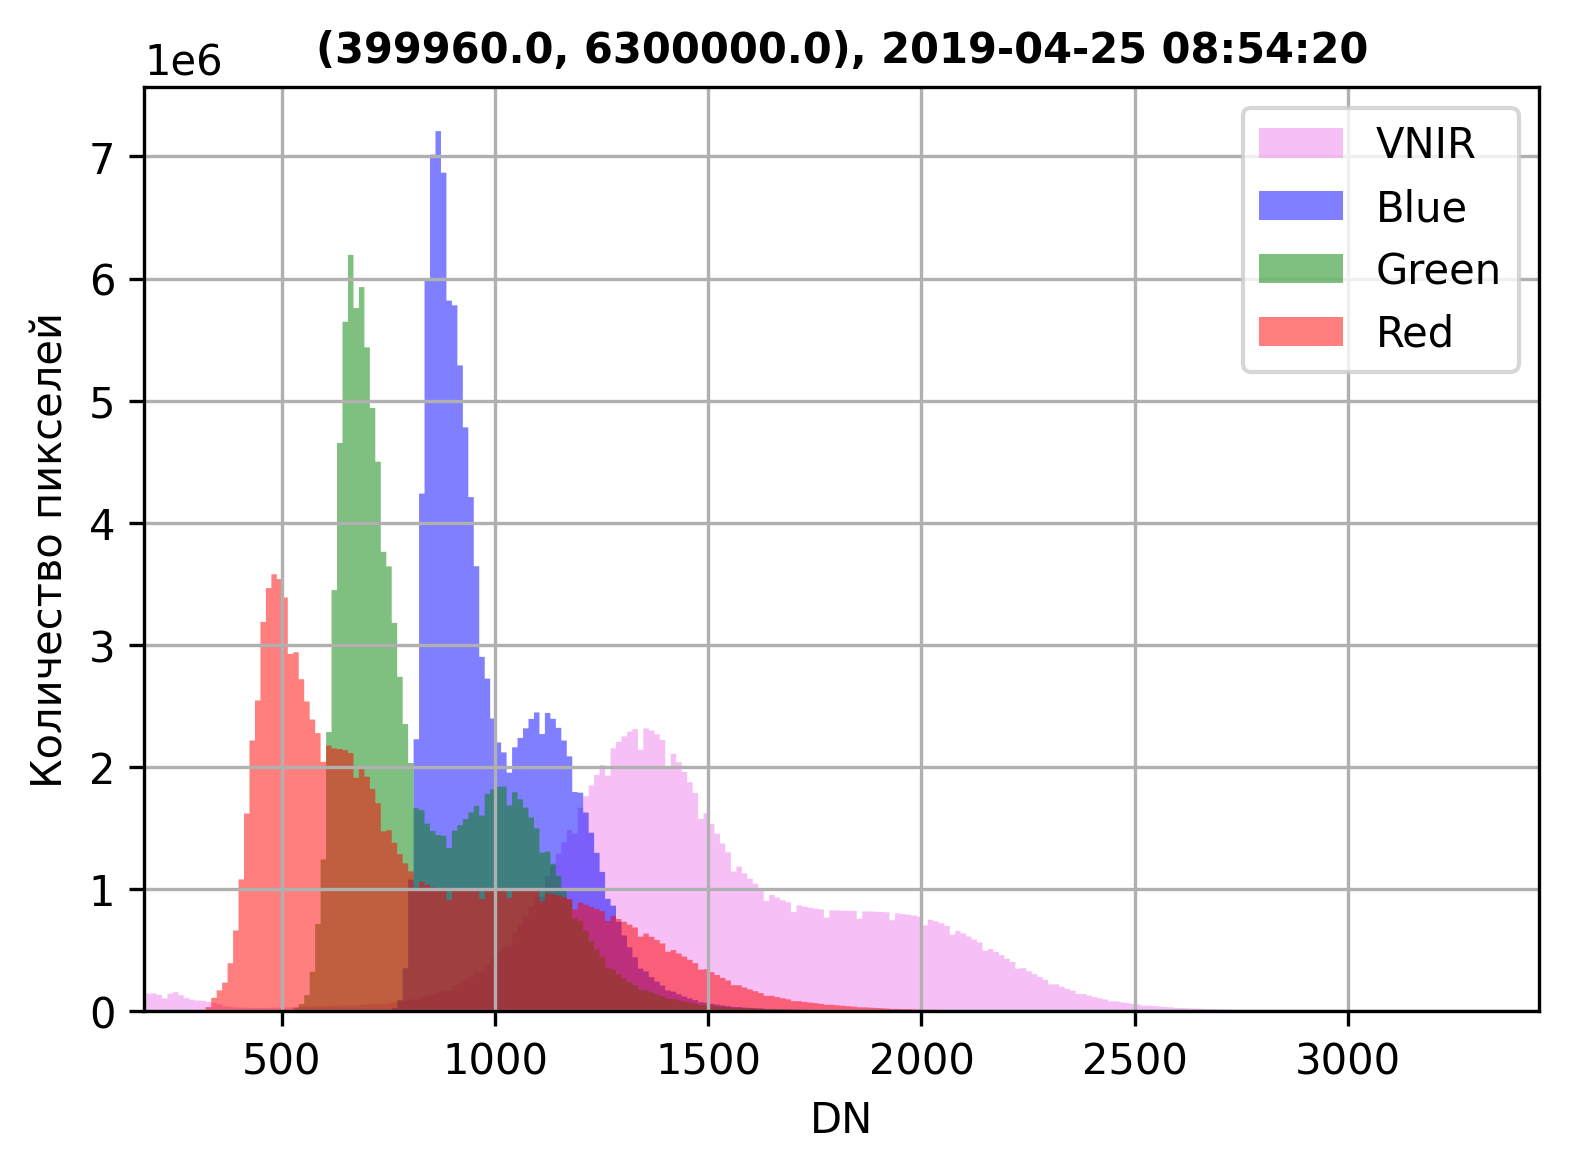

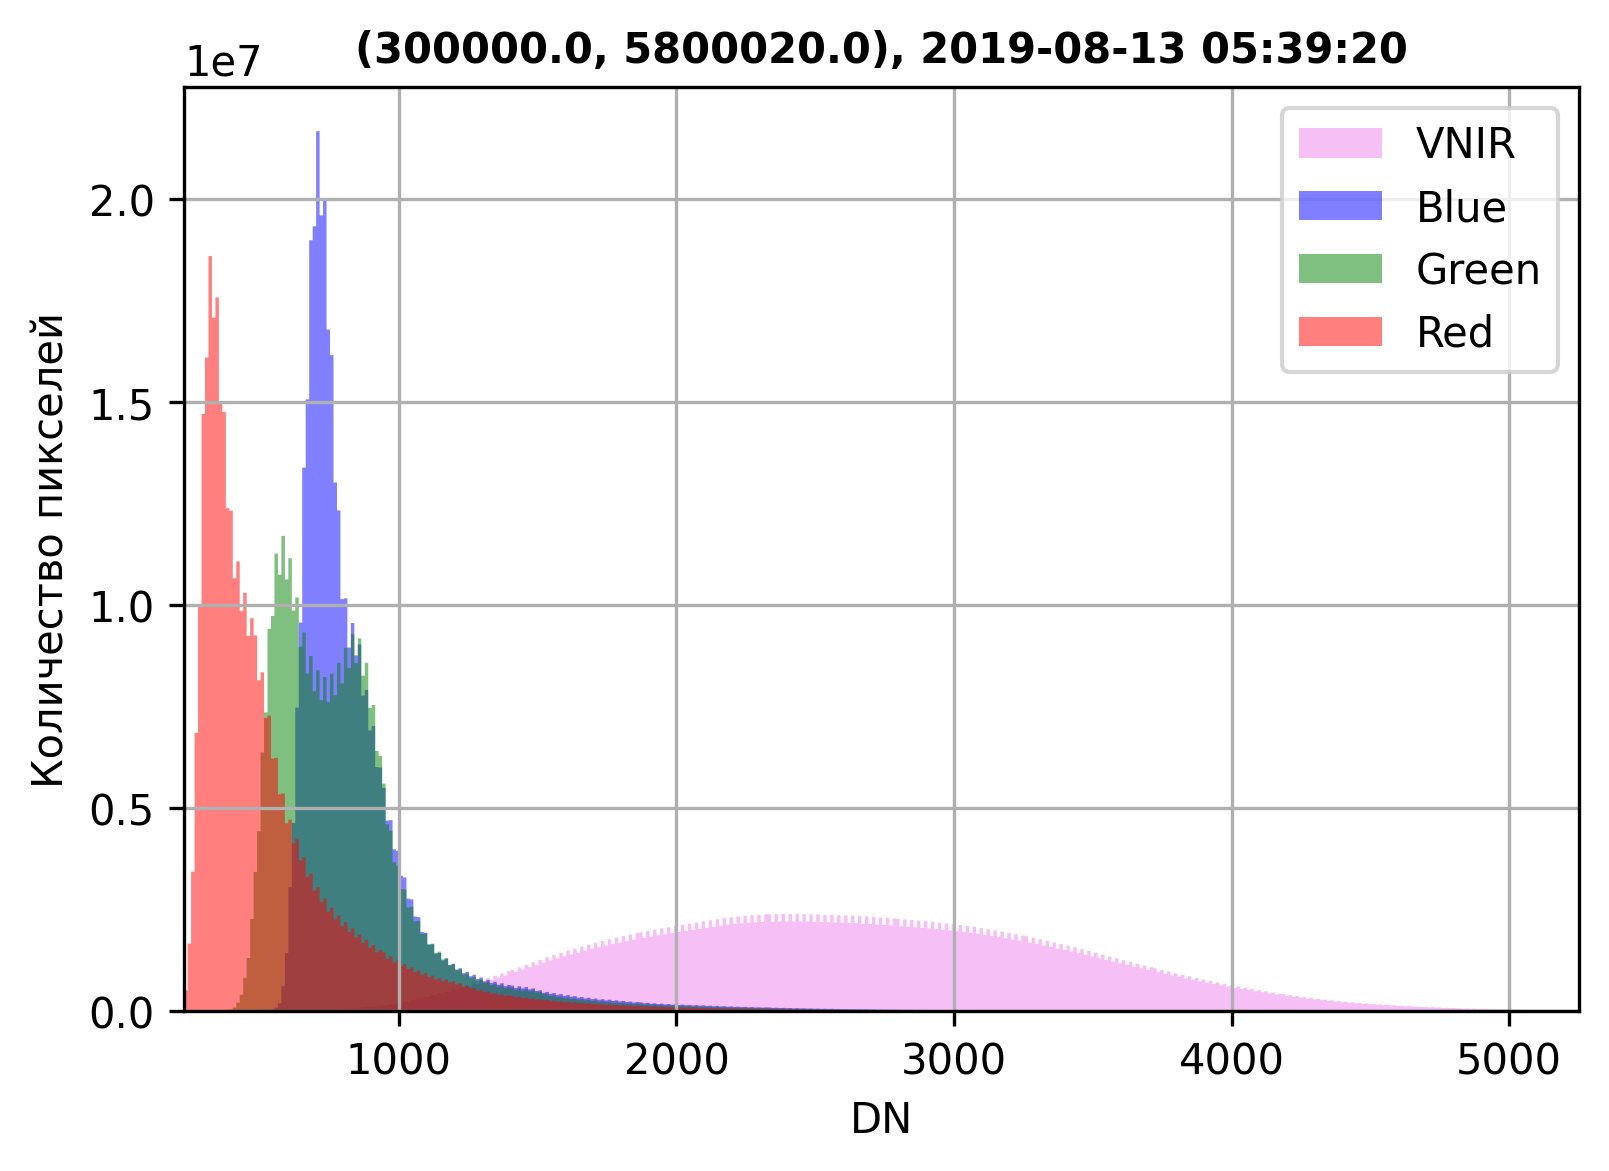

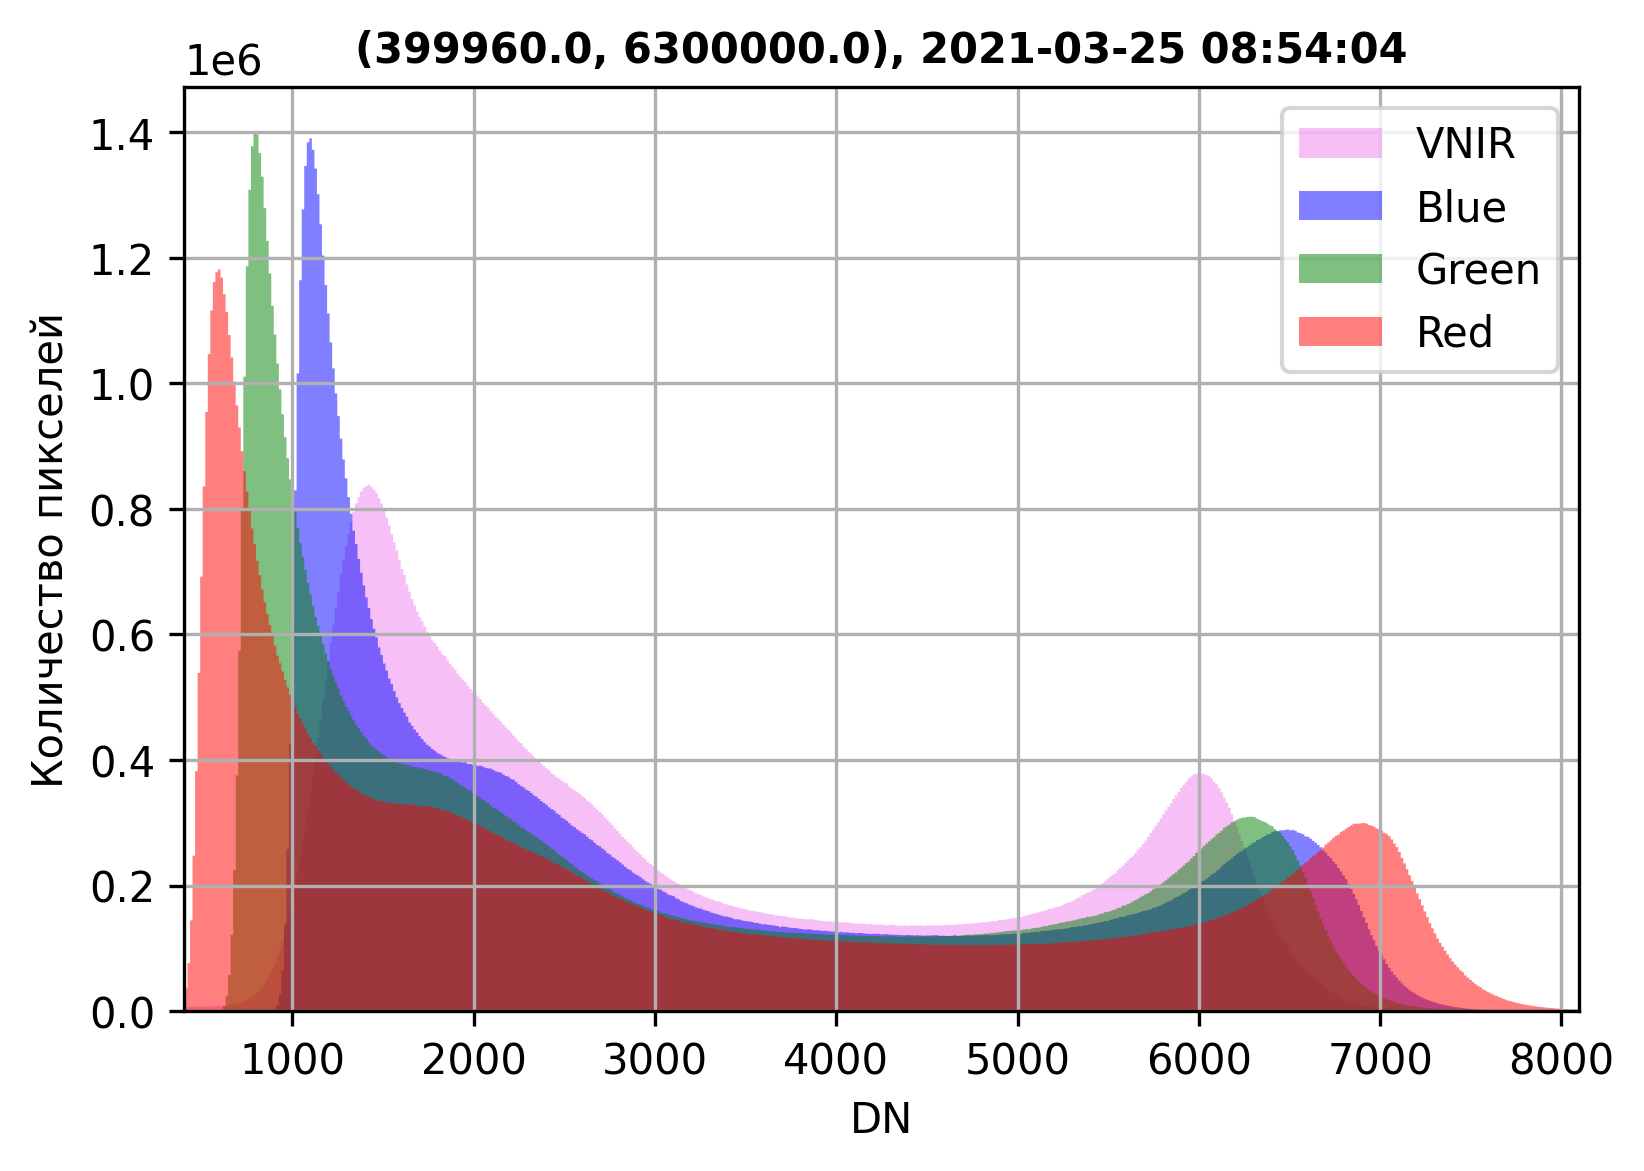

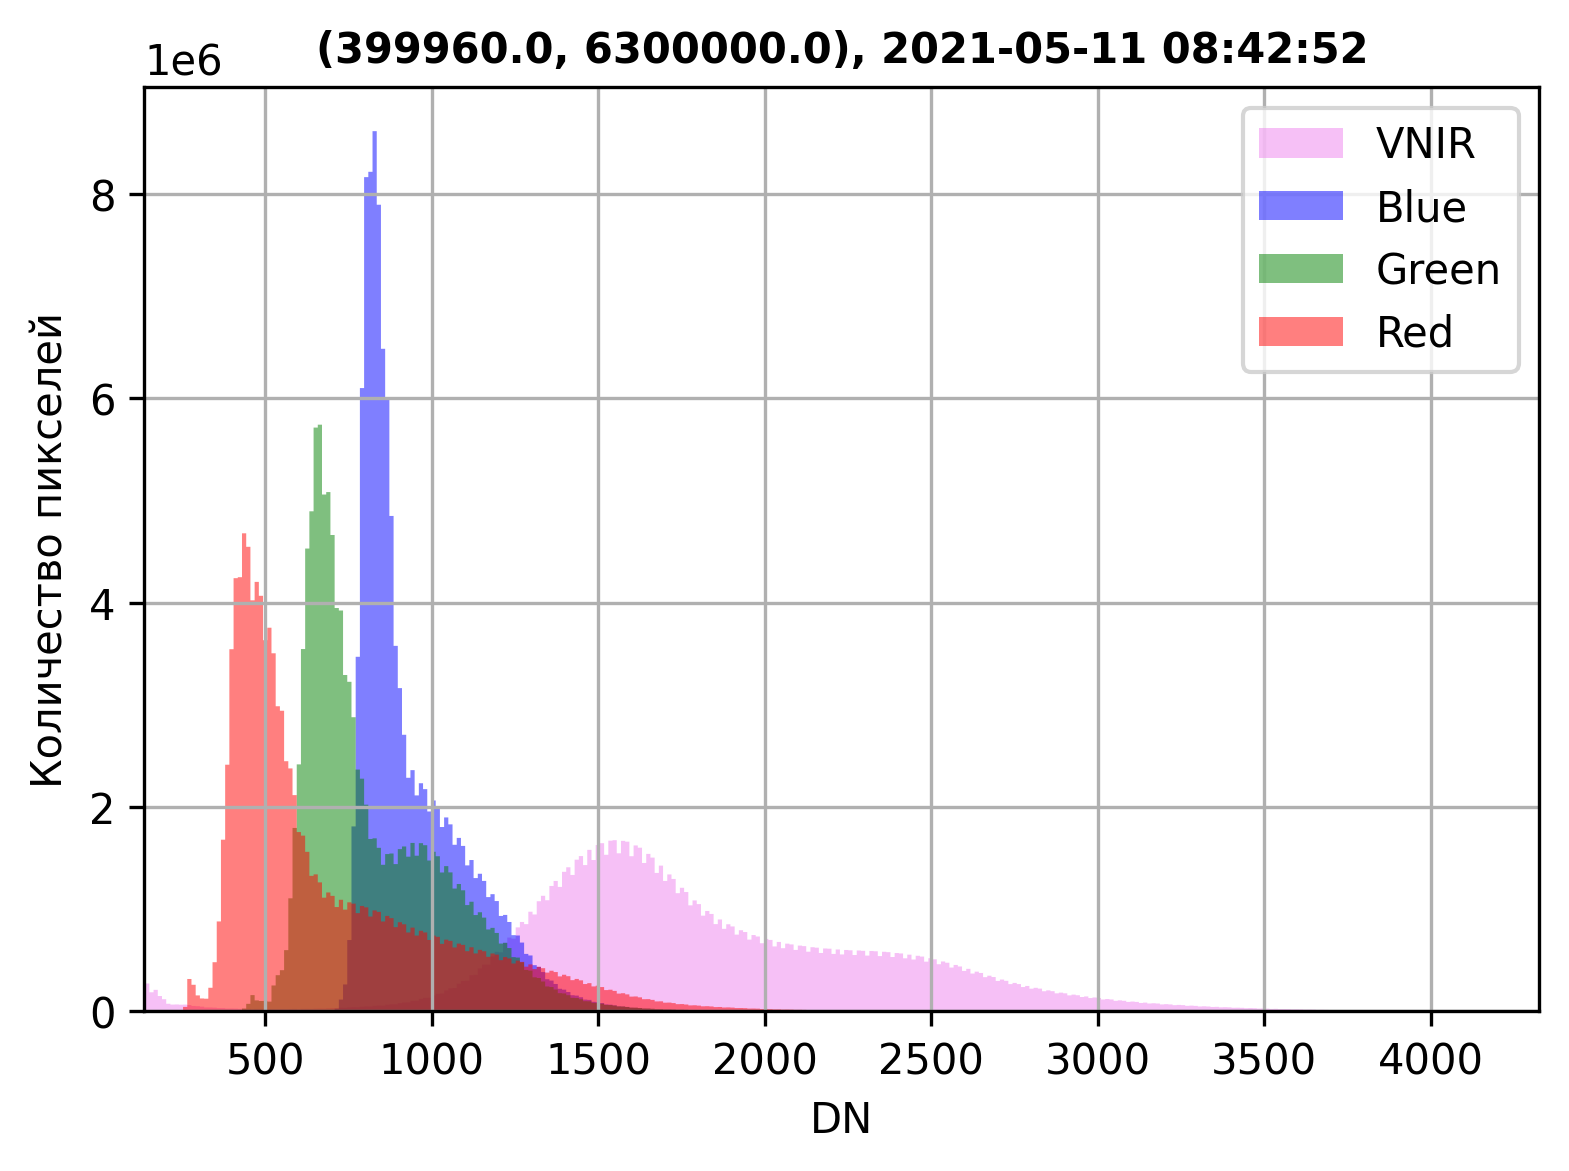

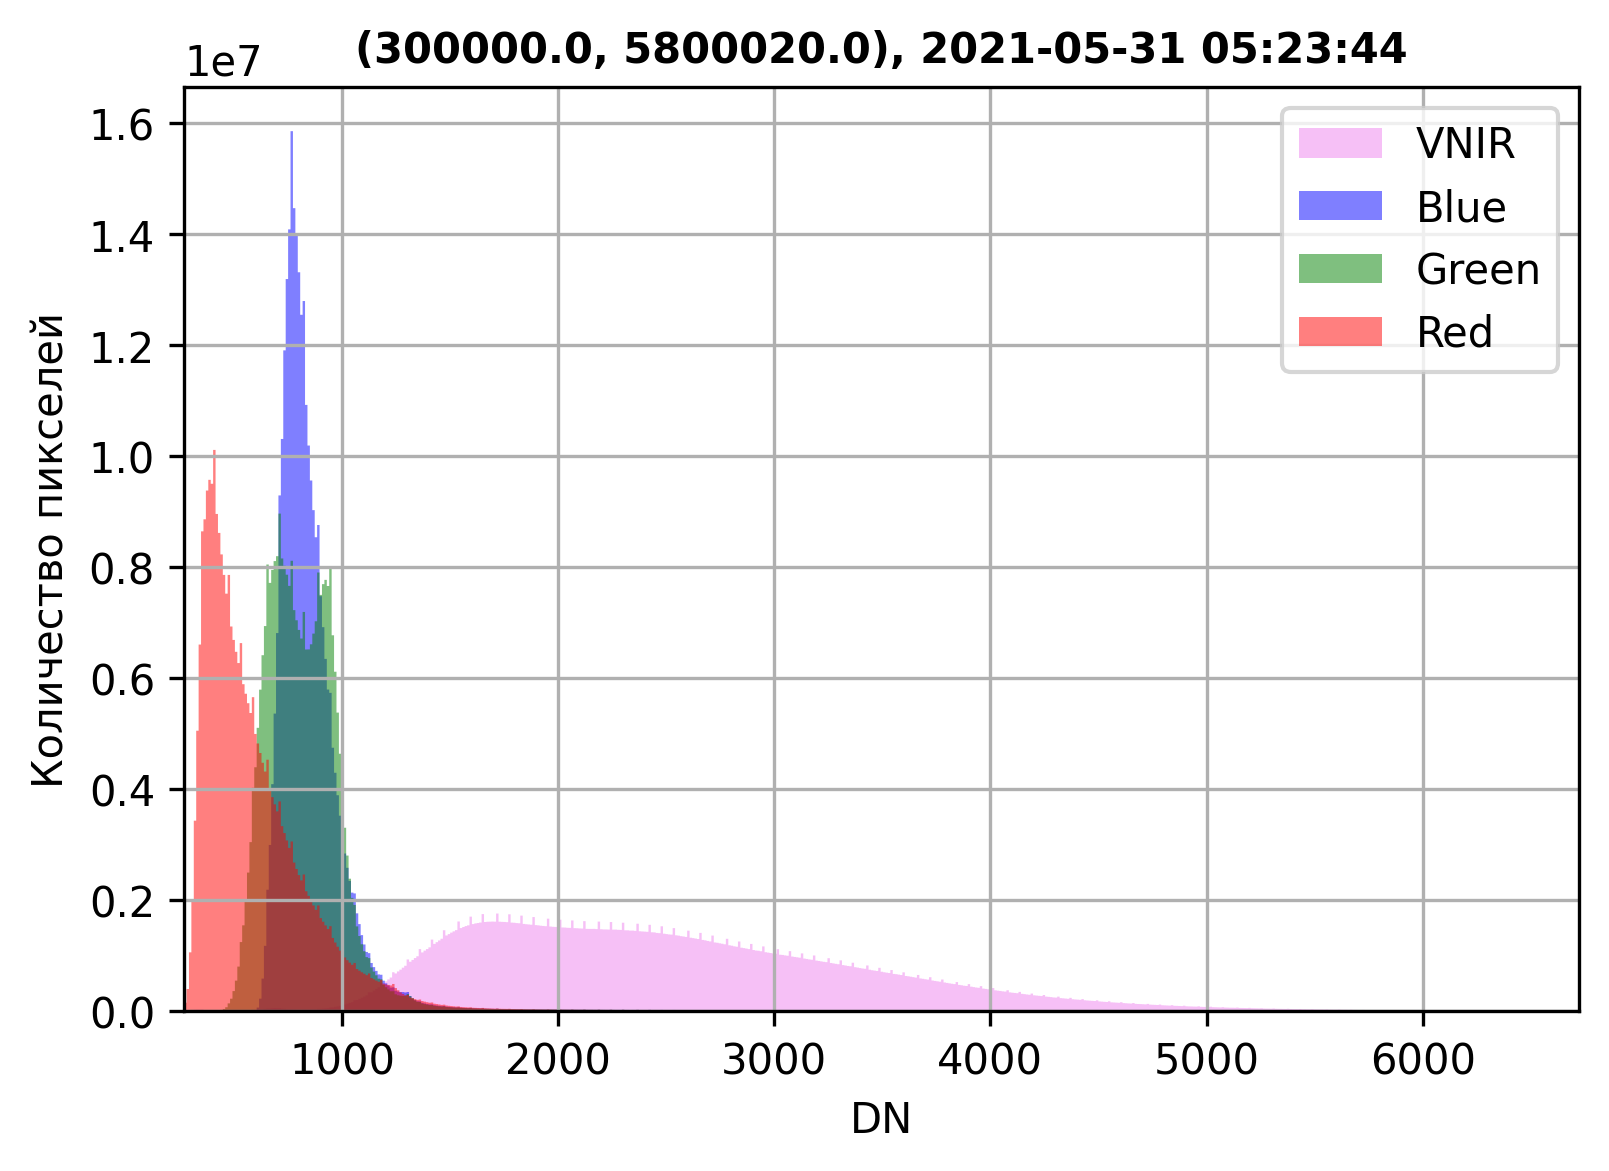

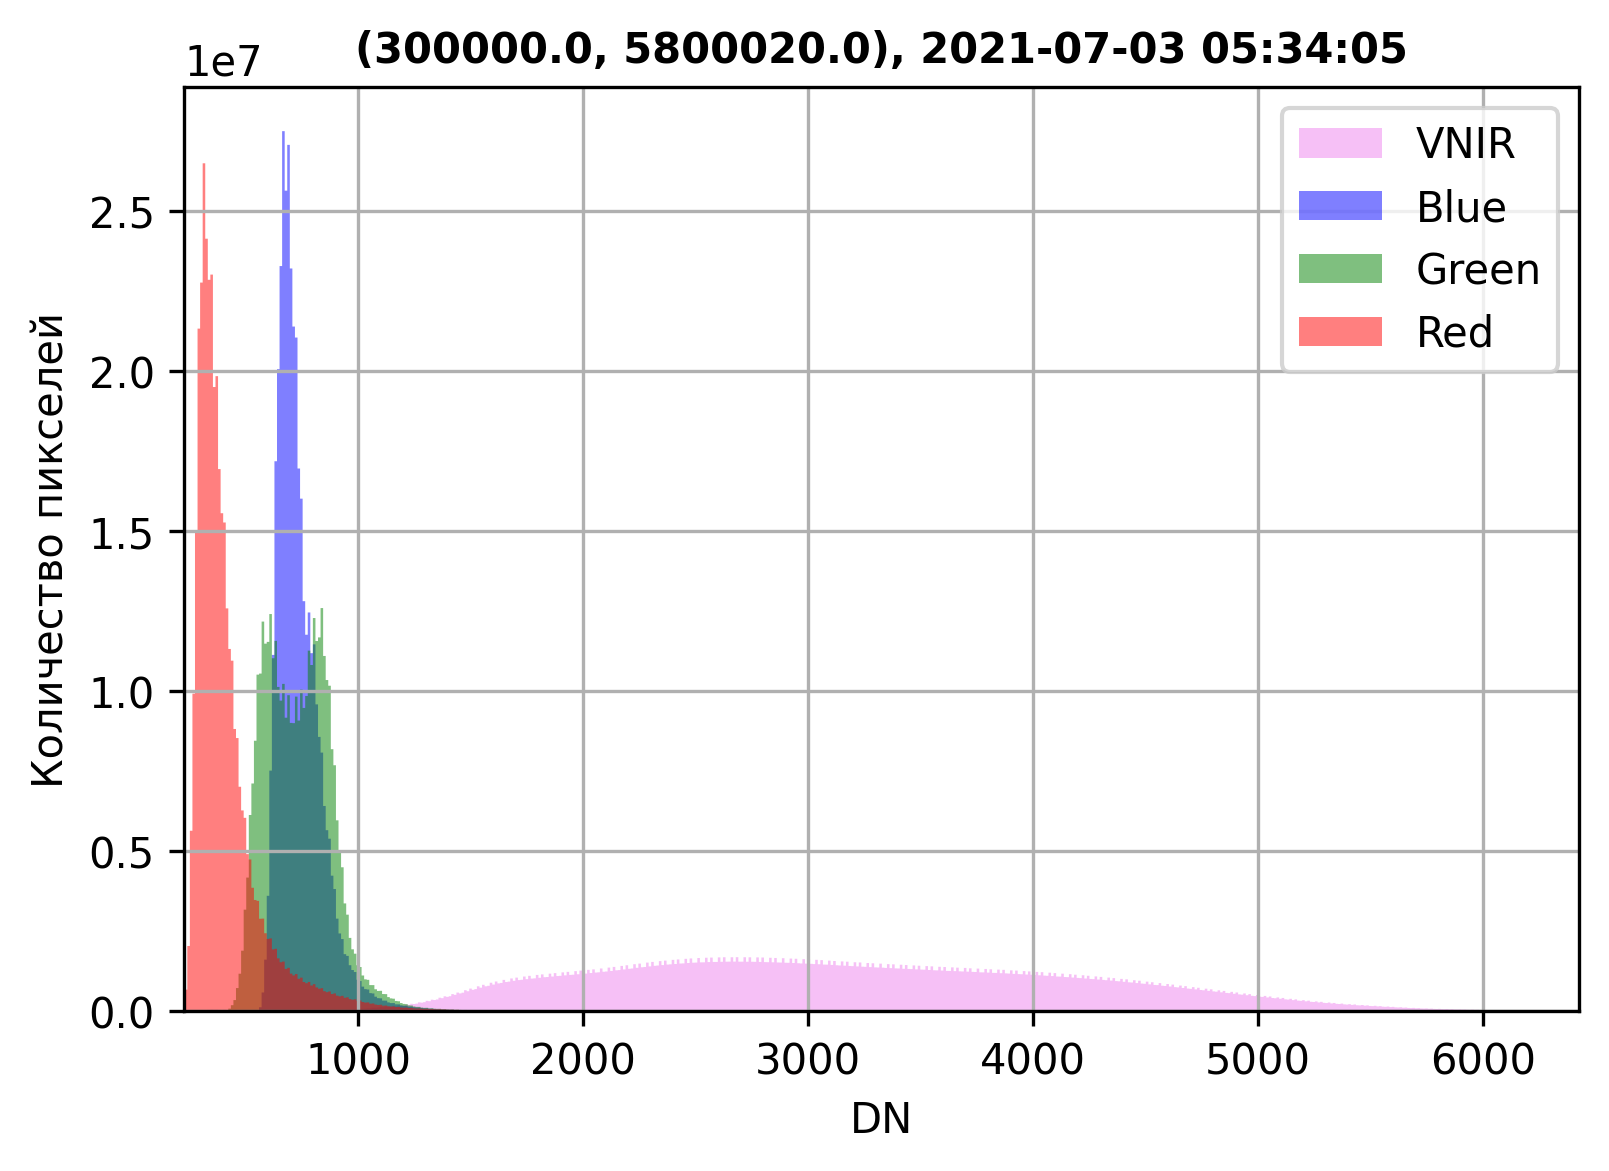

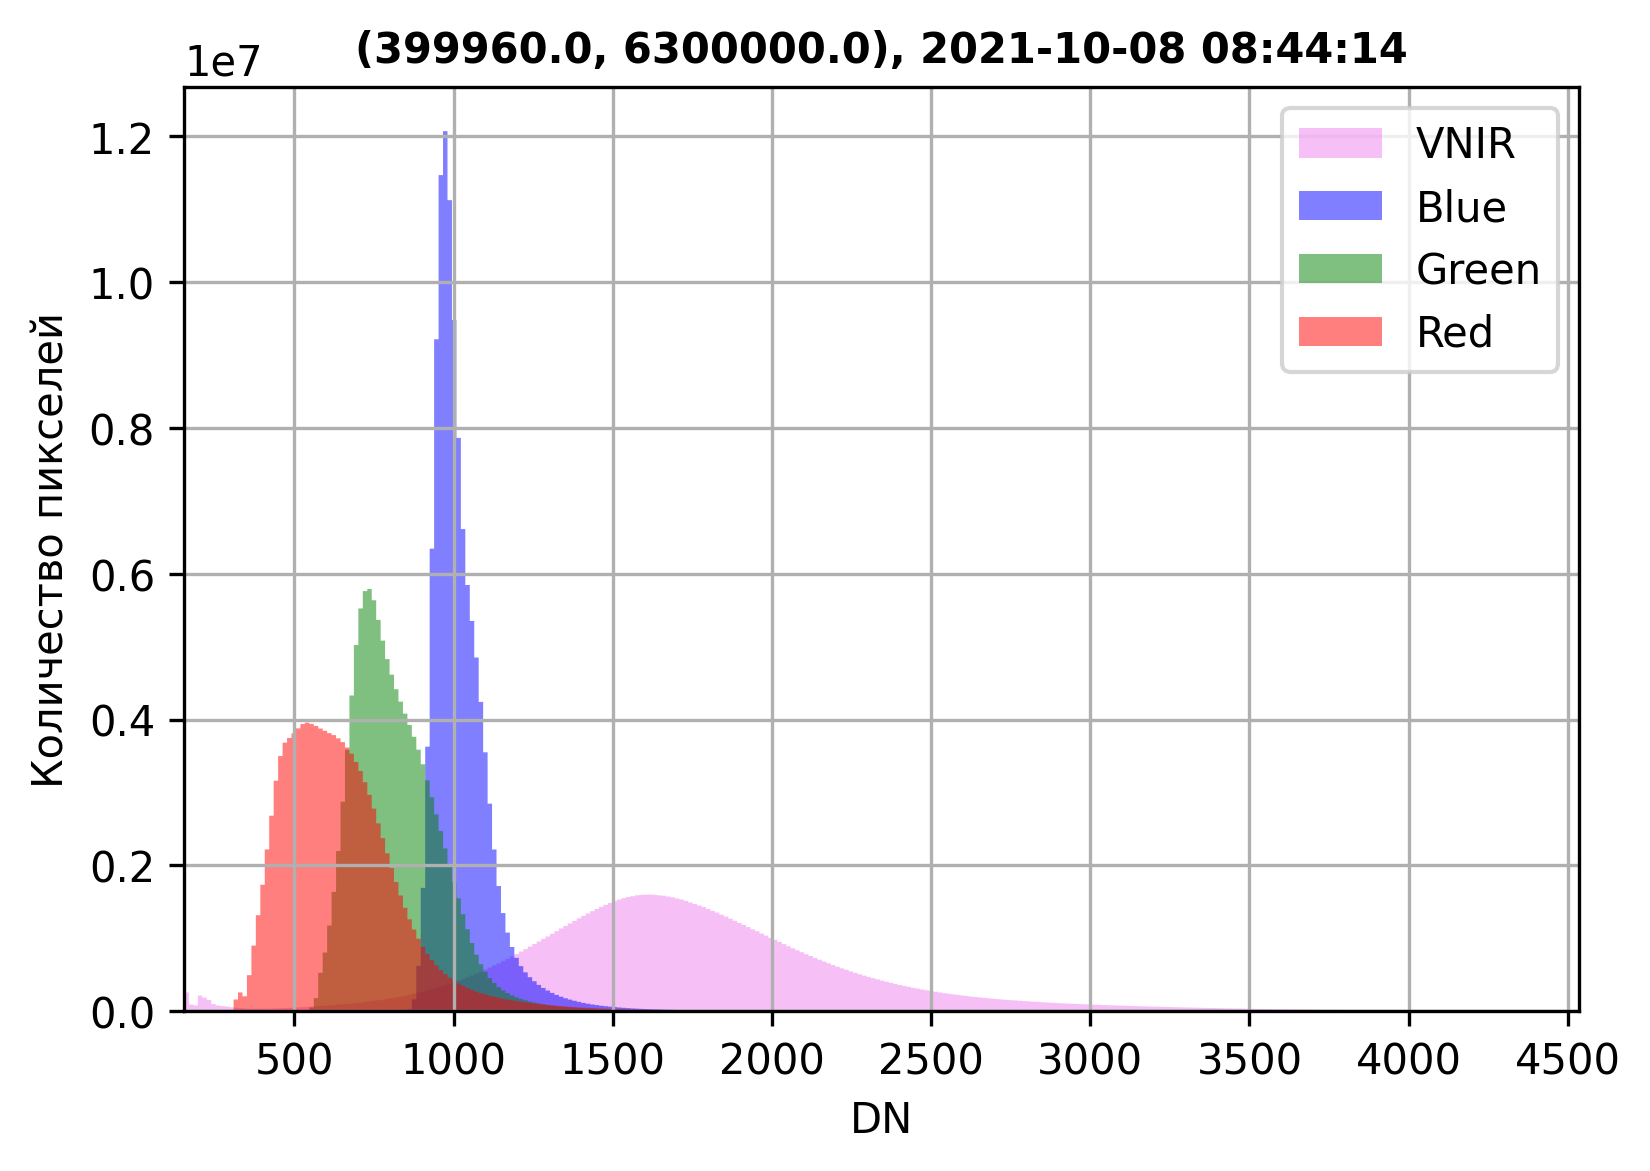

CPU times: total: 13min 44s
Wall time: 16min 44s


In [177]:
%%time

data_dirs = list(info["dirname"])

for data_dir in data_dirs:
    data_path = os.path.join(combined_rgbvnir_dir, f"{data_dir}_1_RGBVNIR.tif")
    data_info = info[info["dirname"] == data_dir]
    x, y = float(data_info["left_x"]), float(data_info["top_y"])
    dt = data_info["datetime"].values[0]
    title = f"({x}, {y}), {dt}"
    with rio.open(data_path) as src_img:
        data = src_img.read(masked=True)
    flat_data = data.compressed()  # https://numpy.org/doc/stable/reference/maskedarray.generic.html#accessing-only-the-valid-entries
    xlim_left = np.quantile(flat_data, 0.0001)
    xlim_right = np.quantile(flat_data, 0.9999)

    plot_path = os.path.join(merged_data_plots_dir, f"{data_dir}_1_hist.png")
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    show_hist(
        data, masked=True, bins=2000, ax=ax, histtype="stepfilled", alpha=0.5, label=["Red", "Green", "Blue", "VNIR"]
    )
    ax.set_xlim(xlim_left, xlim_right)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_ylabel("Количество пикселей")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

## 7.